In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from scipy import stats
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, auc, roc_curve
import gc
import time

In [2]:
# Useful function for reducing memory usage of a dataframe (found it on the interwebs!)
def reduce_memory(df):
    """Reduce memory usage of a dataframe by setting data types. """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Initial df memory usage is {:.2f} MB for {} columns'
          .format(start_mem, len(df.columns)))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            cmin = df[col].min()
            cmax = df[col].max()
            if str(col_type)[:3] == 'int':
                # Can use unsigned int here too
                if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif cmin > np.iinfo(np.int64).min and cmax < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    memory_reduction = 100 * (start_mem - end_mem) / start_mem
    print('Final memory usage is: {:.2f} MB - decreased by {:.1f}%'.format(end_mem, memory_reduction))
    return df

# Data exploration
First we will explore the data for insights

## Application table

In [3]:
application_train = reduce_memory(pd.read_csv('./datasets/application_train.csv'))

Initial df memory usage is 286.23 MB for 122 columns
Final memory usage is: 92.38 MB - decreased by 67.7%


In [ ]:
application_test = pd.read_csv('./datasets/application_test.csv')

In [ ]:
application_all = pd.concat([application_train.drop(columns=['TARGET'],axis = 1),application_test], sort=True)

In [4]:
application_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
SK_ID_CURR                      int32
TARGET                          int8
NAME_CONTRACT_TYPE              object
CODE_GENDER                     object
FLAG_OWN_CAR                    object
FLAG_OWN_REALTY                 object
CNT_CHILDREN                    int8
AMT_INCOME_TOTAL                float32
AMT_CREDIT                      float32
AMT_ANNUITY                     float32
AMT_GOODS_PRICE                 float32
NAME_TYPE_SUITE                 object
NAME_INCOME_TYPE                object
NAME_EDUCATION_TYPE             object
NAME_FAMILY_STATUS              object
NAME_HOUSING_TYPE               object
REGION_POPULATION_RELATIVE      float16
DAYS_BIRTH                      int16
DAYS_EMPLOYED                   int32
DAYS_REGISTRATION               float16
DAYS_ID_PUBLISH                 int16
OWN_CAR_AGE                     float16
FLAG_MOBIL                     

In [4]:
pd.options.display.max_columns = None
application_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.0,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,reg oper account,block of flats,0.014900,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.984863,0.804199,0.049713,0.080627,0.034485,0.291748,0.333252,0.012802,0.078979,0.055389,0.0,0.0,0.096802,0.052887,0.984863,0.798828,0.060791,0.080017,0.034485,0.291748,0.333252,0.013199,0.078674,0.055786,0.003901,0.010002,reg oper account,block of flats,0.071411,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,

We can see that we have a lot of columns. This means that there is a possible dimensionality reduction to be done here.
We can also observe that we have a some missing data. We should look and see how many missing values we have and how we should deal with them.
Finally, we can see that we have a lot of categorical features. We should analyse them in order to come up with a proper encoding. 

### Data balance

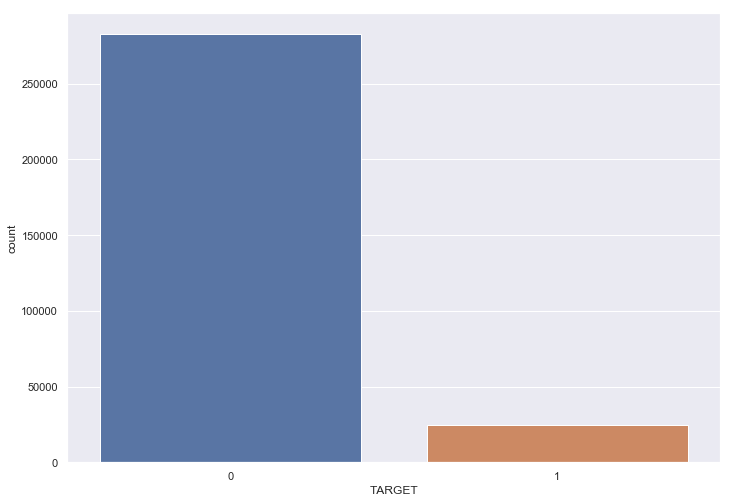

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.countplot(x="TARGET", data=application_train)

We can see that our data is highly skewed! (most applicants didn't have any payment difficulties)

---

### Missing values

In [5]:
def list_missing_data(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = ((total/df.SK_ID_CURR.count())*100).sort_values(ascending = False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', '%'], sort=True)
    missing_data = missing_data[(missing_data['%'] > 0)]
    return missing_data.sort_values(by='%', ascending=False)

missing_data_list = list_missing_data(application_all)
missing_data_list.head(50)

NameError: name 'application_all' is not defined

For now, we will not be using most of the columns with more than 60% missing values.

In [7]:
columns_to_ignore = missing_data_list[missing_data_list['%']>60].index.tolist()
columns_to_ignore

['COMMONAREA_AVG',
 'COMMONAREA_MODE',
 'COMMONAREA_MEDI',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MODE',
 'FONDKAPREMONT_MODE',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAPARTMENTS_MODE',
 'FLOORSMIN_MODE',
 'FLOORSMIN_MEDI',
 'FLOORSMIN_AVG',
 'YEARS_BUILD_MODE',
 'YEARS_BUILD_MEDI',
 'YEARS_BUILD_AVG',
 'OWN_CAR_AGE']

In [5]:
application_train.drop([
    'FLAG_CONT_MOBILE',
    'FLAG_WORK_PHONE',
    'FLAG_PHONE',
    'FLAG_EMAIL',
    'APARTMENTS_AVG',
    'BASEMENTAREA_AVG',
    'YEARS_BEGINEXPLUATATION_AVG',
    'ELEVATORS_AVG',
    'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_30_CNT_SOCIAL_CIRCLE',
    'HOUR_APPR_PROCESS_START',
    'COMMONAREA_MODE',
    'COMMONAREA_MEDI',
    'NONLIVINGAPARTMENTS_AVG',
    'NONLIVINGAPARTMENTS_MEDI',
    'NONLIVINGAPARTMENTS_MODE',
    'FONDKAPREMONT_MODE',
    'LIVINGAPARTMENTS_AVG',
    'LIVINGAPARTMENTS_MEDI',
    'LIVINGAPARTMENTS_MODE',
    'FLOORSMIN_MODE',
    'FLOORSMIN_MEDI',
    'FLOORSMIN_AVG',
    'YEARS_BUILD_MODE',
    'YEARS_BUILD_MEDI',
    'YEARS_BUILD_AVG',
    'COMMONAREA_AVG',
    'ENTRANCES_AVG', 
    'FLOORSMAX_AVG', 
    'LANDAREA_AVG', 
    'LIVINGAREA_AVG', 
    'NONLIVINGAREA_AVG', 
    'APARTMENTS_MODE', 
    'BASEMENTAREA_MODE', 
    'YEARS_BEGINEXPLUATATION_MODE',
    'ELEVATORS_MODE', 
    'ENTRANCES_MODE', 
    'FLOORSMAX_MODE', 
    'LANDAREA_MODE', 
    'LIVINGAREA_MODE', 
    'NONLIVINGAREA_MODE',
    'APARTMENTS_MEDI', 
    'BASEMENTAREA_MEDI', 
    'YEARS_BEGINEXPLUATATION_MEDI', 
    'ELEVATORS_MEDI', 
    'ENTRANCES_MEDI',
    'FLOORSMAX_MEDI', 
    'LANDAREA_MEDI', 
    'LIVINGAREA_MEDI', 
    'NONLIVINGAREA_MEDI', 
    'HOUSETYPE_MODE', 
    'TOTALAREA_MODE', 
    'WALLSMATERIAL_MODE' 
    ], axis=1, inplace=True)

### Outliers
We will now see if there are any outliers in the data (extreme/weird values..) 

#### CODE_GENDER

In [8]:
application_train['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [9]:
application_test['CODE_GENDER'].value_counts()

F    32678
M    16066
Name: CODE_GENDER, dtype: int64

We have a 4 rows with the CODE_GENDER value 'XNA' in the training set, we will remove them.

In [6]:
application_train = application_train[application_train['CODE_GENDER'] != 'XNA']
application_train['CODE_GENDER'].value_counts()

F    202448
M    105059
Name: CODE_GENDER, dtype: int64

#### NAME_FAMILY_STATUS

In [7]:
application_train['NAME_FAMILY_STATUS'].value_counts()

Married                 196429
Single / not married     45444
Civil marriage           29774
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64

In [8]:
application_test['NAME_FAMILY_STATUS'].value_counts()

NameError: name 'application_test' is not defined

We have two people with 'Unknown' status in the training set, we will remove them.

In [7]:
application_train = application_train[application_train['NAME_FAMILY_STATUS'] != 'Unknown']
application_train['NAME_FAMILY_STATUS'].value_counts()

Married                 196429
Single / not married     45444
Civil marriage           29774
Separated                19770
Widow                    16088
Name: NAME_FAMILY_STATUS, dtype: int64

#### CNT_CHILDREN

In [14]:
application_all['CNT_CHILDREN'].describe() # 20 children?! Why not ..

count    356255.000000
mean          0.414316
std           0.720378
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: CNT_CHILDREN, dtype: float64

In [6]:
del application_all
gc.collect()

NameError: name 'application_all' is not defined

#### DAYS_EMPLOYED

In [16]:
(application_train['DAYS_EMPLOYED']/-365).describe() 

count    307505.000000
mean       -174.839312
std         387.059825
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [17]:
(application_test['DAYS_EMPLOYED']/-365).describe() 

count    48744.000000
mean      -184.891415
std        395.475362
min      -1000.665753
25%          0.810959
50%          3.542466
75%          7.972603
max         47.843836
Name: DAYS_EMPLOYED, dtype: float64

Here we have a wrong value for the current emplyment duration. We will remove this value

There are a lot of rows with this value. We will replace it with NaN for now, and later, when we will bin the column, we will place them in a seperate bin.

In [8]:
application_train['DAYS_EMPLOYED'] = application_train['DAYS_EMPLOYED'].replace(365243, np.NaN)
(application_train['DAYS_EMPLOYED']/-365).describe() 

count    252131.000000
mean          6.531933
std           6.406388
min          -0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [7]:
application_test['DAYS_EMPLOYED'] = application_test['DAYS_EMPLOYED'].replace(365243, np.NaN)
(application_test['DAYS_EMPLOYED']/-365).describe() 

NameError: name 'application_test' is not defined

#### OCCUPATION_TYPE

In [20]:
application_train['OCCUPATION_TYPE'].value_counts()

Laborers                 55186
Sales staff              32102
Core staff               27569
Managers                 21370
Drivers                  18603
High skill tech staff    11380
Accountants               9812
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2092
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

In [21]:
application_test['OCCUPATION_TYPE'].value_counts()

Laborers                 8655
Sales staff              5072
Core staff               4361
Managers                 3574
Drivers                  2773
High skill tech staff    1854
Accountants              1628
Medicine staff           1316
Security staff            915
Cooking staff             894
Cleaning staff            656
Private service staff     455
Low-skill Laborers        272
Secretaries               213
Waiters/barmen staff      178
Realty agents             138
HR staff                  104
IT staff                   81
Name: OCCUPATION_TYPE, dtype: int64

We have the same categories for train/test sets

#### ORGANIZATION_TYPE

In [22]:
application_train['ORGANIZATION_TYPE'].value_counts()

Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11192
Business Entity Type 2    10552
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6879
Construction               6721
Business Entity Type 1     5983
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3277
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7           1307
Transpor

In [23]:
application_test['ORGANIZATION_TYPE'].value_counts()

Business Entity Type 3    10840
XNA                        9274
Self-employed              5920
Other                      2707
Medicine                   1716
Government                 1508
Business Entity Type 2     1479
Trade: type 7              1303
School                     1287
Construction               1039
Kindergarten               1038
Business Entity Type 1      887
Transport: type 4           884
Trade: type 3               578
Military                    530
Industry: type 9            499
Industry: type 3            489
Security                    472
Transport: type 2           448
Police                      441
Housing                     435
Industry: type 11           416
Bank                        374
Security Ministries         341
Services                    302
Postal                      294
Agriculture                 292
Restaurant                  284
Trade: type 2               242
University                  221
Industry: type 7            217
Industry

#### AMT_INCOME_TOTAL

In [24]:
application_train['AMT_INCOME_TOTAL'].describe() 

count    3.075050e+05
mean     1.687967e+05
std      2.371248e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

In [25]:
application_test['AMT_INCOME_TOTAL'].describe() 

count    4.874400e+04
mean     1.784318e+05
std      1.015226e+05
min      2.694150e+04
25%      1.125000e+05
50%      1.575000e+05
75%      2.250000e+05
max      4.410000e+06
Name: AMT_INCOME_TOTAL, dtype: float64

We have some outliers in the training data (people making over 1M).

**Decomposition in the train set:**

In [26]:
print('Number of clients making more than 1M: {}'.format(application_train.AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 1000000)].count()))
print('Number of clients making more than 2M: {}'.format(application_train.AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 2000000)].count()))
print('Number of clients making more than 4M: {}'.format(application_train.AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 4000000)].count()))
print('Number of clients making more than 10M: {}'.format(application_train.AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 10000000)].count()))
print('Number of clients making more than 100M: {}'.format(application_train.AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 100000000)].count()))

Number of clients making more than 1M: 250
Number of clients making more than 2M: 44
Number of clients making more than 4M: 9
Number of clients making more than 10M: 3
Number of clients making more than 100M: 1


**Decomposition in the test set:**

In [27]:
print('Number of clients making more than 1M: {}'.format(application_test.AMT_INCOME_TOTAL[(application_test.AMT_INCOME_TOTAL > 1000000)].count()))
print('Number of clients making more than 2M: {}'.format(application_test.AMT_INCOME_TOTAL[(application_test.AMT_INCOME_TOTAL > 2000000)].count()))
print('Number of clients making more than 4M: {}'.format(application_test.AMT_INCOME_TOTAL[(application_test.AMT_INCOME_TOTAL > 4000000)].count()))
print('Number of clients making more than 10M: {}'.format(application_test.AMT_INCOME_TOTAL[(application_test.AMT_INCOME_TOTAL > 10000000)].count()))
print('Number of clients making more than 100M: {}'.format(application_test.AMT_INCOME_TOTAL[(application_test.AMT_INCOME_TOTAL > 100000000)].count()))

Number of clients making more than 1M: 38
Number of clients making more than 2M: 5
Number of clients making more than 4M: 1
Number of clients making more than 10M: 0
Number of clients making more than 100M: 0


We'll remove the entries of clients making more than 10M

In [9]:
application_train = application_train[(application_train.AMT_INCOME_TOTAL < 10000000)]

---

### Dataviz
In this part, we will visualize some data get general information about the data

#### Categorical features
First, we will deal with categorical features

##### NAME_CONTRACT_TYPE
Identification if loan is cash or revolving

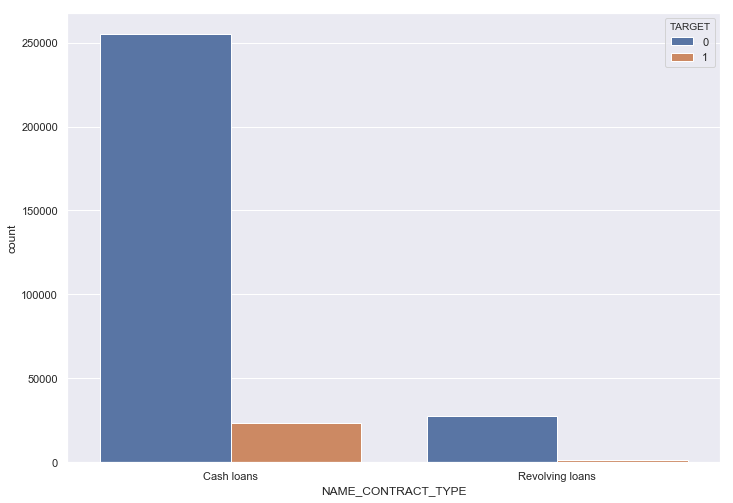

In [29]:
sns.countplot(x='NAME_CONTRACT_TYPE', hue='TARGET', data=application_train)

##### CODE_GENDER
Gender of the client

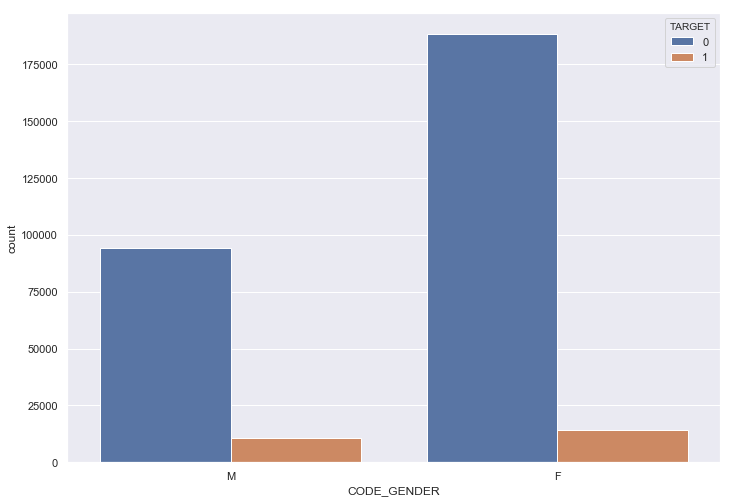

In [30]:
sns.countplot(x='CODE_GENDER', hue='TARGET', data=application_train)

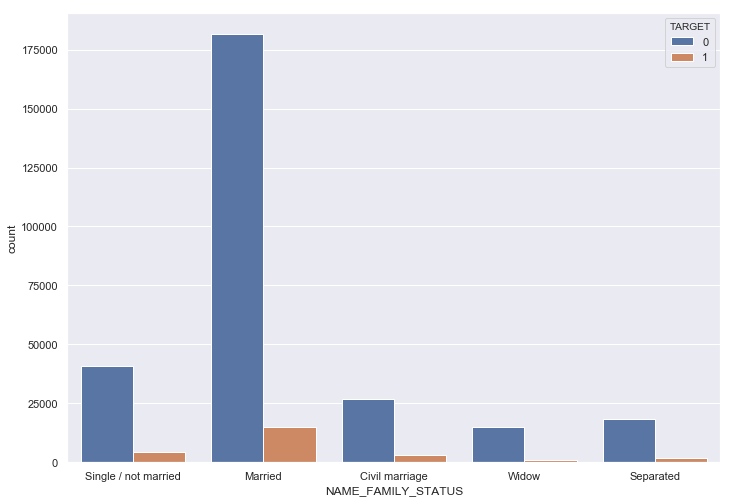

In [31]:
sns.countplot(x='NAME_FAMILY_STATUS', hue='TARGET', data=application_train)

##### FLAG_OWN_CAR
Flag if the client owns a car

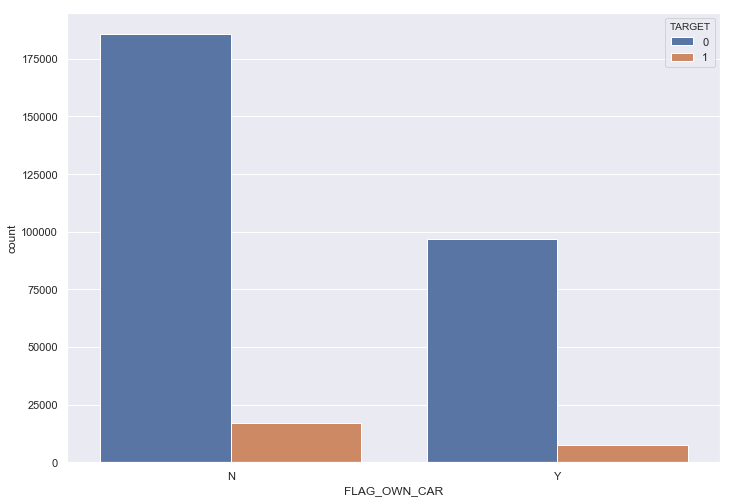

In [32]:
sns.countplot(x='FLAG_OWN_CAR', hue='TARGET', data=application_train)

##### FLAG_OWN_REALTY
Flag if client owns a house or flat

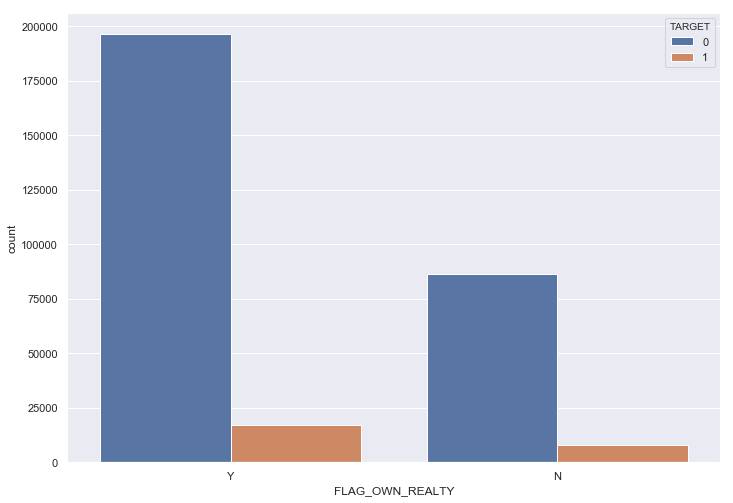

In [33]:
sns.countplot(x='FLAG_OWN_REALTY', hue='TARGET', data=application_train)

##### NAME_TYPE_SUITE
Who was accompanying client when he was applying for the loan

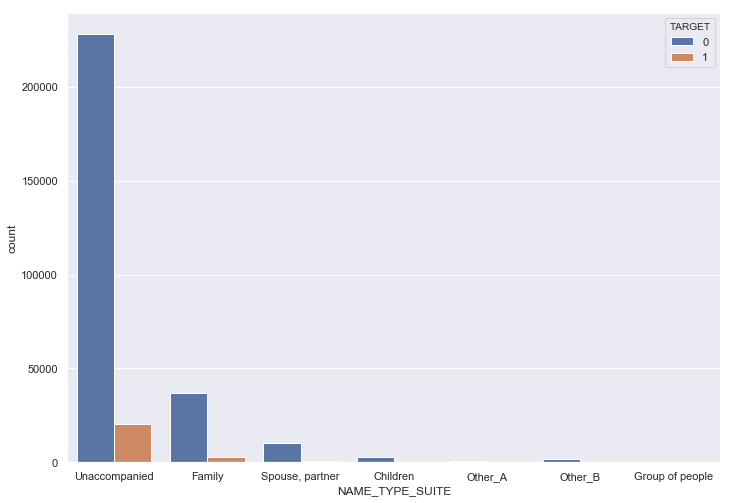

In [34]:
sns.countplot(x='NAME_TYPE_SUITE', hue='TARGET', data=application_train)

##### NAME_INCOME_TYPE
Clients income type (businessman, working, maternity leave,..)

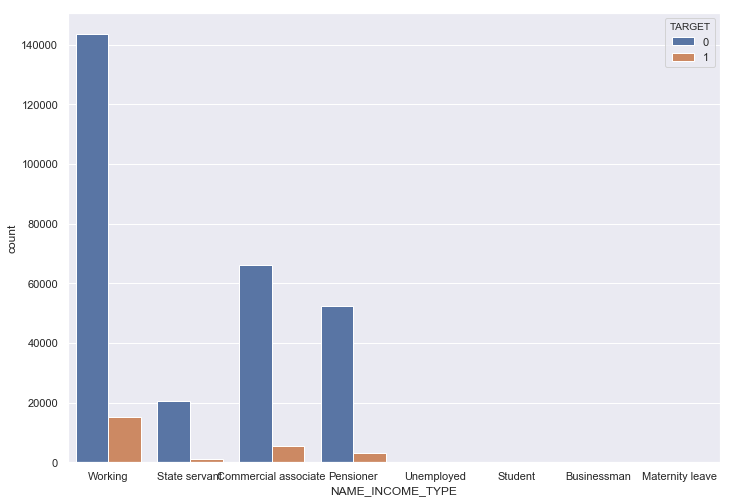

In [35]:
sns.countplot(x='NAME_INCOME_TYPE', hue='TARGET', data=application_train)

##### NAME_EDUCATION_TYPE
Level of highest education the client achieved

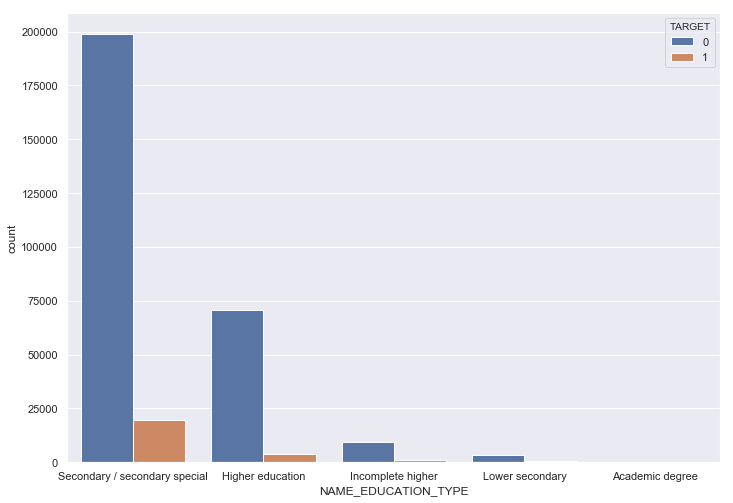

In [36]:
sns.countplot(x='NAME_EDUCATION_TYPE', hue='TARGET', data=application_train)

##### NAME_FAMILY_STATUS
Family status of the client

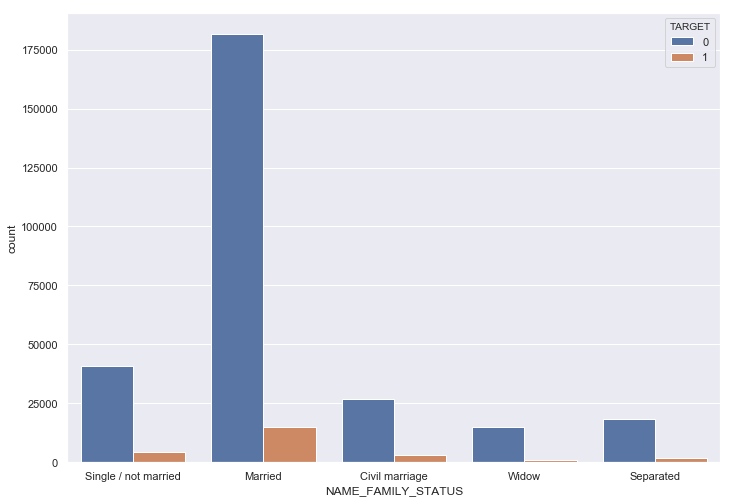

In [37]:
sns.countplot(x='NAME_FAMILY_STATUS', hue='TARGET', data=application_train)

##### NAME_HOUSING_TYPE
What is the housing situation of the client (renting, living with parents, ...)

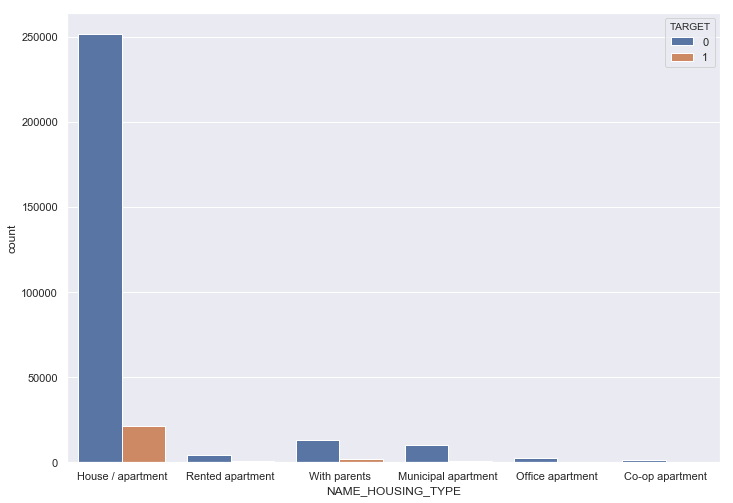

In [38]:
sns.countplot(x='NAME_HOUSING_TYPE', hue='TARGET', data=application_train)

##### OCCUPATION_TYPE
What kind of occupation does the client have

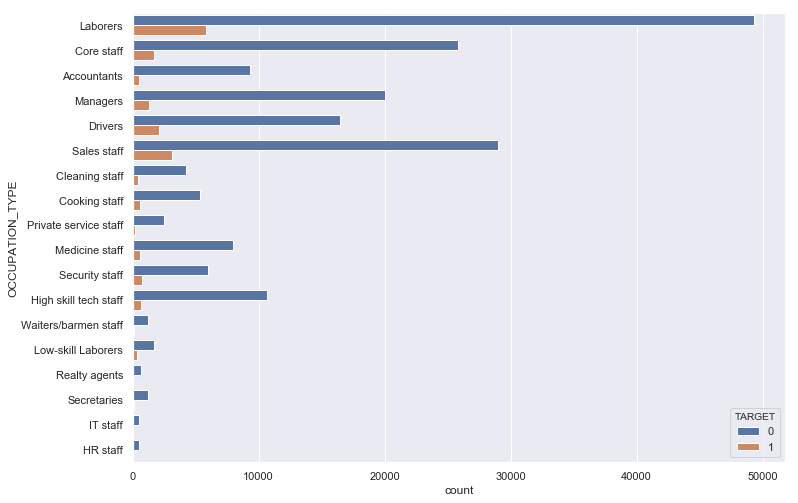

In [39]:
sns.countplot(y='OCCUPATION_TYPE', hue='TARGET', data=application_train)

##### WEEKDAY_APPR_PROCESS_START
On which day of the week did the client apply for the loan

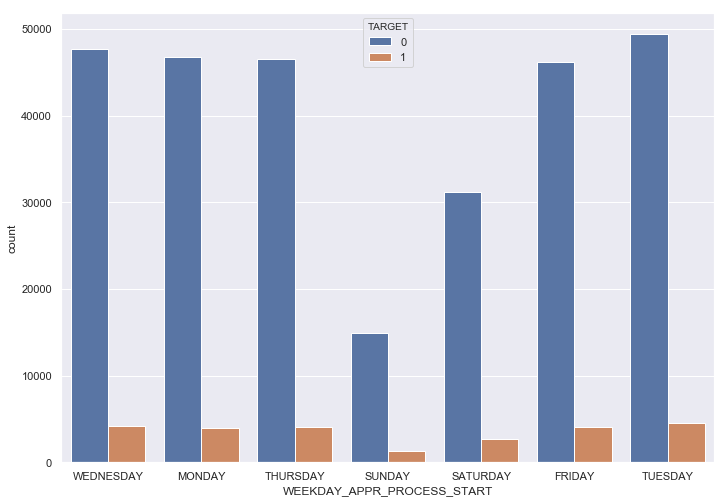

In [40]:
sns.countplot(x='WEEKDAY_APPR_PROCESS_START', hue='TARGET', data=application_train)

##### ORGANIZATION_TYPE
Type of organization where client works

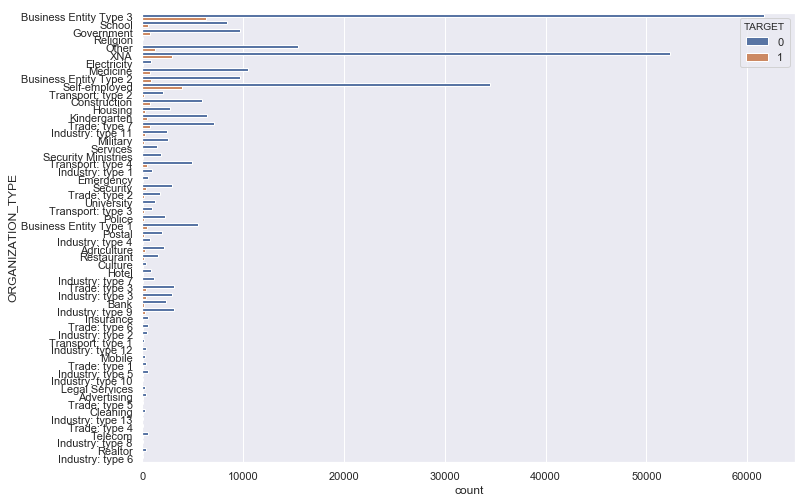

In [41]:
sns.countplot(y='ORGANIZATION_TYPE', hue='TARGET', data=application_train)

#### Numerical features
In this section, we will explore the numerical features 

##### AMT_INCOME_TOTAL
Income of the client

**Income distribution for the 0-800K range**

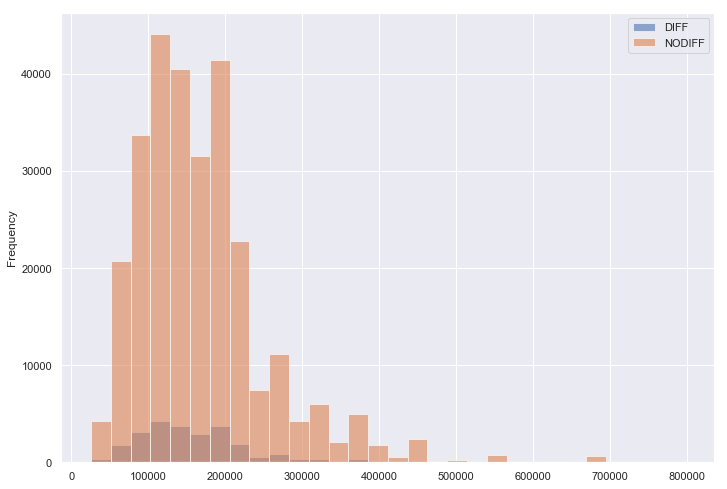

In [42]:
diff_AMT_INCOME_TOTAL = (application_train[application_train.TARGET == 1].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL < 800000)])
nodiff_AMT_INCOME_TOTAL = (application_train[application_train.TARGET == 0].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL < 800000)])

pd.DataFrame(
{'DIFF': diff_AMT_INCOME_TOTAL,
 'NODIFF': nodiff_AMT_INCOME_TOTAL},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 30,alpha=0.6)
plt.show()

**Income distribution for the 800K-2M range**

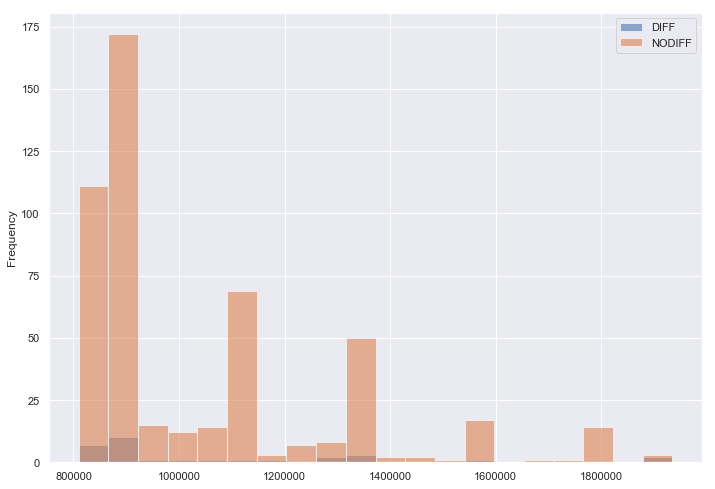

In [43]:
pd.DataFrame(
{'DIFF': application_train[application_train.TARGET == 1].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 800000) & (application_train.AMT_INCOME_TOTAL < 2000000)],
 'NODIFF': application_train[application_train.TARGET == 0].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 800000) & (application_train.AMT_INCOME_TOTAL < 2000000)]},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

**Income distribution for the 2M+ range**

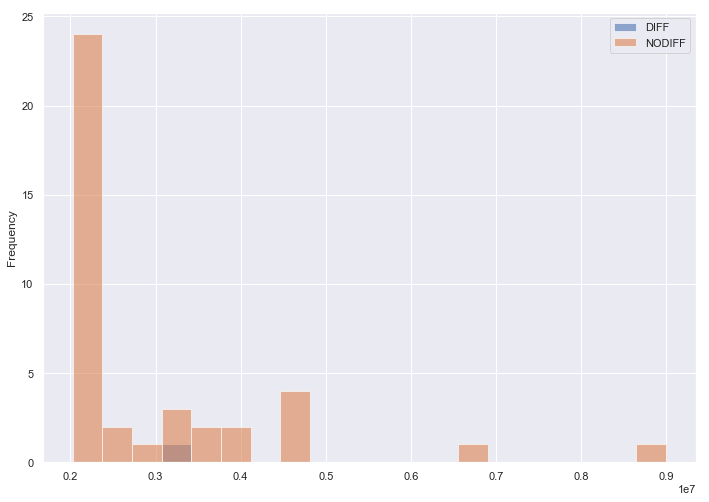

In [44]:
pd.DataFrame(
{'DIFF': application_train[application_train.TARGET == 1].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 2000000)],
 'NODIFF': application_train[application_train.TARGET == 0].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 2000000)]},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

#### AMT_CREDIT
Credit amount of the loan

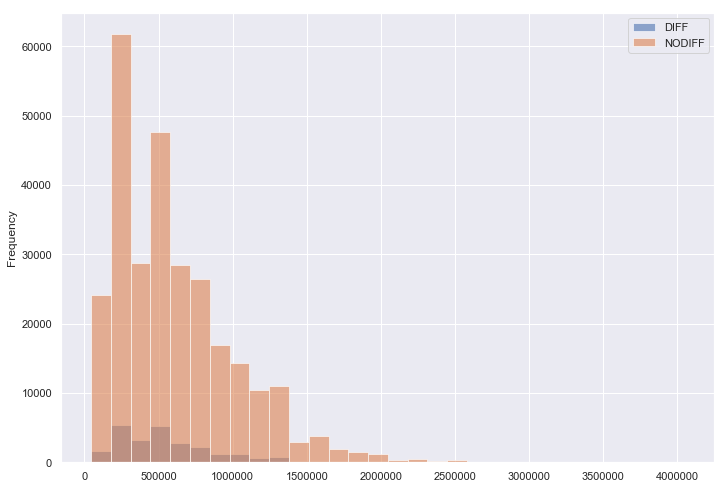

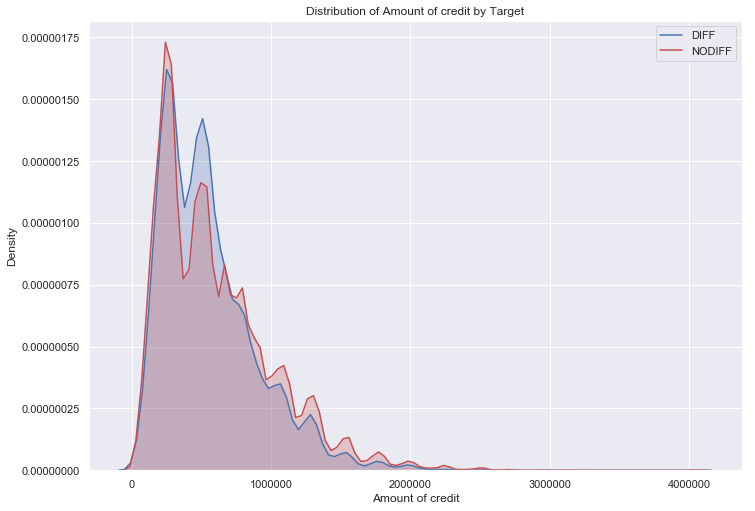

In [45]:
diff_AMT_CREDIT = application_train[(application_train.TARGET == 1) & (application_train.AMT_CREDIT.notnull())].AMT_CREDIT
nodiff_AMT_CREDIT = application_train[(application_train.TARGET == 0) & (application_train.AMT_CREDIT.notnull())].AMT_CREDIT

pd.DataFrame(
{'DIFF': diff_AMT_CREDIT,
 'NODIFF': nodiff_AMT_CREDIT},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 30,alpha=0.6)
plt.show()


plt.subplot(1, 1, 1)
sns.kdeplot(diff_AMT_CREDIT,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_AMT_CREDIT, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of Amount of credit by Target')
plt.xlabel('Amount of credit'); 
plt.ylabel('Density');

#### DAYS_BIRTH
Client's age in days at the time of application

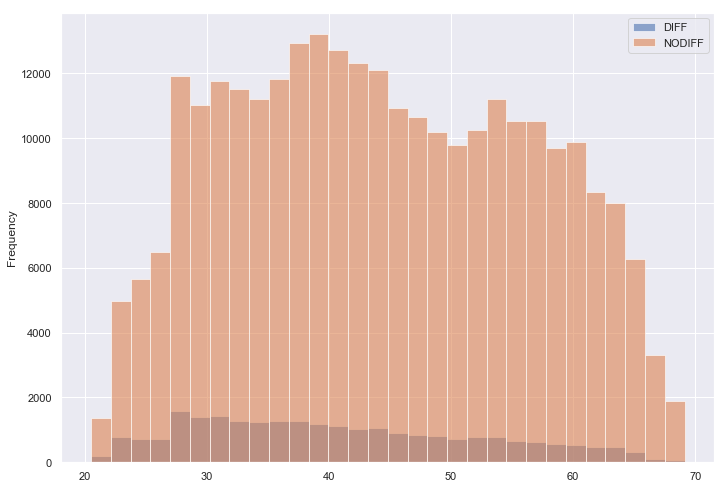

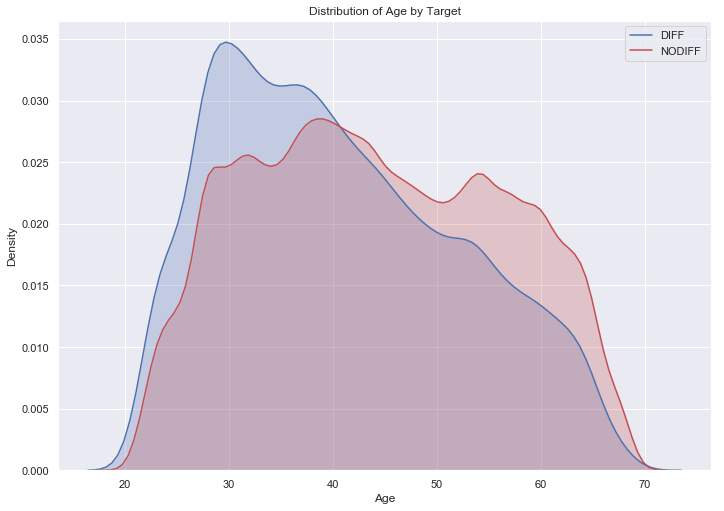

In [46]:
diff_DAYS_BIRTH = (application_train[application_train.TARGET == 1].DAYS_BIRTH/-365)
nodiff_DAYS_BIRTH = (application_train[application_train.TARGET == 0].DAYS_BIRTH/-365)

pd.DataFrame(
{'DIFF': diff_DAYS_BIRTH,
 'NODIFF': nodiff_DAYS_BIRTH},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 30,alpha=0.6)
plt.show()


plt.subplot(1, 1, 1)
sns.kdeplot(diff_DAYS_BIRTH,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_DAYS_BIRTH, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of Age by Target')
plt.xlabel('Age'); 
plt.ylabel('Density');

Younger people relatively have more difficulties

#### DAYS_EMPLOYED
How many days before the application the person started current employment

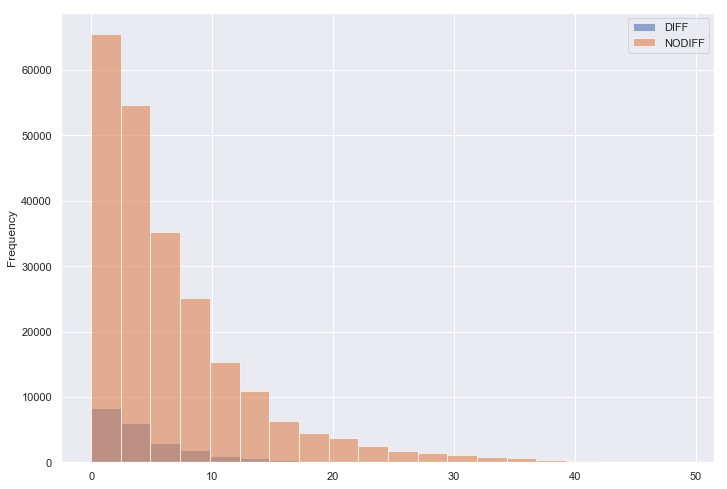

In [47]:
diff_DAYS_EMPLOYED = application_train[(application_train.TARGET == 1) & (application_train.DAYS_EMPLOYED.notnull())].DAYS_EMPLOYED/-365
nodiff_DAYS_EMPLOYED = application_train[(application_train.TARGET == 0) & (application_train.DAYS_EMPLOYED.notnull())].DAYS_EMPLOYED/-365

pd.DataFrame(
{'DIFF': diff_DAYS_EMPLOYED,
 'NODIFF': nodiff_DAYS_EMPLOYED},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

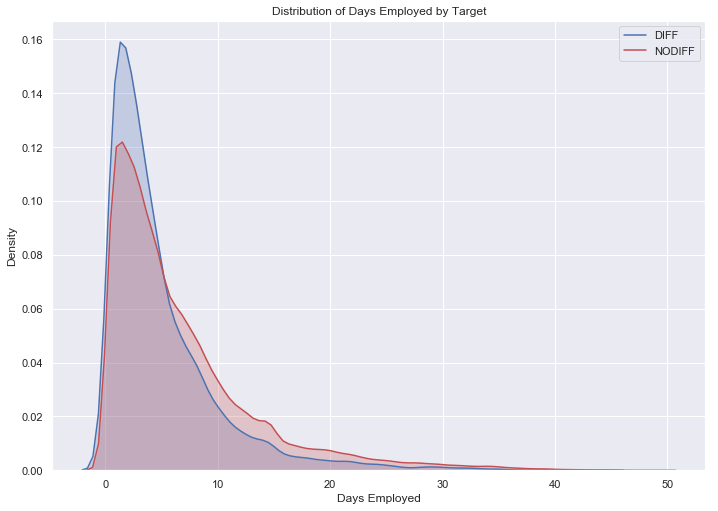

In [48]:
plt.subplot(1, 1, 1)
sns.kdeplot(diff_DAYS_EMPLOYED,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_DAYS_EMPLOYED, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of Days Employed by Target')
plt.xlabel('Days Employed'); 
plt.ylabel('Density');

 #### EXT_SOURCE_{1|2|3}
 Normalized score from external data source

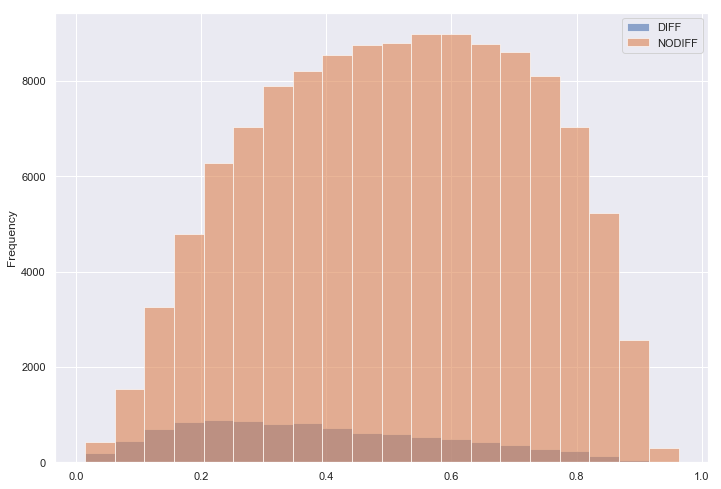

In [49]:
diff_EXT_SOURCE_1 = application_train[(application_train.TARGET == 1) & (application_train.EXT_SOURCE_1.notnull())].EXT_SOURCE_1
nodiff_EXT_SOURCE_1 = application_train[(application_train.TARGET == 0) & (application_train.EXT_SOURCE_1.notnull())].EXT_SOURCE_1


pd.DataFrame(
{'DIFF': diff_EXT_SOURCE_1
,
 'NODIFF': nodiff_EXT_SOURCE_1
},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

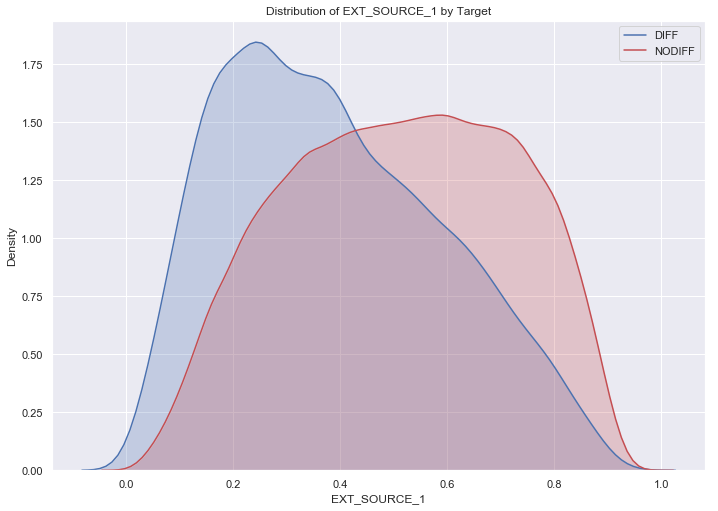

In [50]:
plt.subplot(1, 1, 1)
sns.kdeplot(diff_EXT_SOURCE_1,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_EXT_SOURCE_1, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of EXT_SOURCE_1 by Target')
plt.xlabel('EXT_SOURCE_1'); 
plt.ylabel('Density');

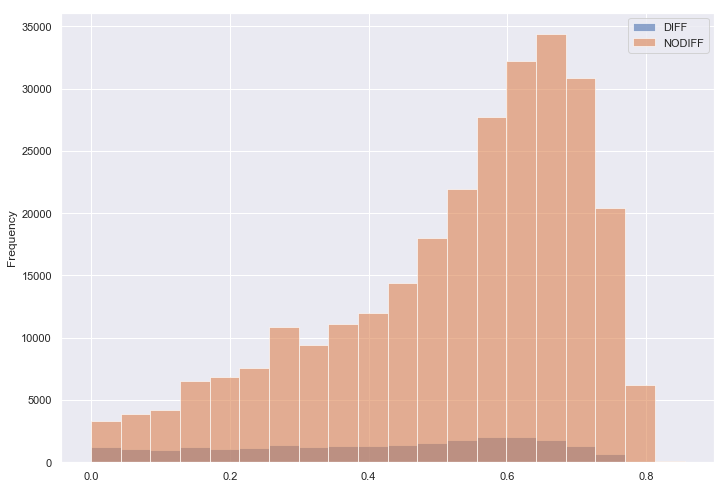

In [51]:
diff_EXT_SOURCE_2 = application_train[(application_train.TARGET == 1) & (application_train.EXT_SOURCE_2.notnull())].EXT_SOURCE_2
nodiff_EXT_SOURCE_2 = application_train[(application_train.TARGET == 0) & (application_train.EXT_SOURCE_2.notnull())].EXT_SOURCE_2


pd.DataFrame(
{'DIFF': diff_EXT_SOURCE_2
,
 'NODIFF': nodiff_EXT_SOURCE_2
},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

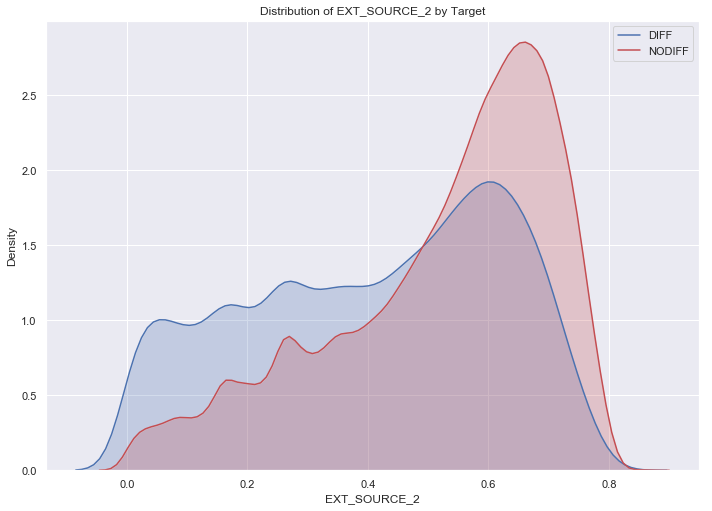

In [52]:
plt.subplot(1, 1, 1)
sns.kdeplot(diff_EXT_SOURCE_2,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_EXT_SOURCE_2, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of EXT_SOURCE_2 by Target')
plt.xlabel('EXT_SOURCE_2'); 
plt.ylabel('Density');

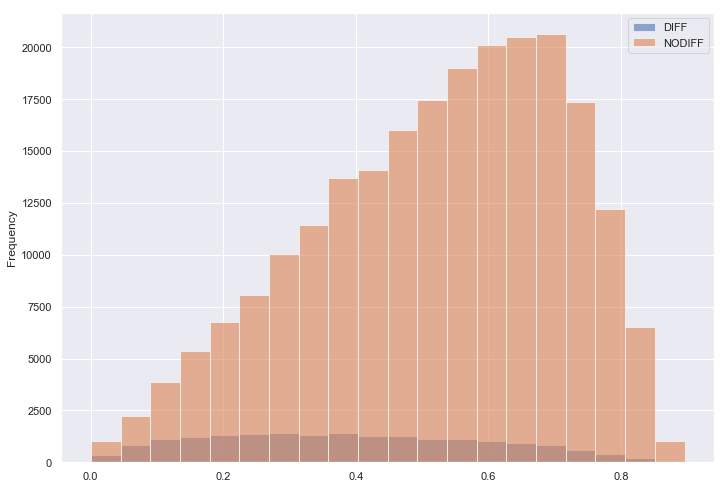

In [53]:
diff_EXT_SOURCE_3 = application_train[(application_train.TARGET == 1) & (application_train.EXT_SOURCE_3.notnull())].EXT_SOURCE_3
nodiff_EXT_SOURCE_3 = application_train[(application_train.TARGET == 0) & (application_train.EXT_SOURCE_3.notnull())].EXT_SOURCE_3
pd.DataFrame(
{'DIFF': diff_EXT_SOURCE_3
,
 'NODIFF': nodiff_EXT_SOURCE_3
},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

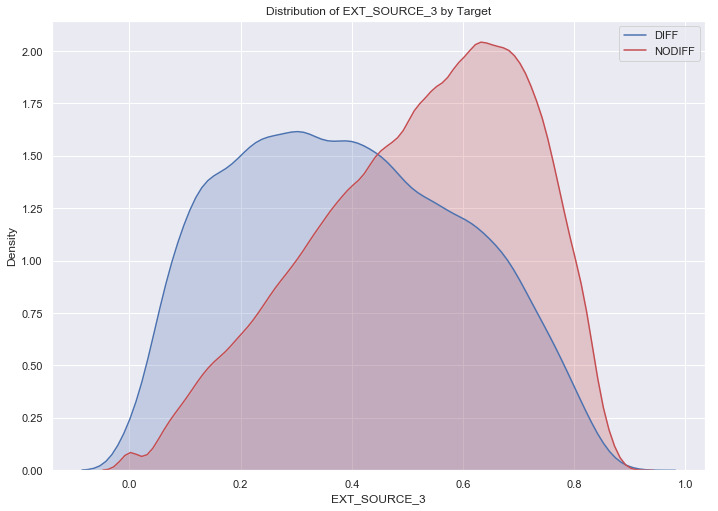

In [54]:
plt.subplot(1, 1, 1)
sns.kdeplot(diff_EXT_SOURCE_3,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_EXT_SOURCE_3, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of EXT_SOURCE_3 by Target')
plt.xlabel('EXT_SOURCE_3'); 
plt.ylabel('Density');

Lower scores have more difficulties and vice versa.

---

### Data preparation
In this part, we will process our data (encode the categorical features, bin continuous features, deal with nulls.. etc)
We will focus on the following features: 
*AMT_INCOME_TOTAL,
AMT_CREDIT,
AMT_ANNUITY,
DAYS_BIRTH,
DAYS_EMPLOYED,
CNT_FAM_MEMBERS,
DAYS_LAST_PHONE_CHANGE,
OWN_CAR_AGE,

EXT_SOURCE_{1|2|3},
REGION_RATING_CLIENT,
REGION_RATING_CLIENT_W_CITY,
LIVE_REGION_NOT_WORK_REGION,
REG_CITY_NOT_LIVE_CITY,
REG_CITY_NOT_WORK_CITY,
LIVE_CITY_NOT_WORK_CITY,

NAME_CONTRACT_TYPE,
CODE_GENDER,
FLAG_OWN_CAR,
FLAG_OWN_REALTY,
NAME_TYPE_SUITE,
NAME_INCOME_TYPE,
NAME_EDUCATION_TYPE,
NAME_FAMILY_STATUS,
NAME_HOUSING_TYPE,
OCCUPATION_TYPE,
ORGANIZATION_TYPE*

In [10]:
categorical_features=[
    'FLAG_OWN_CAR',
    'CODE_GENDER',
    'FLAG_OWN_REALTY',
    'NAME_CONTRACT_TYPE',
    'NAME_TYPE_SUITE',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE',
    'REG_CITY_NOT_LIVE_CITY',
    'REG_CITY_NOT_WORK_CITY',
    'LIVE_CITY_NOT_WORK_CITY',
    'REGION_RATING_CLIENT',
    'REGION_RATING_CLIENT_W_CITY'
]

application_train_proc = application_train[['SK_ID_CURR','TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE','OWN_CAR_AGE'] + categorical_features]

for col in categorical_features:
    application_train_proc.loc[:,col], uniques = pd.factorize(application_train_proc[col])

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [11]:
application_train_proc.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,OWN_CAR_AGE,FLAG_OWN_CAR,CODE_GENDER,FLAG_OWN_REALTY,NAME_CONTRACT_TYPE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY
0,100002,1,202500.0,406597.5,24700.5,-9461,-637.0,1.0,0.083008,0.262939,0.139404,-1134.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100003,0,270000.0,1293502.5,35698.5,-16765,-1188.0,2.0,0.311279,0.622070,NaN,-828.0,NaN,0,1,1,0,1,1,1,1,0,1,1,0,0,0,1,1
2,100004,0,67500.0,135000.0,6750.0,-19046,-225.0,1.0,NaN,0.556152,0.729492,-815.0,26.0,1,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0
3,100006,0,135000.0,312682.5,29686.5,-19005,-3039.0,2.0,NaN,0.650391,NaN,-617.0,NaN,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0
4,100007,0,121500.0,513000.0,21865.5,-19932,-3038.0,1.0,NaN,0.322754,NaN,-1106.0,NaN,0,0,0,0,0,0,0,0,0,1,3,0,1,1,0,0


### Correlation map

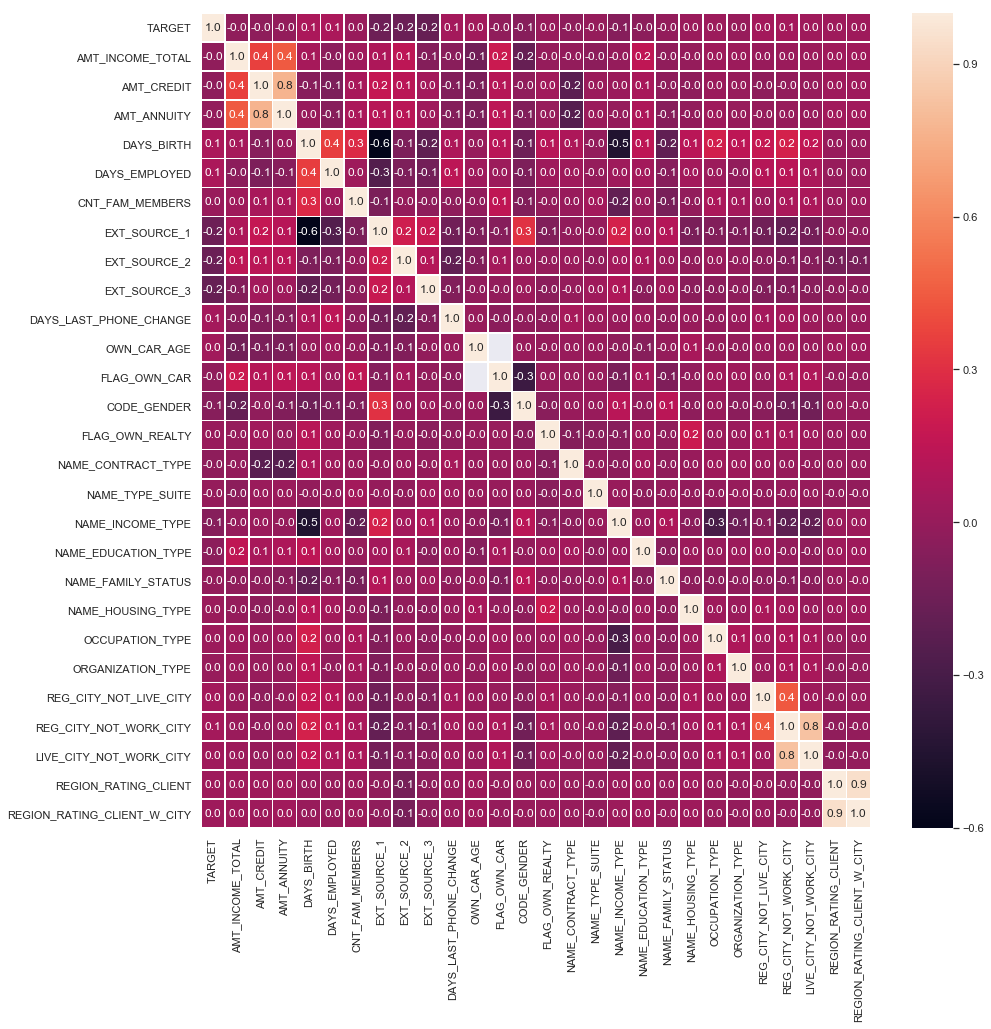

In [13]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(application_train_proc.drop(columns=['SK_ID_CURR']).corr(), annot=True, linewidths=.7, fmt= '.1f',ax=ax)
plt.show()

---

# Predictive model using Application table 
We will use features from the *'application'* table only to predict probabilities of credit default risk with the help of LightGBM.

## Using simple features
In this part, we will only use simple features for our predictions.

### Defining our model and usefull functions
In this section, we will define functions that will help us use the LightGBM model as well as plot some relative graphs

In [12]:
n_folds = 5

params ={
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'learning_rate': 0.005,
    'num_leaves': 52,
    'max_depth': 12,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.45,
    'reg_lambda': 0.48,
    'colsample_bytree': 0.5,
    'min_split_gain': 0.025,
    'subsample': 1
}

In [13]:
def plot_roc_auc(fpr,tpr,roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def plot_feat_importance(feat_importance_df,size=(8,10)):
    cols = feat_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:100].index
    best_features = feat_importance_df.loc[feat_importance_df.feature.isin(cols)]
    plt.figure(figsize=size)
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM feature importance (avg over folds)')
    

def lightgbm_model(df_train,categorical_feat,rounds=100):
    folds = StratifiedKFold(n_splits= n_folds, shuffle=True, random_state= 666)

    # Spliting training data into features/labels 
    app_train_proc_feat, app_train_proc_lbl = df_train.loc[:,df_train.columns != 'TARGET'], df_train.loc[:,'TARGET']

    avg_score = 0
    fprs = []
    tprs = []
    roc_aucs = []
    importance_df = pd.DataFrame()
    
    for n_fold, (train_idx, cv_idx) in enumerate(folds.split(app_train_proc_feat, app_train_proc_lbl)):
        # Train data
        train_feats = app_train_proc_feat.iloc[train_idx]
        train_lbls = app_train_proc_lbl.iloc[train_idx]

        # Cross-validation data
        cv_feats = app_train_proc_feat.iloc[cv_idx]
        cv_lbls = app_train_proc_lbl.iloc[cv_idx]
        
        # Features
        feats = app_train_proc_feat.columns

        # LightGBM classifier
        lgbm = LGBMClassifier(**params)

        start = time.time()
        # Fitting the model
        lgbm.fit(train_feats, train_lbls, eval_set=[(train_feats, train_lbls), (cv_feats, cv_lbls)],
                        eval_metric='auc', verbose=400, early_stopping_rounds=rounds,
                        feature_name=list(feats), categorical_feature=categorical_feat)
        end = time.time()

        # Testing the model on the CV data
        preds = lgbm.predict_proba(cv_feats, num_iteration=lgbm.best_iteration_)[:, 1]

        # Scores
        roc_auc = roc_auc_score(cv_lbls, preds)
        fpr, tpr, threshold = roc_curve(cv_lbls, preds)
        
        fprs.append(fpr)
        tprs.append(tpr)
        roc_aucs.append(roc_auc)

        avg_score += (roc_auc/n_folds)
        
        # Feature importance
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = feats
        fold_importance["importance"] = lgbm.feature_importances_
        importance_df = pd.concat([importance_df, fold_importance], axis=0)
        

        print('Training time: %.2f seconds' % (end-start))
        print('Fold %2d AUC : %.6f' % (n_fold, roc_auc))

        del lgbm, train_feats, train_lbls, cv_feats, cv_lbls, fold_importance
        gc.collect()


    print('Average score on folds: %.6f' % avg_score)
    
    return avg_score, fprs, tprs, roc_aucs, importance_df



In [16]:
avg_score, fprs, tprs, roc_aucs, feat_importance = lightgbm_model(application_train_proc.drop(columns=['SK_ID_CURR']),categorical_features,100)

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.765046	training's binary_logloss: 0.24887	valid_1's auc: 0.74945	valid_1's binary_logloss: 0.252163
[800]	training's auc: 0.778352	training's binary_logloss: 0.241769	valid_1's auc: 0.753009	valid_1's binary_logloss: 0.248306
[1200]	training's auc: 0.789791	training's binary_logloss: 0.237576	valid_1's auc: 0.754761	valid_1's binary_logloss: 0.247275
[1600]	training's auc: 0.80031	training's binary_logloss: 0.234122	valid_1's auc: 0.755629	valid_1's binary_logloss: 0.246872
[2000]	training's auc: 0.810064	training's binary_logloss: 0.231039	valid_1's auc: 0.756063	valid_1's binary_logloss: 0.24669
Early stopping, best iteration is:
[2087]	training's auc: 0.812024	training's binary_logloss: 0.230412	valid_1's auc: 0.756109	valid_1's binary_logloss: 0.246661
Training time: 109.57 seconds
Fold  0 AUC : 0.756109


/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.766431	training's binary_logloss: 0.248357	valid_1's auc: 0.74232	valid_1's binary_logloss: 0.253677
[800]	training's auc: 0.77956	training's binary_logloss: 0.241178	valid_1's auc: 0.746398	valid_1's binary_logloss: 0.250225
[1200]	training's auc: 0.790909	training's binary_logloss: 0.236993	valid_1's auc: 0.74818	valid_1's binary_logloss: 0.249376
[1600]	training's auc: 0.801355	training's binary_logloss: 0.233559	valid_1's auc: 0.748948	valid_1's binary_logloss: 0.249092
[2000]	training's auc: 0.810936	training's binary_logloss: 0.230489	valid_1's auc: 0.749382	valid_1's binary_logloss: 0.24896
[2400]	training's auc: 0.819709	training's binary_logloss: 0.227683	valid_1's auc: 0.749608	valid_1's binary_logloss: 0.248893
Early stopping, best iteration is:
[2589]	training's auc: 0.823672	training's binary_logloss: 0.2264	valid_1's auc: 0.749669	valid_1's binary_logloss: 0.248879
Training time: 145.57

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.764778	training's binary_logloss: 0.248901	valid_1's auc: 0.751104	valid_1's binary_logloss: 0.25202
[800]	training's auc: 0.777823	training's binary_logloss: 0.241814	valid_1's auc: 0.754352	valid_1's binary_logloss: 0.248166
[1200]	training's auc: 0.789021	training's binary_logloss: 0.237694	valid_1's auc: 0.755926	valid_1's binary_logloss: 0.247165
[1600]	training's auc: 0.799539	training's binary_logloss: 0.234282	valid_1's auc: 0.757119	valid_1's binary_logloss: 0.246689
[2000]	training's auc: 0.809401	training's binary_logloss: 0.231201	valid_1's auc: 0.757745	valid_1's binary_logloss: 0.246449
[2400]	training's auc: 0.81826	training's binary_logloss: 0.2284	valid_1's auc: 0.758255	valid_1's binary_logloss: 0.246278
[2800]	training's auc: 0.826531	training's binary_logloss: 0.225759	valid_1's auc: 0.758397	valid_1's binary_logloss: 0.246207
Early stopping, best iteration is:
[3062]	training's a

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.765111	training's binary_logloss: 0.248937	valid_1's auc: 0.748627	valid_1's binary_logloss: 0.252189
[800]	training's auc: 0.778434	training's binary_logloss: 0.241814	valid_1's auc: 0.75249	valid_1's binary_logloss: 0.248196
[1200]	training's auc: 0.789738	training's binary_logloss: 0.237661	valid_1's auc: 0.754764	valid_1's binary_logloss: 0.247002
[1600]	training's auc: 0.800176	training's binary_logloss: 0.234266	valid_1's auc: 0.756148	valid_1's binary_logloss: 0.246461
[2000]	training's auc: 0.809908	training's binary_logloss: 0.231187	valid_1's auc: 0.757001	valid_1's binary_logloss: 0.246157
[2400]	training's auc: 0.818761	training's binary_logloss: 0.228369	valid_1's auc: 0.757438	valid_1's binary_logloss: 0.245994
[2800]	training's auc: 0.827194	training's binary_logloss: 0.225694	valid_1's auc: 0.757786	valid_1's binary_logloss: 0.245892
Early stopping, best iteration is:
[2887]	training'

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.766242	training's binary_logloss: 0.248584	valid_1's auc: 0.744109	valid_1's binary_logloss: 0.25311
[800]	training's auc: 0.779219	training's binary_logloss: 0.241474	valid_1's auc: 0.748314	valid_1's binary_logloss: 0.249452
[1200]	training's auc: 0.790538	training's binary_logloss: 0.237319	valid_1's auc: 0.750495	valid_1's binary_logloss: 0.24842
[1600]	training's auc: 0.801088	training's binary_logloss: 0.233854	valid_1's auc: 0.752013	valid_1's binary_logloss: 0.247915
[2000]	training's auc: 0.810751	training's binary_logloss: 0.23076	valid_1's auc: 0.752849	valid_1's binary_logloss: 0.247654
[2400]	training's auc: 0.81967	training's binary_logloss: 0.227951	valid_1's auc: 0.753244	valid_1's binary_logloss: 0.247537
Early stopping, best iteration is:
[2409]	training's auc: 0.819847	training's binary_logloss: 0.227895	valid_1's auc: 0.753267	valid_1's binary_logloss: 0.247532
Training time: 127.

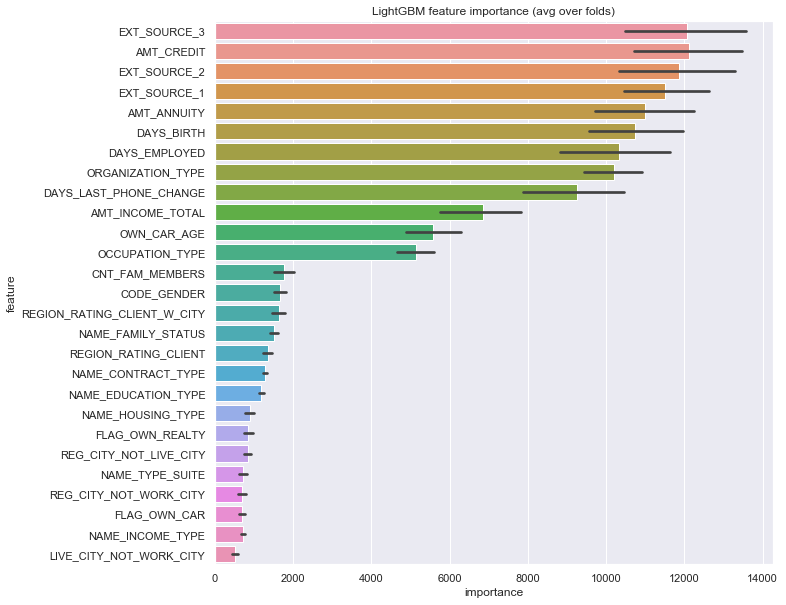

In [26]:
plot_feat_importance(feat_importance, (10,10))

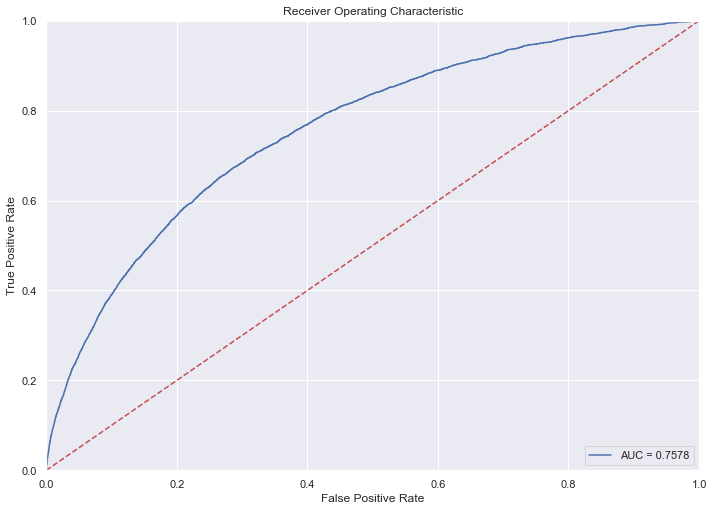

In [18]:
plot_roc_auc(fprs[3], tprs[3],roc_aucs[3])

We get an AUC of about **0.755** using LightGBM and basic features. Next we will try to come up with some engineered features to help improve this score!

## Using engineered features
In this part, we will use simple features as well as engineered features for our predictions

### Document count
A count of the documents provided by the client

In [14]:
docs = [cl for cl in application_train.columns if 'FLAG_DOCUMENT_' in cl]
application_train_proc['DOC_COUNT'] = application_train[docs].replace(np.nan,0).sum(axis=1)

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [15]:
corr = application_train_proc['TARGET'].corr(application_train_proc['DOC_COUNT'])
print('Document count correlation: %.4f' % corr)

Document count correlation: 0.0172


### External sources product cube root
The cube root of the EXT_SOURCES_{1|2|3} product

In [16]:
application_train_proc['EXT_SOURCES_PROD_CBRT'] = (application_train_proc['EXT_SOURCE_1']*application_train_proc['EXT_SOURCE_2']*application_train_proc['EXT_SOURCE_3'])**(1/3)

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [17]:
corr = application_train_proc['TARGET'].corr(application_train_proc['EXT_SOURCES_PROD_CBRT'])
print('External sources product cube root correlation: %.4f' % corr)

External sources product cube root correlation: -0.2326


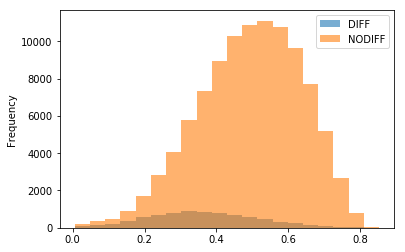

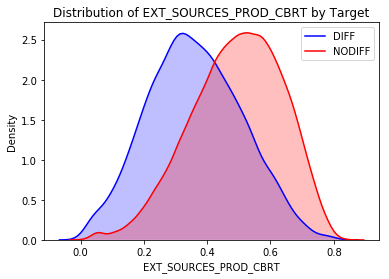

In [18]:
diff_EXT_SOURCES_PROD_CBRT = application_train_proc[(application_train_proc.TARGET == 1) & (application_train_proc.EXT_SOURCES_PROD_CBRT.notnull())].EXT_SOURCES_PROD_CBRT
nodiff_EXT_SOURCES_PROD_CBRT = application_train_proc[(application_train_proc.TARGET == 0) & (application_train_proc.EXT_SOURCES_PROD_CBRT.notnull())].EXT_SOURCES_PROD_CBRT


pd.DataFrame(
{'DIFF': diff_EXT_SOURCES_PROD_CBRT
,
 'NODIFF': nodiff_EXT_SOURCES_PROD_CBRT
},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

plt.subplot(1, 1, 1)
sns.kdeplot(diff_EXT_SOURCES_PROD_CBRT,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_EXT_SOURCES_PROD_CBRT, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of EXT_SOURCES_PROD_CBRT by Target')
plt.xlabel('EXT_SOURCES_PROD_CBRT'); 
plt.ylabel('Density');

### External sources statistics
Min, Max, Mean, Median and Variance of EXT_SOURCES_{1|2|3}

In [19]:
for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
    feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
    application_train_proc[feature_name] = eval('np.{}'.format(function_name))(
        application_train_proc[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\mbouqsimi\AppData\Roaming\Python\Python36\site-packages\numpy\lib\function_base.py:3250: RuntimeWarning:

All-NaN slice encountered



In [20]:
for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
    feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
    corr = application_train_proc['TARGET'].corr(application_train_proc[feature_name])
    print('External sources {} correlation: {}'.format(function_name, corr))

External sources min correlation: -0.18525585144644463
External sources max correlation: -0.19686508710276196
External sources mean correlation: -0.22203730597228996
External sources nanmedian correlation: -0.21809763752255745
External sources var correlation: 0.033572795264919984


### Years to pay
Years left to pay off the credit

In [21]:
application_train_proc['YEARS_TO_PAY'] = application_train_proc['AMT_CREDIT'] / application_train_proc['AMT_ANNUITY']

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [22]:
corr = application_train_proc['TARGET'].corr(application_train_proc['YEARS_TO_PAY'])
print('Years to pay correlation: %.4f' % corr)

Years to pay correlation: -0.0321


### Down Payment
The down payment for the loan

In [23]:
application_train_proc['DOWN_PAYMENT'] = application_train['AMT_GOODS_PRICE']-application_train_proc['AMT_CREDIT']

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [24]:
corr = application_train_proc['TARGET'].corr(application_train_proc['DOWN_PAYMENT'])
print('Down Payment correlation: %.4f' % corr)

Down Payment correlation: -0.0342


### Ratios
Ratios of various contiuous features with eachother

In [25]:
application_train_proc['CREDIT_TO_GOODS_RATIO'] = application_train_proc['AMT_CREDIT']/application_train['AMT_GOODS_PRICE']

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [26]:
corr = application_train_proc['TARGET'].corr(application_train_proc['CREDIT_TO_GOODS_RATIO'])
print('Credit To Goods Ratio correlation: %.4f' % corr)

Credit To Goods Ratio correlation: 0.0694


In [27]:
application_train_proc['ANNUITY_TO_INCOME_RATIO'] = application_train_proc['AMT_ANNUITY'] / application_train_proc['AMT_INCOME_TOTAL']

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [28]:
corr = application_train_proc['TARGET'].corr(application_train_proc['ANNUITY_TO_INCOME_RATIO'])
print('Annuity To Income Ratio correlation: %.4f' % corr)

Annuity To Income Ratio correlation: 0.0143


In [29]:
application_train_proc['EMPLOYED_TO_BIRTH_RATIO'] = application_train_proc['DAYS_EMPLOYED'] / application_train_proc['DAYS_BIRTH']

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [30]:
corr = application_train_proc['TARGET'].corr(application_train_proc['EMPLOYED_TO_BIRTH_RATIO'])
print('Employed To Birth Ratio correlation: %.4f' % corr)

Employed To Birth Ratio correlation: -0.0679


In [31]:
application_train_proc['CAR_TO_BIRTH_RATIO'] = application_train['OWN_CAR_AGE'] / application_train_proc['DAYS_BIRTH']

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [32]:
corr = application_train_proc['TARGET'].corr(application_train_proc['CAR_TO_BIRTH_RATIO'])
print('Car To Birth Ratio correlation: %.4f' % corr)

Car To Birth Ratio correlation: -0.0488


In [33]:
application_train_proc['CAR_TO_EMPLOYED_RATIO'] = application_train_proc['OWN_CAR_AGE'] / application_train_proc['DAYS_EMPLOYED']

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [34]:
corr = application_train_proc['TARGET'].corr(application_train_proc['CAR_TO_EMPLOYED_RATIO'])
print('Car To Employed Ratio correlation: %.4f' % corr)

Car To Employed Ratio correlation: -0.0291


## Model fitting with the engineered features
Fitting the LightGBM model using the engineered features

In [46]:
avg_score, fprs, tprs, roc_aucs, feat_importance = lightgbm_model(application_train_proc,categorical_features,100)

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.769604	training's binary_logloss: 0.245225	valid_1's auc: 0.753435	valid_1's binary_logloss: 0.249224
[800]	training's auc: 0.790223	training's binary_logloss: 0.237388	valid_1's auc: 0.761896	valid_1's binary_logloss: 0.245395
[1200]	training's auc: 0.805442	training's binary_logloss: 0.232322	valid_1's auc: 0.765357	valid_1's binary_logloss: 0.244177
[1600]	training's auc: 0.818224	training's binary_logloss: 0.22816	valid_1's auc: 0.766541	valid_1's binary_logloss: 0.243739
[2000]	training's auc: 0.829695	training's binary_logloss: 0.224439	valid_1's auc: 0.767031	valid_1's binary_logloss: 0.243549
Early stopping, best iteration is:
[2036]	training's auc: 0.830653	training's binary_logloss: 0.224122	valid_1's auc: 0.767085	valid_1's binary_logloss: 0.243531
Training time: 114.72 seconds
Fold  0 AUC : 0.767085


/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.770757	training's binary_logloss: 0.244764	valid_1's auc: 0.747747	valid_1's binary_logloss: 0.250822
[800]	training's auc: 0.791544	training's binary_logloss: 0.236853	valid_1's auc: 0.756657	valid_1's binary_logloss: 0.247241
[1200]	training's auc: 0.806961	training's binary_logloss: 0.231712	valid_1's auc: 0.760376	valid_1's binary_logloss: 0.246046
[1600]	training's auc: 0.819653	training's binary_logloss: 0.227577	valid_1's auc: 0.761862	valid_1's binary_logloss: 0.245587
[2000]	training's auc: 0.830737	training's binary_logloss: 0.223879	valid_1's auc: 0.762469	valid_1's binary_logloss: 0.245388
[2400]	training's auc: 0.84102	training's binary_logloss: 0.220433	valid_1's auc: 0.762892	valid_1's binary_logloss: 0.245276
Early stopping, best iteration is:
[2525]	training's auc: 0.843976	training's binary_logloss: 0.219405	valid_1's auc: 0.762961	valid_1's binary_logloss: 0.245258
Training time: 1

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.769358	training's binary_logloss: 0.245276	valid_1's auc: 0.752785	valid_1's binary_logloss: 0.249203
[800]	training's auc: 0.789813	training's binary_logloss: 0.23746	valid_1's auc: 0.761571	valid_1's binary_logloss: 0.245353
[1200]	training's auc: 0.805059	training's binary_logloss: 0.232409	valid_1's auc: 0.765164	valid_1's binary_logloss: 0.244116
[1600]	training's auc: 0.817895	training's binary_logloss: 0.228265	valid_1's auc: 0.766546	valid_1's binary_logloss: 0.243623
[2000]	training's auc: 0.829283	training's binary_logloss: 0.224577	valid_1's auc: 0.767006	valid_1's binary_logloss: 0.243434
[2400]	training's auc: 0.839679	training's binary_logloss: 0.221136	valid_1's auc: 0.767399	valid_1's binary_logloss: 0.24329
[2800]	training's auc: 0.849231	training's binary_logloss: 0.217875	valid_1's auc: 0.767571	valid_1's binary_logloss: 0.243209
Early stopping, best iteration is:
[2845]	training's

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.769403	training's binary_logloss: 0.245409	valid_1's auc: 0.753487	valid_1's binary_logloss: 0.249006
[800]	training's auc: 0.790208	training's binary_logloss: 0.237514	valid_1's auc: 0.762896	valid_1's binary_logloss: 0.244855
[1200]	training's auc: 0.805189	training's binary_logloss: 0.232469	valid_1's auc: 0.767025	valid_1's binary_logloss: 0.243402
[1600]	training's auc: 0.817677	training's binary_logloss: 0.2284	valid_1's auc: 0.768518	valid_1's binary_logloss: 0.242866
[2000]	training's auc: 0.829004	training's binary_logloss: 0.224725	valid_1's auc: 0.769153	valid_1's binary_logloss: 0.242646
[2400]	training's auc: 0.839366	training's binary_logloss: 0.221287	valid_1's auc: 0.76966	valid_1's binary_logloss: 0.242478
[2800]	training's auc: 0.848944	training's binary_logloss: 0.218012	valid_1's auc: 0.770057	valid_1's binary_logloss: 0.24235
[3200]	training's auc: 0.857713	training's binary_logl

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.770299	training's binary_logloss: 0.244915	valid_1's auc: 0.748517	valid_1's binary_logloss: 0.250241
[800]	training's auc: 0.790946	training's binary_logloss: 0.237075	valid_1's auc: 0.75854	valid_1's binary_logloss: 0.246458
[1200]	training's auc: 0.806209	training's binary_logloss: 0.232006	valid_1's auc: 0.762844	valid_1's binary_logloss: 0.245101
[1600]	training's auc: 0.819262	training's binary_logloss: 0.227814	valid_1's auc: 0.764753	valid_1's binary_logloss: 0.244511
[2000]	training's auc: 0.830678	training's binary_logloss: 0.224131	valid_1's auc: 0.7655	valid_1's binary_logloss: 0.244261
[2400]	training's auc: 0.840978	training's binary_logloss: 0.220711	valid_1's auc: 0.765994	valid_1's binary_logloss: 0.244104
[2800]	training's auc: 0.850552	training's binary_logloss: 0.217422	valid_1's auc: 0.766181	valid_1's binary_logloss: 0.244021
[3200]	training's auc: 0.859411	training's binary_log

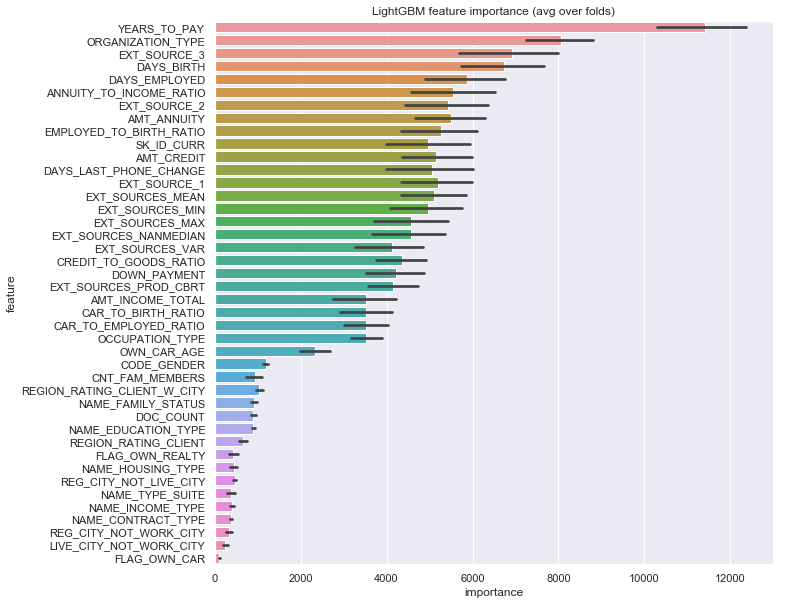

In [47]:
plot_feat_importance(feat_importance,(10,10))

We get an AUC of about **0.767** using the new features. Next we will go through the **'bureau'** table to get more features

---
## Bureau table
In this part, we will explore the features provided by the **'bureau'** table.

In [35]:
del application_train
gc.collect()

7

In [36]:
bureau = reduce_memory(pd.read_csv('./datasets/bureau.csv').rename(index=str, columns={'AMT_ANNUITY': 'AMT_ANNUITY_BUREAU'}))

Initial df memory usage is 235.72 MB for 17 columns
Final memory usage is: 126.04 MB - decreased by 46.5%


In [37]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_BUREAU
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [38]:
bureau['CREDIT_ACTIVE'].value_counts()

Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64

In [39]:
bureau['CREDIT_CURRENCY'].value_counts()

currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: CREDIT_CURRENCY, dtype: int64

In [40]:
bureau['CREDIT_TYPE'].value_counts()

Consumer credit                                 1251615
Credit card                                      402195
Car loan                                          27690
Mortgage                                          18391
Microloan                                         12413
Loan for business development                      1975
Another type of loan                               1017
Unknown type of loan                                555
Loan for working capital replenishment              469
Cash loan (non-earmarked)                            56
Real estate loan                                     27
Loan for the purchase of equipment                   19
Loan for purchase of shares (margin lending)          4
Interbank credit                                      1
Mobile operator loan                                  1
Name: CREDIT_TYPE, dtype: int64

### Feature engineering 
We will use various aggregation to come up with new features from the 'bureau' table

#### Previous bureau credit applications Count
Count of all previous bureau credit applications

In [41]:
prev_buro_app_df = bureau.groupby(['SK_ID_CURR'])['SK_ID_BUREAU'].agg('count').reset_index(name='BURO_APP_CNT')
prev_buro_app_df.head()

,SK_ID_CURR,BURO_APP_CNT
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [42]:
application_train_proc = pd.merge(application_train_proc, prev_buro_app_df, on='SK_ID_CURR', how='left')

In [43]:
del prev_buro_app_df
gc.collect()

35

#### Bad Debt Count
Count of all bad debts

In [44]:
bad_debt_df = bureau[bureau.CREDIT_ACTIVE=='Bad debt'].groupby(['SK_ID_CURR'])['CREDIT_ACTIVE'].agg('count').reset_index(name='BAD_DEBT_CNT')
bad_debt_df.head()

,SK_ID_CURR,BAD_DEBT_CNT
0,158069,1
1,163442,1
2,176952,1
3,186360,1
4,207535,1


In [45]:
application_train_proc = pd.merge(application_train_proc, bad_debt_df, on='SK_ID_CURR', how='left')

In [46]:
del bad_debt_df
gc.collect()

35

#### Closed Credit Count
Count of all credit that is closed

In [47]:
closed_credit_df = bureau[bureau.CREDIT_ACTIVE=='Closed'].groupby(['SK_ID_CURR']).size().reset_index(name='CLOSED_CREDIT_CNT')
closed_credit_df.head()

,SK_ID_CURR,CLOSED_CREDIT_CNT
0,100001,4
1,100002,6
2,100003,3
3,100004,2
4,100005,1


In [48]:
application_train_proc = pd.merge(application_train_proc, closed_credit_df, on='SK_ID_CURR', how='left')

In [49]:
del closed_credit_df
gc.collect()

35

#### Active debt count
Count of all the active debts

In [50]:
active_credit_df = bureau[bureau.CREDIT_ACTIVE=='Active'].groupby(['SK_ID_CURR']).size().reset_index(name='ACTIVE_CREDIT_CNT')
active_credit_df.head()

,SK_ID_CURR,ACTIVE_CREDIT_CNT
0,100001,3
1,100002,2
2,100003,1
3,100005,2
4,100008,1


In [51]:
application_train_proc = pd.merge(application_train_proc, active_credit_df, on='SK_ID_CURR', how='left')

In [52]:
del active_credit_df
gc.collect()

35

#### Sold debt count
Count of all the sold debt

In [53]:
sold_credit_df = bureau[bureau.CREDIT_ACTIVE=='Sold'].groupby(['SK_ID_CURR']).size().reset_index(name='SOLD_CREDIT_CNT')
sold_credit_df.head()

,SK_ID_CURR,SOLD_CREDIT_CNT
0,100039,1
1,100128,1
2,100162,1
3,100170,1
4,100201,1


In [54]:
application_train_proc = pd.merge(application_train_proc, sold_credit_df, on='SK_ID_CURR', how='left')

In [55]:
del sold_credit_df
gc.collect()

35

#### Amount active annuity
Total amount of active credits annuity

In [56]:
amt_annuity_active_df = bureau[bureau.CREDIT_ACTIVE=='Active'].groupby(['SK_ID_CURR']).agg({'AMT_ANNUITY_BUREAU': np.sum}).reset_index().rename(columns={'AMT_ANNUITY_BUREAU': 'AMT_ANNUITY_BUREAU_ACTIVE'}, inplace=False)
amt_annuity_active_df.head()

,SK_ID_CURR,AMT_ANNUITY_BUREAU_ACTIVE
0,100001,24817.5
1,100002,0.0
2,100003,0.0
3,100005,4261.5
4,100008,0.0


In [57]:
application_train_proc = pd.merge(application_train_proc, amt_annuity_active_df, on='SK_ID_CURR', how='left')

In [58]:
del amt_annuity_active_df
gc.collect()

7

#### Currency type count
Count of the different types of currencies in which the credit has been taken

In [59]:
currency_cnt_df = bureau.groupby(['SK_ID_CURR']).agg({'CREDIT_CURRENCY': pd.Series.nunique}).reset_index().rename(columns={'CREDIT_CURRENCY': 'CURRENCY_CNT'}, inplace=False)
currency_cnt_df.head()

,SK_ID_CURR,CURRENCY_CNT
0,100001,1
1,100002,1
2,100003,1
3,100004,1
4,100005,1


In [60]:
application_train_proc = pd.merge(application_train_proc, currency_cnt_df, on='SK_ID_CURR', how='left')

In [61]:
del currency_cnt_df
gc.collect()

49

#### Most recent credit
Days since the last credit

In [62]:
days_most_recent_credit_df = bureau.groupby(['SK_ID_CURR']).agg({'DAYS_CREDIT':np.max}).reset_index().rename(columns={'DAYS_CREDIT': 'DAYS_MOST_RECENT_CREDIT'}, inplace=False)
days_most_recent_credit_df.head()

,SK_ID_CURR,DAYS_MOST_RECENT_CREDIT
0,100001,-49
1,100002,-103
2,100003,-606
3,100004,-408
4,100005,-62


In [63]:
application_train_proc = pd.merge(application_train_proc, days_most_recent_credit_df, on='SK_ID_CURR', how='left')

In [64]:
del days_most_recent_credit_df
gc.collect()

42

#### Credit Duration
Duration of each line of credit

In [65]:
bureau['CREDIT_DURATION'] = bureau['DAYS_CREDIT_ENDDATE']-bureau['DAYS_CREDIT']

#### Debt to credit
Amount of debt to credit

In [66]:
bureau['DEBT_CREDIT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']

#### Credit to annuity ration
Ration of credit amount to annuity payments

In [67]:
bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY_BUREAU']

#### Credit Prolongations
Count of all times credit has been prolonged

In [68]:
credit_prolog_cnt_df = bureau.groupby(['SK_ID_CURR']).agg({'CNT_CREDIT_PROLONG':np.sum}).reset_index().rename(columns={'CNT_CREDIT_PROLONG': 'CREDIT_PROLONG_COUNT'}, inplace=False)
credit_prolog_cnt_df.head()

,SK_ID_CURR,CREDIT_PROLONG_COUNT
0,100001,0
1,100002,0
2,100003,0
3,100004,0
4,100005,0


In [69]:
application_train_proc = pd.merge(application_train_proc, credit_prolog_cnt_df, on='SK_ID_CURR', how='left')

In [70]:
del credit_prolog_cnt_df
gc.collect()

7

#### Aggregations
Aggregations of numeric columns using various funtions

In [71]:
cols_agg = {
        'DAYS_CREDIT': ['min', 'mean', 'std'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean', 'std'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean', 'sum'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean', 'sum'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY_BUREAU': ['max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DURATION': ['min', 'max', 'mean', 'std','sum'],
        'DEBT_CREDIT_PERCENTAGE': ['min', 'max', 'mean', 'std'],
        'DEBT_CREDIT_DIFF': ['min', 'max', 'mean', 'std','sum'],
        'CREDIT_TO_ANNUITY_RATIO': ['min', 'max', 'mean', 'std','sum']
    }

*The following function will allow us to perform a set of aggregations using a dictionnary composed of: columns to aggregate(Keys) and the corresponding aggregation functions(Values)*

In [72]:
def apply_agg(df_to_agg, cols_agg_funcs, group_by_col, prefix=''):
    new_feats = []
    for col, funcs in cols_agg_funcs.items():
        for f in funcs:
            if(prefix):
                col_name = ('{}_{}_{}').format(prefix,col,f.upper())
            else:
                col_name = ('{}_{}').format(col,f.upper())
            new_feats.append(col_name)
            _df = df_to_agg.groupby([group_by_col])[col].agg(f).reset_index(name=col_name)
            df_to_agg = pd.merge(df_to_agg, _df, on=group_by_col, how='left')
            del _df
            gc.collect()
    return df_to_agg, new_feats

In [73]:
bureau, bureau_stat_agg_features = apply_agg(bureau, cols_agg, 'SK_ID_CURR')

In [74]:
appl_train_bureau_proc = reduce_memory(pd.merge(application_train_proc, bureau[['SK_ID_CURR']+bureau_stat_agg_features], on='SK_ID_CURR', how='left'))
del bureau, application_train_proc
gc.collect()

Initial df memory usage is 724.01 MB for 95 columns
Final memory usage is: 405.91 MB - decreased by 43.9%


28

### Preprocessing
In this part we will process the data with the new features before training on it

In [75]:
appl_train_bureau_proc.head(10)

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,OWN_CAR_AGE,FLAG_OWN_CAR,CODE_GENDER,FLAG_OWN_REALTY,NAME_CONTRACT_TYPE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,DOC_COUNT,EXT_SOURCES_PROD_CBRT,EXT_SOURCES_MIN,EXT_SOURCES_MAX,EXT_SOURCES_MEAN,EXT_SOURCES_NANMEDIAN,EXT_SOURCES_VAR,YEARS_TO_PAY,DOWN_PAYMENT,CREDIT_TO_GOODS_RATIO,ANNUITY_TO_INCOME_RATIO,EMPLOYED_TO_BIRTH_RATIO,CAR_TO_BIRTH_RATIO,CAR_TO_EMPLOYED_RATIO,BURO_APP_CNT,BAD_DEBT_CNT,CLOSED_CREDIT_CNT,ACTIVE_CREDIT_CNT,SOLD_CREDIT_CNT,AMT_ANNUITY_BUREAU_ACTIVE,CURRENCY_CNT,DAYS_MOST_RECENT_CREDIT,CREDIT_PROLONG_COUNT,DAYS_CREDIT_MIN,DAYS_CREDIT_MEAN,DAYS_CREDIT_STD,DAYS_CREDIT_ENDDATE_MIN,DAYS_CREDIT_ENDDATE_MAX,DAYS_CREDIT_ENDDATE_MEAN,DAYS_CREDIT_ENDDATE_STD,CREDIT_DAY_OVERDUE_MAX,CREDIT_DAY_OVERDUE_MEAN,CREDIT_DAY_OVERDUE_SUM,AMT_CREDIT_MAX_OVERDUE_MEAN,AMT_CREDIT_MAX_OVERDUE_SUM,AMT_CREDIT_SUM_MAX,AMT_CREDIT_SUM_MEAN,AMT_CREDIT_SUM_SUM,AMT_CREDIT_SUM_DEBT_MAX,AMT_CREDIT_SUM_DEBT_MEAN,AMT_CREDIT_SUM_DEBT_SUM,AMT_CREDIT_SUM_OVERDUE_MEAN,AMT_CREDIT_SUM_LIMIT_MEAN,AMT_CREDIT_SUM_LIMIT_SUM,AMT_ANNUITY_BUREAU_MAX,AMT_ANNUITY_BUREAU_MEAN,DAYS_CREDIT_UPDATE_MEAN,CREDIT_DURATION_MIN,CREDIT_DURATION_MAX,CREDIT_DURATION_MEAN,CREDIT_DURATION_STD,CREDIT_DURATION_SUM,DEBT_CREDIT_PERCENTAGE_MIN,DEBT_CREDIT_PERCENTAGE_MAX,DEBT_CREDIT_PERCENTAGE_MEAN,DEBT_CREDIT_PERCENTAGE_STD,DEBT_CREDIT_DIFF_MIN,DEBT_CREDIT_DIFF_MAX,DEBT_CREDIT_DIFF_MEAN,DEBT_CREDIT_DIFF_STD,DEBT_CREDIT_DIFF_SUM,CREDIT_TO_ANNUITY_RATIO_MIN,CREDIT_TO_ANNUITY_RATIO_MAX,CREDIT_TO_ANNUITY_RATIO_MEAN,CREDIT_TO_ANNUITY_RATIO_STD,CREDIT_TO_ANNUITY_RATIO_SUM
0,100002,1,202500.0,406597.5,24700.5,-9461,-637.0,1.0,0.083008,0.262939,0.139404,-1134.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.14502,0.083008,0.262939,0.161743,0.139404,0.005646,16.46875,-55597.5,1.158203,0.121948,0.067322,NaN,NaN,8.0,NaN,6.0,2.0,NaN,0.0,1.0,-103.0,0.0,-1437.0,-874.0,431.5,-1072.0,780.0,-349.0,inf,0.0,0.0,0.0,1681.029053,8405.144531,450000.0,108131.945312,8.650556e+05,245781.0,49156.199219,245781.0,0.0,7997.141113,31988.564453,0.0,0.0,-500.0,87.0,1822.0,720.0,655.5,4319.0,1.830898,inf,inf,NaN,0.0,204219.0,98388.515625,82354.585938,4.919426e+05,inf,inf,inf,NaN,inf
1,100002,1,202500.0,406597.5,24700.5,-9461,-637.0,1.0,0.083008,0.262939,0.139404,-1134.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.14502,0.083008,0.262939,0.161743,0.139404,0.005646,16.46875,-55597.5,1.158203,0.121948,0.067322,NaN,NaN,8.0,NaN,6.0,2.0,NaN,0.0,1.0,-103.0,0.0,-1437.0,-874.0,431.5,-1072.0,780.0,-349.0,inf,0.0,0.0,0.0,1681.029053,8405.144531,450000.0,108131.945312,8.650556e+05,245781.0,49156.199219,245781.0,0.0,7997.141113,31988.564453,0.0,0.0,-500.0,87.0,1822.0,720.0,655.5,4319.0,1.830898,inf,inf,NaN,0.0,204219.0,98388.515625,82354.585938,4.919426e+05,inf,inf,inf,NaN,inf
2,100002,1,202500.0,406597.5,24700.5,-9461,-637.0,1.0,0.083008,0.262939,0.139404,-1134.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.14502,0.083008,0.262939,0.161743,0.139404,0.005646,16.46875,-55597.5,1.158203,0.121948,0.067322,NaN,NaN,8.0,NaN,6.0,2.0,NaN,0.0,1.0,-103.0,0.0,-1437.0,-874.0,431.5,-1072.0,780.0,-349.0,inf,0.0,0.0,0.0,1681.029053,8405.144531,450000.0,108131.945312,8.650556e+05,245781.0,49156.199219,245781.0,0.0,7997.141113,31988.564453,0.0,0.0,-500.0,87.0,1822.0,720.0,655.5,4319.0,1.830898,inf,inf,NaN,0.0,204219.0,98388.515625,82354.585938,4.919426e+05,inf,inf,inf,NaN,inf
3,100002,1,202500.0,406597.5,24700.5,-9461,-637.0,1.0,0.083008,0.262939,0.139404,-1134.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.14502,0.083008,0.262939,0.161743,0.139404,0.005646,16.46875,-55597.5,1.158203,0.121948,0.067322,NaN,NaN,8.0,NaN,6.0,2.0,NaN,0.0,1.0,-103.0,0.0,-1437.0,-874.0,431.5,-1072.0,780.0,-349.0,inf,0.0,0.0,0.0

In [76]:
appl_train_bureau_proc.fillna({'CLOSED_CREDIT_CNT': 0, 'BAD_DEBT_CNT':0, 'ACTIVE_CREDIT_CNT':0, 'SOLD_CREDIT_CNT':0, 'AMT_CREDIT_SUM_OVERDUE_MEAN': 0, 'AMT_ANNUITY_BUREAU_ACTIVE': 0, 'CURRENCY_CNT': 0, 'DAYS_MOST_RECENT_CREDIT': 0, 'CREDIT_PROLONG_COUNT': 0, 'BURO_APP_CNT': 0}, inplace=True)
appl_train_bureau_proc.replace([np.inf, -np.inf], np.nan, inplace=True)
appl_train_bureau_proc[bureau_stat_agg_features] = appl_train_bureau_proc[bureau_stat_agg_features].replace([np.nan], 0)


In [77]:
appl_train_bureau_proc.drop_duplicates(inplace=True)
appl_train_bureau_proc = appl_train_bureau_proc.sort_values(by=['SK_ID_CURR']).reset_index(drop=True)

In [78]:
del bureau_stat_agg_features
gc.collect()

7

In [79]:
appl_train_bureau_proc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307502 entries, 0 to 307501
Data columns (total 95 columns):
SK_ID_CURR                      307502 non-null int64
TARGET                          307502 non-null int64
AMT_INCOME_TOTAL                307502 non-null float32
AMT_CREDIT                      307502 non-null float32
AMT_ANNUITY                     307490 non-null float32
DAYS_BIRTH                      307502 non-null int64
DAYS_EMPLOYED                   252128 non-null float16
CNT_FAM_MEMBERS                 307502 non-null float16
EXT_SOURCE_1                    134128 non-null float16
EXT_SOURCE_2                    306842 non-null float16
EXT_SOURCE_3                    246540 non-null float16
DAYS_LAST_PHONE_CHANGE          307501 non-null float16
OWN_CAR_AGE                     104578 non-null float16
FLAG_OWN_CAR                    307502 non-null int64
CODE_GENDER                     307502 non-null int64
FLAG_OWN_REALTY                 307502 non-null int64
NAME_

In [80]:
appl_train_bureau_proc.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,OWN_CAR_AGE,FLAG_OWN_CAR,CODE_GENDER,FLAG_OWN_REALTY,NAME_CONTRACT_TYPE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,DOC_COUNT,EXT_SOURCES_PROD_CBRT,EXT_SOURCES_MIN,EXT_SOURCES_MAX,EXT_SOURCES_MEAN,EXT_SOURCES_NANMEDIAN,EXT_SOURCES_VAR,YEARS_TO_PAY,DOWN_PAYMENT,CREDIT_TO_GOODS_RATIO,ANNUITY_TO_INCOME_RATIO,EMPLOYED_TO_BIRTH_RATIO,CAR_TO_BIRTH_RATIO,CAR_TO_EMPLOYED_RATIO,BURO_APP_CNT,BAD_DEBT_CNT,CLOSED_CREDIT_CNT,ACTIVE_CREDIT_CNT,SOLD_CREDIT_CNT,AMT_ANNUITY_BUREAU_ACTIVE,CURRENCY_CNT,DAYS_MOST_RECENT_CREDIT,CREDIT_PROLONG_COUNT,DAYS_CREDIT_MIN,DAYS_CREDIT_MEAN,DAYS_CREDIT_STD,DAYS_CREDIT_ENDDATE_MIN,DAYS_CREDIT_ENDDATE_MAX,DAYS_CREDIT_ENDDATE_MEAN,DAYS_CREDIT_ENDDATE_STD,CREDIT_DAY_OVERDUE_MAX,CREDIT_DAY_OVERDUE_MEAN,CREDIT_DAY_OVERDUE_SUM,AMT_CREDIT_MAX_OVERDUE_MEAN,AMT_CREDIT_MAX_OVERDUE_SUM,AMT_CREDIT_SUM_MAX,AMT_CREDIT_SUM_MEAN,AMT_CREDIT_SUM_SUM,AMT_CREDIT_SUM_DEBT_MAX,AMT_CREDIT_SUM_DEBT_MEAN,AMT_CREDIT_SUM_DEBT_SUM,AMT_CREDIT_SUM_OVERDUE_MEAN,AMT_CREDIT_SUM_LIMIT_MEAN,AMT_CREDIT_SUM_LIMIT_SUM,AMT_ANNUITY_BUREAU_MAX,AMT_ANNUITY_BUREAU_MEAN,DAYS_CREDIT_UPDATE_MEAN,CREDIT_DURATION_MIN,CREDIT_DURATION_MAX,CREDIT_DURATION_MEAN,CREDIT_DURATION_STD,CREDIT_DURATION_SUM,DEBT_CREDIT_PERCENTAGE_MIN,DEBT_CREDIT_PERCENTAGE_MAX,DEBT_CREDIT_PERCENTAGE_MEAN,DEBT_CREDIT_PERCENTAGE_STD,DEBT_CREDIT_DIFF_MIN,DEBT_CREDIT_DIFF_MAX,DEBT_CREDIT_DIFF_MEAN,DEBT_CREDIT_DIFF_STD,DEBT_CREDIT_DIFF_SUM,CREDIT_TO_ANNUITY_RATIO_MIN,CREDIT_TO_ANNUITY_RATIO_MAX,CREDIT_TO_ANNUITY_RATIO_MEAN,CREDIT_TO_ANNUITY_RATIO_STD,CREDIT_TO_ANNUITY_RATIO_SUM
0,100002,1,202500.0,406597.5,24700.5,-9461,-637.0,1.0,0.083008,0.262939,0.139404,-1134.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.14502,0.083008,0.262939,0.161743,0.139404,0.005646,16.46875,-55597.5,1.158203,0.121948,0.067322,NaN,NaN,8.0,0.0,6.0,2.0,0.0,0.0,1.0,-103.0,0.0,-1437.0,-874.0,431.5,-1072.0,780.0,-349.0,0.000,0.0,0.0,0.0,1681.029053,8405.144531,450000.000000,108131.945312,8.650556e+05,245781.0,49156.199219,245781.0,0.0,7997.141113,31988.564453,0.0,0.0,-500.0,87.0,1822.0,720.0,655.5,4319.0,1.830898,0.0,0.0,0.0,0.0,204219.000000,98388.515625,82354.585938,4.919426e+05,0.0,0.0,0.0,0.0,0.0
1,100003,0,270000.0,1293502.5,35698.5,-16765,-1188.0,2.0,0.311279,0.622070,NaN,-828.0,NaN,0,1,1,0,1,1,1,1,0,1,1,0,0,0,1,1,1,NaN,0.311279,0.622070,0.466797,0.466797,0.024155,36.21875,-164002.5,1.145508,0.132202,0.070862,NaN,NaN,4.0,0.0,3.0,1.0,0.0,0.0,1.0,-606.0,0.0,-2586.0,-1401.0,910.0,-2434.0,1216.0,-544.5,0.000,0.0,0.0,0.0,0.000000,0.000000,810000.000000,254350.125000,1.017400e+06,0.0,0.000000,0.0,0.0,202500.000000,810000.000000,0.0,0.0,-816.0,152.0,1822.0,856.0,761.0,3425.0,0.000000,0.0,0.0,0.0,22248.0,810000.000000,254350.125000,372269.468750,1.017400e+06,0.0,0.0,0.0,0.0,0.0
2,100004,0,67500.0,135000.0,6750.0,-19046,-225.0,1.0,NaN,0.556152,0.729492,-815.0,26.0,1,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,NaN,0.556152,0.729492,0.642578,0.642578,0.007511,20.00000,0.0,1.000000,0.099976,0.011810,-0.001365,-0.11554,2.0,0.0,2.0,0.0,0.0,0.0,1.0,-408.0,0.0,-1326.0,-867.0,649.0,-595.0,-382.0,-488.5,150.625,0.0,0.0,0.0,0.000000,0.000000,94537.796875,94518.898438,1.890378e+05,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,-532.0,26.0,731.0,378.5,498.5,757.0,0.000000,0.0,0.0,0.0,94500.0,94537.796875,94518.898438,26.726427,1.890378e+05,0.0,0.0,0.0,0.0,0.0
3,100006,0,135000.0,312682.5,29686.5,-19005,-3040.0,2.0,NaN,0.650391,NaN,-617.0,NaN,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,NaN,0.650391,0.650391,0.650391,0.650391,0.000000,10.53125,-15682.5,1.052734,0.219849,0.159912,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0000

### Training the model
In this part we will train the LightGBM model to see how the new features improve on our previous score.

In [113]:
df_to_model = appl_train_bureau_proc.drop(['SK_ID_CURR'], axis=1, inplace=False)
avg_score, fprs, tprs, roc_aucs, feat_importance = lightgbm_model(df_to_model,categorical_features,100)
del df_to_model
gc.collect()

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.776914	training's binary_logloss: 0.243175	valid_1's auc: 0.756581	valid_1's binary_logloss: 0.248275
[800]	training's auc: 0.800971	training's binary_logloss: 0.233836	valid_1's auc: 0.767283	valid_1's binary_logloss: 0.243738
[1200]	training's auc: 0.817917	training's binary_logloss: 0.227742	valid_1's auc: 0.771101	valid_1's binary_logloss: 0.242301
[1600]	training's auc: 0.832561	training's binary_logloss: 0.222601	valid_1's auc: 0.772917	valid_1's binary_logloss: 0.241649
[2000]	training's auc: 0.845369	training's binary_logloss: 0.218059	valid_1's auc: 0.773859	valid_1's binary_logloss: 0.241313
[2400]	training's auc: 0.856809	training's binary_logloss: 0.213897	valid_1's auc: 0.774295	valid_1's binary_logloss: 0.241138
[2800]	training's auc: 0.867056	training's binary_logloss: 0.210021	valid_1's auc: 0.774577	valid_1's binary_logloss: 0.241037
Early stopping, best iteration is:
[3070]	training

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.777754	training's binary_logloss: 0.242855	valid_1's auc: 0.752037	valid_1's binary_logloss: 0.249666
[800]	training's auc: 0.801661	training's binary_logloss: 0.233473	valid_1's auc: 0.762641	valid_1's binary_logloss: 0.245413
[1200]	training's auc: 0.818935	training's binary_logloss: 0.227263	valid_1's auc: 0.767397	valid_1's binary_logloss: 0.243836
[1600]	training's auc: 0.833175	training's binary_logloss: 0.222193	valid_1's auc: 0.769711	valid_1's binary_logloss: 0.243111
[2000]	training's auc: 0.845642	training's binary_logloss: 0.217698	valid_1's auc: 0.770965	valid_1's binary_logloss: 0.242749
[2400]	training's auc: 0.856824	training's binary_logloss: 0.213603	valid_1's auc: 0.771683	valid_1's binary_logloss: 0.242531
[2800]	training's auc: 0.867052	training's binary_logloss: 0.209747	valid_1's auc: 0.772193	valid_1's binary_logloss: 0.242398
Early stopping, best iteration is:
[2751]	training

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.776658	training's binary_logloss: 0.243333	valid_1's auc: 0.757815	valid_1's binary_logloss: 0.247976
[800]	training's auc: 0.800274	training's binary_logloss: 0.234074	valid_1's auc: 0.768843	valid_1's binary_logloss: 0.24328
[1200]	training's auc: 0.817302	training's binary_logloss: 0.227941	valid_1's auc: 0.773337	valid_1's binary_logloss: 0.241616
[1600]	training's auc: 0.831787	training's binary_logloss: 0.222888	valid_1's auc: 0.775526	valid_1's binary_logloss: 0.240827
[2000]	training's auc: 0.844658	training's binary_logloss: 0.218359	valid_1's auc: 0.776672	valid_1's binary_logloss: 0.240387
[2400]	training's auc: 0.856083	training's binary_logloss: 0.214231	valid_1's auc: 0.777197	valid_1's binary_logloss: 0.240153
[2800]	training's auc: 0.866547	training's binary_logloss: 0.210373	valid_1's auc: 0.777535	valid_1's binary_logloss: 0.239999
[3200]	training's auc: 0.876134	training's binary_l

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.776678	training's binary_logloss: 0.24346	valid_1's auc: 0.759227	valid_1's binary_logloss: 0.24751
[800]	training's auc: 0.800411	training's binary_logloss: 0.234158	valid_1's auc: 0.770106	valid_1's binary_logloss: 0.242637
[1200]	training's auc: 0.817389	training's binary_logloss: 0.228059	valid_1's auc: 0.774602	valid_1's binary_logloss: 0.240924
[1600]	training's auc: 0.83171	training's binary_logloss: 0.22301	valid_1's auc: 0.776933	valid_1's binary_logloss: 0.240094
[2000]	training's auc: 0.844136	training's binary_logloss: 0.218539	valid_1's auc: 0.778096	valid_1's binary_logloss: 0.239676
[2400]	training's auc: 0.855677	training's binary_logloss: 0.214397	valid_1's auc: 0.778885	valid_1's binary_logloss: 0.239395
[2800]	training's auc: 0.865968	training's binary_logloss: 0.21055	valid_1's auc: 0.779453	valid_1's binary_logloss: 0.239234
Early stopping, best iteration is:
[3046]	training's au

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.777538	training's binary_logloss: 0.242919	valid_1's auc: 0.752584	valid_1's binary_logloss: 0.249208
[800]	training's auc: 0.801076	training's binary_logloss: 0.233655	valid_1's auc: 0.763771	valid_1's binary_logloss: 0.244871
[1200]	training's auc: 0.818503	training's binary_logloss: 0.227459	valid_1's auc: 0.768955	valid_1's binary_logloss: 0.243186
[1600]	training's auc: 0.833227	training's binary_logloss: 0.222324	valid_1's auc: 0.771572	valid_1's binary_logloss: 0.242352
[2000]	training's auc: 0.845953	training's binary_logloss: 0.217791	valid_1's auc: 0.77295	valid_1's binary_logloss: 0.241906
[2400]	training's auc: 0.857401	training's binary_logloss: 0.213624	valid_1's auc: 0.773838	valid_1's binary_logloss: 0.241652
[2800]	training's auc: 0.86776	training's binary_logloss: 0.20972	valid_1's auc: 0.774411	valid_1's binary_logloss: 0.241476
[3200]	training's auc: 0.877238	training's binary_log

21

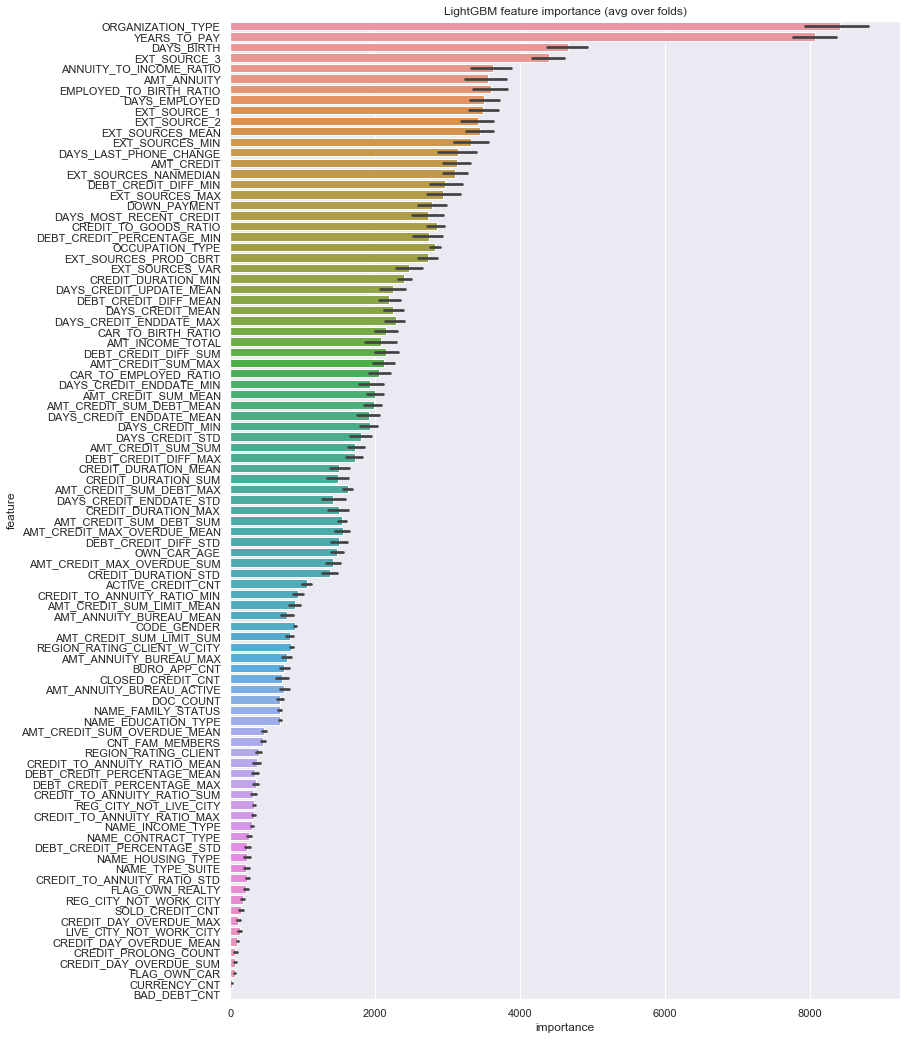

In [125]:
plot_feat_importance(feat_importance, (12,18))

We get an AUC of about **0.776** using the bureau data. We can see that **BAD_DEBT_CNT** and **CURRENCY_CNT** have little importance to our model. Lets test the model without them.

In [126]:
df_to_model = appl_train_bureau_proc.drop(['SK_ID_CURR','BAD_DEBT_CNT','CURRENCY_CNT'], axis=1, inplace=False)
avg_score, fprs, tprs, roc_aucs, feat_importance = lightgbm_model(df_to_model,categorical_features,100)
del df_to_model
gc.collect()

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.777204	training's binary_logloss: 0.243169	valid_1's auc: 0.756814	valid_1's binary_logloss: 0.248264
[800]	training's auc: 0.800706	training's binary_logloss: 0.233909	valid_1's auc: 0.767172	valid_1's binary_logloss: 0.243778
[1200]	training's auc: 0.817834	training's binary_logloss: 0.227785	valid_1's auc: 0.771312	valid_1's binary_logloss: 0.24224
[1600]	training's auc: 0.832624	training's binary_logloss: 0.222635	valid_1's auc: 0.773181	valid_1's binary_logloss: 0.241566
[2000]	training's auc: 0.845454	training's binary_logloss: 0.218114	valid_1's auc: 0.773941	valid_1's binary_logloss: 0.241273
[2400]	training's auc: 0.856801	training's binary_logloss: 0.213947	valid_1's auc: 0.774452	valid_1's binary_logloss: 0.241092
Early stopping, best iteration is:
[2649]	training's auc: 0.863408	training's binary_logloss: 0.211488	valid_1's auc: 0.774669	valid_1's binary_logloss: 0.241008
Training time: 1

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.777888	training's binary_logloss: 0.242834	valid_1's auc: 0.751803	valid_1's binary_logloss: 0.24972
[800]	training's auc: 0.801518	training's binary_logloss: 0.233519	valid_1's auc: 0.762646	valid_1's binary_logloss: 0.245425
[1200]	training's auc: 0.81869	training's binary_logloss: 0.227349	valid_1's auc: 0.767496	valid_1's binary_logloss: 0.243856
[1600]	training's auc: 0.833041	training's binary_logloss: 0.222249	valid_1's auc: 0.769658	valid_1's binary_logloss: 0.243163
[2000]	training's auc: 0.845608	training's binary_logloss: 0.217767	valid_1's auc: 0.770813	valid_1's binary_logloss: 0.242826
[2400]	training's auc: 0.856792	training's binary_logloss: 0.213644	valid_1's auc: 0.771556	valid_1's binary_logloss: 0.242622
[2800]	training's auc: 0.86708	training's binary_logloss: 0.209782	valid_1's auc: 0.771906	valid_1's binary_logloss: 0.242524
[3200]	training's auc: 0.876565	training's binary_log

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.776513	training's binary_logloss: 0.243373	valid_1's auc: 0.758107	valid_1's binary_logloss: 0.247972
[800]	training's auc: 0.799936	training's binary_logloss: 0.234148	valid_1's auc: 0.76897	valid_1's binary_logloss: 0.243246
[1200]	training's auc: 0.816938	training's binary_logloss: 0.228045	valid_1's auc: 0.773518	valid_1's binary_logloss: 0.241556
[1600]	training's auc: 0.831537	training's binary_logloss: 0.222975	valid_1's auc: 0.775901	valid_1's binary_logloss: 0.240729
[2000]	training's auc: 0.844343	training's binary_logloss: 0.218482	valid_1's auc: 0.776896	valid_1's binary_logloss: 0.240354
[2400]	training's auc: 0.855633	training's binary_logloss: 0.214371	valid_1's auc: 0.777753	valid_1's binary_logloss: 0.240038
[2800]	training's auc: 0.865984	training's binary_logloss: 0.210516	valid_1's auc: 0.778256	valid_1's binary_logloss: 0.239855
[3200]	training's auc: 0.875464	training's binary_l

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.776295	training's binary_logloss: 0.243526	valid_1's auc: 0.758847	valid_1's binary_logloss: 0.2476
[800]	training's auc: 0.800128	training's binary_logloss: 0.234255	valid_1's auc: 0.769664	valid_1's binary_logloss: 0.242737
[1200]	training's auc: 0.817096	training's binary_logloss: 0.228151	valid_1's auc: 0.774442	valid_1's binary_logloss: 0.24095
[1600]	training's auc: 0.831566	training's binary_logloss: 0.2231	valid_1's auc: 0.776616	valid_1's binary_logloss: 0.240184
[2000]	training's auc: 0.8443	training's binary_logloss: 0.218608	valid_1's auc: 0.777759	valid_1's binary_logloss: 0.239776
[2400]	training's auc: 0.85561	training's binary_logloss: 0.214508	valid_1's auc: 0.778572	valid_1's binary_logloss: 0.239516
[2800]	training's auc: 0.865887	training's binary_logloss: 0.210634	valid_1's auc: 0.778956	valid_1's binary_logloss: 0.239385
[3200]	training's auc: 0.875174	training's binary_logloss:

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.777544	training's binary_logloss: 0.242963	valid_1's auc: 0.752427	valid_1's binary_logloss: 0.249264
[800]	training's auc: 0.801044	training's binary_logloss: 0.23369	valid_1's auc: 0.764021	valid_1's binary_logloss: 0.244826
[1200]	training's auc: 0.818343	training's binary_logloss: 0.227536	valid_1's auc: 0.769023	valid_1's binary_logloss: 0.243169
[1600]	training's auc: 0.832771	training's binary_logloss: 0.222455	valid_1's auc: 0.771627	valid_1's binary_logloss: 0.242333
[2000]	training's auc: 0.845705	training's binary_logloss: 0.217918	valid_1's auc: 0.772938	valid_1's binary_logloss: 0.241925
[2400]	training's auc: 0.857292	training's binary_logloss: 0.213756	valid_1's auc: 0.773673	valid_1's binary_logloss: 0.241699
[2800]	training's auc: 0.867583	training's binary_logloss: 0.209858	valid_1's auc: 0.774155	valid_1's binary_logloss: 0.241552
[3200]	training's auc: 0.877076	training's binary_l

21

We get the same result without the two features. We will drop them and continue to the next part where we will go through the **'previous_application'** table to get more features.

In [81]:
appl_train_bureau_proc.drop(['BAD_DEBT_CNT','CURRENCY_CNT'], axis=1, inplace=True)

---
## Previous_application table
In this part, we will explore the features provided by the 'previous_application' table.

In [82]:
previous_application = reduce_memory(pd.read_csv('./datasets/previous_application.csv').rename(index=str, columns={'NAME_CONTRACT_TYPE': 'NAME_CONTRACT_TYPE_PREV', 'AMT_ANNUITY': 'AMT_ANNUITY_PREV', 'AMT_CREDIT': 'AMT_CREDIT_PREV', 'AMT_GOODS_PRICE': 'AMT_GOODS_PRICE_PREV', 'AMT_DOWN_PAYMENT': 'AMT_DOWN_PAYMENT_PREV'}))

Initial df memory usage is 484.22 MB for 37 columns
Final memory usage is: 321.75 MB - decreased by 33.6%


In [83]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE_PREV,AMT_ANNUITY_PREV,AMT_APPLICATION,AMT_CREDIT_PREV,AMT_DOWN_PAYMENT_PREV,AMT_GOODS_PRICE_PREV,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182861,0.867188,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
previous_application.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
SK_ID_PREV                     1670214 non-null int32
SK_ID_CURR                     1670214 non-null int32
NAME_CONTRACT_TYPE_PREV        1670214 non-null object
AMT_ANNUITY_PREV               1297979 non-null float32
AMT_APPLICATION                1670214 non-null float32
AMT_CREDIT_PREV                1670213 non-null float32
AMT_DOWN_PAYMENT_PREV          774370 non-null float32
AMT_GOODS_PRICE_PREV           1284699 non-null float32
WEEKDAY_APPR_PROCESS_START     1670214 non-null object
HOUR_APPR_PROCESS_START        1670214 non-null int8
FLAG_LAST_APPL_PER_CONTRACT    1670214 non-null object
NFLAG_LAST_APPL_IN_DAY         1670214 non-null int8
RATE_DOWN_PAYMENT              774370 non-null float16
RATE_INTEREST_PRIMARY          5951 non-null float16
RATE_INTEREST_PRIVILEGED       5951 non-null float16
NAME_CASH_LOAN_PURPOSE         1670214 non-null object
NAME_CONTRACT_STAT

In [85]:
previous_application.select_dtypes(include=['object']).columns

Index(['NAME_CONTRACT_TYPE_PREV', 'WEEKDAY_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON',
       'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY',
       'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE',
       'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION'],
      dtype='object')

In [86]:
previous_application['NAME_CONTRACT_TYPE_PREV'].value_counts()

Cash loans         747553
Consumer loans     729151
Revolving loans    193164
XNA                   346
Name: NAME_CONTRACT_TYPE_PREV, dtype: int64

In [87]:
previous_application['FLAG_LAST_APPL_PER_CONTRACT'].value_counts()

Y    1661739
N       8475
Name: FLAG_LAST_APPL_PER_CONTRACT, dtype: int64

In [88]:
previous_application['NAME_CASH_LOAN_PURPOSE'].value_counts()

XAP                                 922661
XNA                                 677918
Repairs                              23765
Other                                15608
Urgent needs                          8412
Buying a used car                     2888
Building a house or an annex          2693
Everyday expenses                     2416
Medicine                              2174
Payments on other loans               1931
Education                             1573
Journey                               1239
Purchase of electronic equipment      1061
Buying a new car                      1012
Wedding / gift / holiday               962
Buying a home                          865
Car repairs                            797
Furniture                              749
Buying a holiday home / land           533
Business development                   426
Gasification / water supply            300
Buying a garage                        136
Hobby                                   55
Money for a

In [89]:
previous_application['NAME_CONTRACT_STATUS'].value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

In [90]:
previous_application['NAME_PAYMENT_TYPE'].value_counts()

Cash through the bank                        1033552
XNA                                           627384
Non-cash from your account                      8193
Cashless from the account of the employer       1085
Name: NAME_PAYMENT_TYPE, dtype: int64

In [91]:
previous_application['CODE_REJECT_REASON'].value_counts()

XAP       1353093
HC         175231
LIMIT       55680
SCO         37467
CLIENT      26436
SCOFR       12811
XNA          5244
VERIF        3535
SYSTEM        717
Name: CODE_REJECT_REASON, dtype: int64

In [92]:
previous_application['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      508970
Family             213263
Spouse, partner     67069
Children            31566
Other_B             17624
Other_A              9077
Group of people      2240
Name: NAME_TYPE_SUITE, dtype: int64

In [93]:
previous_application['NAME_CLIENT_TYPE'].value_counts()

Repeater     1231261
New           301363
Refreshed     135649
XNA             1941
Name: NAME_CLIENT_TYPE, dtype: int64

In [94]:
previous_application['NAME_GOODS_CATEGORY'].value_counts()

XNA                         950809
Mobile                      224708
Consumer Electronics        121576
Computers                   105769
Audio/Video                  99441
Furniture                    53656
Photo / Cinema Equipment     25021
Construction Materials       24995
Clothing and Accessories     23554
Auto Accessories              7381
Jewelry                       6290
Homewares                     5023
Medical Supplies              3843
Vehicles                      3370
Sport and Leisure             2981
Gardening                     2668
Other                         2554
Office Appliances             2333
Tourism                       1659
Medicine                      1550
Direct Sales                   446
Fitness                        209
Additional Service             128
Education                      107
Weapon                          77
Insurance                       64
House Construction               1
Animals                          1
Name: NAME_GOODS_CAT

In [95]:
previous_application['NAME_PORTFOLIO'].value_counts()

POS      691011
Cash     461563
XNA      372230
Cards    144985
Cars        425
Name: NAME_PORTFOLIO, dtype: int64

In [96]:
previous_application['NAME_PRODUCT_TYPE'].value_counts()

XNA        1063666
x-sell      456287
walk-in     150261
Name: NAME_PRODUCT_TYPE, dtype: int64

In [97]:
previous_application['CHANNEL_TYPE'].value_counts()

Credit and cash offices       719968
Country-wide                  494690
Stone                         212083
Regional / Local              108528
Contact center                 71297
AP+ (Cash loan)                57046
Channel of corporate sales      6150
Car dealer                       452
Name: CHANNEL_TYPE, dtype: int64

In [98]:
previous_application['NAME_SELLER_INDUSTRY'].value_counts()

XNA                     855720
Consumer electronics    398265
Connectivity            276029
Furniture                57849
Construction             29781
Clothing                 23949
Industry                 19194
Auto technology           4990
Jewelry                   2709
MLM partners              1215
Tourism                    513
Name: NAME_SELLER_INDUSTRY, dtype: int64

In [99]:
previous_application['NAME_YIELD_GROUP'].value_counts()

XNA           517215
middle        385532
high          353331
low_normal    322095
low_action     92041
Name: NAME_YIELD_GROUP, dtype: int64

In [100]:
previous_application['PRODUCT_COMBINATION'].value_counts()

Cash                              285990
POS household with interest       263622
POS mobile with interest          220670
Cash X-Sell: middle               143883
Cash X-Sell: low                  130248
Card Street                       112582
POS industry with interest         98833
POS household without interest     82908
Card X-Sell                        80582
Cash Street: high                  59639
Cash X-Sell: high                  59301
Cash Street: middle                34658
Cash Street: low                   33834
POS mobile without interest        24082
POS other with interest            23879
POS industry without interest      12602
POS others without interest         2555
Name: PRODUCT_COMBINATION, dtype: int64

In [101]:
# Replacing the 1000 years values since they are clearly meant to represent a null value
previous_application.replace(365243, np.nan, inplace= True) 

### Feature engineering 
We will engineer features using ratios and various aggregations with data from the **'previous_application'** table

#### Previous application count
Count of all previous loan applications

In [102]:
prev_app_df = previous_application.groupby(['SK_ID_CURR'])['SK_ID_PREV'].agg('count').reset_index(name='PREV_APP_CNT')
prev_app_df.head()

,SK_ID_CURR,PREV_APP_CNT
0,100001.0,1
1,100002.0,1
2,100003.0,3
3,100004.0,1
4,100005.0,2


In [103]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_app_df, on='SK_ID_CURR', how='left')

In [104]:
del prev_app_df
gc.collect()

42

#### Previous approuved application count
Count of all previously approuved applications

In [105]:
prev_apprv_df = previous_application[previous_application['NAME_CONTRACT_STATUS'] == 'Approved'].groupby(['SK_ID_CURR'])['NAME_CONTRACT_STATUS'].agg('count').reset_index(name='CNT_PREV_APPROUVED')
prev_apprv_df.head()

,SK_ID_CURR,CNT_PREV_APPROUVED
0,100001.0,1
1,100002.0,1
2,100003.0,3
3,100004.0,1
4,100005.0,1


In [106]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_apprv_df, on='SK_ID_CURR', how='left')

In [107]:
del prev_apprv_df
gc.collect()

35

#### Previous refused application count
Count of all previously refused applications

In [108]:
prev_ref_df = previous_application[previous_application['NAME_CONTRACT_STATUS'] == 'Refused'].groupby(['SK_ID_CURR'])['NAME_CONTRACT_STATUS'].agg('count').reset_index(name='CNT_PREV_REFUSED')
prev_ref_df.head()

,SK_ID_CURR,CNT_PREV_REFUSED
0,100006.0,1
1,100011.0,1
2,100027.0,1
3,100030.0,10
4,100035.0,8


In [109]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_ref_df, on='SK_ID_CURR', how='left')

In [110]:
del prev_ref_df
gc.collect()

35

#### Previous canceled application count
Count of all previously canceled applications

In [111]:
prev_cancel_df = previous_application[previous_application['NAME_CONTRACT_STATUS'] == 'Canceled'].groupby(['SK_ID_CURR'])['NAME_CONTRACT_STATUS'].agg('count').reset_index(name='CNT_PREV_CANCELED')
prev_cancel_df.head()

,SK_ID_CURR,CNT_PREV_CANCELED
0,100005.0,1
1,100006.0,3
2,100008.0,1
3,100012.0,1
4,100013.0,1


In [112]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_cancel_df, on='SK_ID_CURR', how='left')

In [113]:
del prev_cancel_df
gc.collect()

35

#### Previous unused credit application count
Count of all previously unused credit applications

In [114]:
prev_unused_df = previous_application[previous_application['NAME_CONTRACT_STATUS'] == 'Unused offer'].groupby(['SK_ID_CURR'])['NAME_CONTRACT_STATUS'].agg('count').reset_index(name='CNT_PREV_UNUSED')
prev_unused_df.head()

,SK_ID_CURR,CNT_PREV_UNUSED
0,100028.0,1
1,100057.0,1
2,100061.0,1
3,100086.0,1
4,100092.0,1


In [115]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_unused_df, on='SK_ID_CURR', how='left')

In [116]:
del prev_unused_df
gc.collect()

35

#### Previous cash loan application count
Count of all previous cash loan applications

In [117]:
prev_cash_df = previous_application[previous_application['NAME_PORTFOLIO'] == 'Cash'].groupby(['SK_ID_CURR'])['NAME_PORTFOLIO'].agg('count').reset_index(name='CNT_PREV_CASH_PORTFOLIO')
prev_cash_df.head()

,SK_ID_CURR,CNT_PREV_CASH_PORTFOLIO
0,100003.0,1
1,100006.0,3
2,100007.0,4
3,100008.0,1
4,100011.0,1


In [118]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_cash_df, on='SK_ID_CURR', how='left')

In [119]:
del prev_cash_df
gc.collect()

35

#### Previous POS application count
Count of all previous point of sale loan applications

In [120]:
prev_pos_df = previous_application[previous_application['NAME_PORTFOLIO'] == 'POS'].groupby(['SK_ID_CURR'])['NAME_PORTFOLIO'].agg('count').reset_index(name='CNT_PREV_POS_PORTFOLIO')
prev_pos_df.head()

,SK_ID_CURR,CNT_PREV_POS_PORTFOLIO
0,100001.0,1
1,100002.0,1
2,100003.0,2
3,100004.0,1
4,100005.0,1


In [121]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_pos_df, on='SK_ID_CURR', how='left')

In [122]:
del prev_pos_df
gc.collect()

35

#### Previous XNA type application count
Count of all previous loan applications of type XNA

In [123]:
prev_xna_df = previous_application[previous_application['NAME_PORTFOLIO'] == 'XNA'].groupby(['SK_ID_CURR'])['NAME_PORTFOLIO'].agg('count').reset_index(name='CNT_PREV_XNA_PORTFOLIO')
prev_xna_df.head()

,SK_ID_CURR,CNT_PREV_XNA_PORTFOLIO
0,100005.0,1
1,100006.0,3
2,100008.0,1
3,100011.0,1
4,100012.0,1


In [124]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_xna_df, on='SK_ID_CURR', how='left')

In [125]:
del prev_xna_df
gc.collect()

35

#### Previous Cards type application count
Count of all previous loan applications of type Cards

In [126]:
prev_cards_df = previous_application[previous_application['NAME_PORTFOLIO'] == 'Cards'].groupby(['SK_ID_CURR'])['NAME_PORTFOLIO'].agg('count').reset_index(name='CNT_PREV_CARDS_PORTFOLIO')
prev_cards_df.head()

,SK_ID_CURR,CNT_PREV_CARDS_PORTFOLIO
0,100006.0,1
1,100011.0,1
2,100021.0,1
3,100023.0,1
4,100028.0,1


In [127]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_cards_df, on='SK_ID_CURR', how='left')

In [128]:
del prev_cards_df
gc.collect()

35

#### Previous Cash loans type application count
Count of all previous loan applications of type Cash loans

In [129]:
prev_cash_loan_df = previous_application[previous_application['NAME_CONTRACT_TYPE_PREV'] == 'Cash loans'].groupby(['SK_ID_CURR'])['NAME_CONTRACT_TYPE_PREV'].agg('count').reset_index(name='CNT_PREV_CASH_LOANS')
prev_cash_loan_df.head()

,SK_ID_CURR,CNT_PREV_CASH_LOANS
0,100003.0,1
1,100005.0,1
2,100006.0,5
3,100007.0,4
4,100008.0,2


In [130]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_cash_loan_df, on='SK_ID_CURR', how='left')

In [131]:
del prev_cash_loan_df
gc.collect()

35

#### Previous Consumer loans type application count
Count of all previous loan applications of type Consumer loans

In [132]:
prev_cons_loan_df = previous_application[previous_application['NAME_CONTRACT_TYPE_PREV'] == 'Consumer loans'].groupby(['SK_ID_CURR'])['NAME_CONTRACT_TYPE_PREV'].agg('count').reset_index(name='CNT_PREV_CONSUMER_LOANS')
prev_cons_loan_df.head()

,SK_ID_CURR,CNT_PREV_CONSUMER_LOANS
0,100001.0,1
1,100002.0,1
2,100003.0,2
3,100004.0,1
4,100005.0,1


In [133]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_cons_loan_df, on='SK_ID_CURR', how='left')

In [134]:
del prev_cons_loan_df
gc.collect()

35

#### Previous Revolving loans type application count
Count of all previous loan applications of type Revolving loans

In [135]:
prev_rev_loan_df = previous_application[previous_application['NAME_CONTRACT_TYPE_PREV'] == 'Revolving loans'].groupby(['SK_ID_CURR'])['NAME_CONTRACT_TYPE_PREV'].agg('count').reset_index(name='CNT_PREV_REVOLV_LOANS')
prev_rev_loan_df.head()

,SK_ID_CURR,CNT_PREV_REVOLV_LOANS
0,100006.0,2
1,100011.0,1
2,100021.0,1
3,100023.0,1
4,100028.0,1


In [136]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_rev_loan_df, on='SK_ID_CURR', how='left')

In [137]:
del prev_rev_loan_df
gc.collect()

35

#### Previous XNA yield group type application count
Count of all previous loan applications with the yield group XNA

In [138]:
prev_xna_yield_df = previous_application[previous_application['NAME_YIELD_GROUP'] == 'XNA'].groupby(['SK_ID_CURR'])['NAME_YIELD_GROUP'].agg('count').reset_index(name='CNT_PREV_XNA_YIELD')
prev_xna_yield_df.head()

,SK_ID_CURR,CNT_PREV_XNA_YIELD
0,100005.0,1
1,100006.0,4
2,100008.0,1
3,100011.0,2
4,100012.0,1


In [139]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_xna_yield_df, on='SK_ID_CURR', how='left')

In [140]:
del prev_xna_yield_df
gc.collect()

35

#### Previous Middle yield group type application count
Count of all previous loan applications with the yield group Middle

In [141]:
prev_middle_yield_df = previous_application[previous_application['NAME_YIELD_GROUP'] == 'middle'].groupby(['SK_ID_CURR'])['NAME_YIELD_GROUP'].agg('count').reset_index(name='CNT_PREV_MIDDLE_YIELD')
prev_middle_yield_df.head()

,SK_ID_CURR,CNT_PREV_MIDDLE_YIELD
0,100003.0,2
1,100004.0,1
2,100006.0,1
3,100007.0,3
4,100008.0,1


In [142]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_middle_yield_df, on='SK_ID_CURR', how='left')

In [143]:
del prev_middle_yield_df
gc.collect()

35

#### Previous High yield group type application count
Count of all previous loan applications with the yield group High

In [144]:
prev_high_yield_df = previous_application[previous_application['NAME_YIELD_GROUP'] == 'high'].groupby(['SK_ID_CURR'])['NAME_YIELD_GROUP'].agg('count').reset_index(name='CNT_PREV_HIGH_YIELD')
prev_high_yield_df.head()

,SK_ID_CURR,CNT_PREV_HIGH_YIELD
0,100001.0,1
1,100005.0,1
2,100006.0,2
3,100007.0,3
4,100009.0,2


In [145]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_high_yield_df, on='SK_ID_CURR', how='left')

In [146]:
del prev_high_yield_df
gc.collect()

35

#### Previous Low normal yield group type application count
Count of all previous loan applications with the yield group Low normal

In [147]:
prev_low_normal_df = previous_application[previous_application['NAME_YIELD_GROUP'] == 'low_normal'].groupby(['SK_ID_CURR'])['NAME_YIELD_GROUP'].agg('count').reset_index(name='CNT_PREV_LOW_NORMAL_YIELD')
prev_low_normal_df.head()

,SK_ID_CURR,CNT_PREV_LOW_NORMAL_YIELD
0,100002.0,1
1,100003.0,1
2,100006.0,2
3,100008.0,3
4,100009.0,1


In [148]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_low_normal_df, on='SK_ID_CURR', how='left')

In [149]:
del prev_low_normal_df
gc.collect()

7

#### Previous Low action yield group type application count
Count of all previous loan applications with the yield group Low action

In [150]:
prev_low_action_df = previous_application[previous_application['NAME_YIELD_GROUP'] == 'low_action'].groupby(['SK_ID_CURR'])['NAME_YIELD_GROUP'].agg('count').reset_index(name='CNT_PREV_LOW_ACTION_YIELD')
prev_low_action_df.head()

,SK_ID_CURR,CNT_PREV_LOW_ACTION_YIELD
0,100009.0,1
1,100010.0,1
2,100011.0,1
3,100014.0,1
4,100028.0,1


In [151]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_low_action_df, on='SK_ID_CURR', how='left')

In [152]:
del prev_low_action_df
gc.collect()

7

#### Previous application's client type Refreshed count
Count of all previous loan applications with the client type Refreshed

In [153]:
prev_cl_type_refresh_df = previous_application[previous_application['NAME_CLIENT_TYPE'] == 'Refreshed'].groupby(['SK_ID_CURR'])['NAME_CLIENT_TYPE'].agg('count').reset_index(name='CNT_PREV_CLIENT_TYPE_REFRESHED')
prev_cl_type_refresh_df.head()

,SK_ID_CURR,CNT_PREV_CLIENT_TYPE_REFRESHED
0,100001.0,1
1,100003.0,2
2,100008.0,1
3,100009.0,1
4,100017.0,1


In [154]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_cl_type_refresh_df, on='SK_ID_CURR', how='left')

In [155]:
del prev_cl_type_refresh_df
gc.collect()

7

#### Aggregations
In this part, we will proceed to engineer some ratios and also aggregations using the numerical features of the **'previous_application'** table

In [156]:
previous_application['ASK_GRANTED_RATIO'] = previous_application['AMT_APPLICATION']/previous_application['AMT_CREDIT_PREV']
previous_application['ASK_GRANTED_DIFF'] = previous_application['AMT_APPLICATION']-previous_application['AMT_CREDIT_PREV']
previous_application['YEARS_TO_PAY'] = previous_application['AMT_ANNUITY_PREV']/previous_application['AMT_CREDIT_PREV']
previous_application['CREDIT_TO_GOODS_RATIO_PREV'] = previous_application['AMT_CREDIT_PREV']/previous_application['AMT_GOODS_PRICE_PREV']

In [157]:
prev_cols_agg = {
    'AMT_ANNUITY_PREV': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean', 'sum'],
    'AMT_CREDIT_PREV': ['min', 'max', 'mean', 'sum'],
    'AMT_DOWN_PAYMENT_PREV': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE_PREV': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'RATE_INTEREST_PRIMARY': ['min', 'max', 'mean'],      
    'RATE_INTEREST_PRIVILEGED': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'SELLERPLACE_AREA': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_FIRST_DRAWING': ['min', 'max', 'mean'],
    'DAYS_FIRST_DUE': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE': ['min', 'max', 'mean'],
    'DAYS_TERMINATION': ['min', 'max', 'mean'],
    'NFLAG_INSURED_ON_APPROVAL': ['mean', 'std'],
    'ASK_GRANTED_RATIO': ['min', 'max', 'mean', 'std'],
    'ASK_GRANTED_DIFF': ['min', 'max', 'mean', 'std'],
    'YEARS_TO_PAY': ['min', 'max', 'mean', 'std', 'sum'],
    'CREDIT_TO_GOODS_RATIO_PREV': ['min', 'max', 'mean', 'std']
}

In [158]:
previous_application, prev_stat_features = apply_agg(previous_application, prev_cols_agg, 'SK_ID_CURR', 'PREV')

### Preprocessing
In this part we will process the data with the new features before training on it

In [159]:
appl_train_bureau_proc = reduce_memory(pd.merge(appl_train_bureau_proc, previous_application[['SK_ID_CURR']+prev_stat_features], on='SK_ID_CURR', how='left'))

Initial df memory usage is 1131.98 MB for 180 columns
Final memory usage is: 676.46 MB - decreased by 40.2%


In [160]:
del previous_application
gc.collect()

35

In [161]:
appl_train_bureau_proc.drop_duplicates(inplace=True)
appl_train_bureau_proc = appl_train_bureau_proc.sort_values(by=['SK_ID_CURR']).reset_index(drop=True)

In [162]:
appl_train_bureau_proc.fillna({
    'PREV_APP_CNT': 0,
    'CNT_PREV_APPROUVED': 0,
    'CNT_PREV_REFUSED': 0,
    'CNT_PREV_CANCELED': 0,
    'CNT_PREV_UNUSED': 0,
    'CNT_PREV_POS_PORTFOLIO': 0,
    'CNT_PREV_CASH_PORTFOLIO': 0,
    'CNT_PREV_CARDS_PORTFOLIO': 0,
    'CNT_PREV_CASH_LOANS': 0,
    'CNT_PREV_CONSUMER_LOANS': 0,
    'CNT_PREV_REVOLV_LOANS': 0,
    'CNT_PREV_XNA_YIELD': 0,
    'CNT_PREV_MIDDLE_YIELD': 0,
    'CNT_PREV_HIGH_YIELD': 0,
    'CNT_PREV_LOW_NORMAL_YIELD': 0,
    'CNT_PREV_LOW_ACTION_YIELD': 0,
    'CNT_PREV_CLIENT_TYPE_REFRESHED': 0}, inplace=True)
appl_train_bureau_proc.replace([np.inf, -np.inf], np.nan, inplace=True)

In [163]:
appl_train_bureau_proc.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,OWN_CAR_AGE,FLAG_OWN_CAR,CODE_GENDER,FLAG_OWN_REALTY,NAME_CONTRACT_TYPE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,DOC_COUNT,EXT_SOURCES_PROD_CBRT,EXT_SOURCES_MIN,EXT_SOURCES_MAX,EXT_SOURCES_MEAN,EXT_SOURCES_NANMEDIAN,EXT_SOURCES_VAR,YEARS_TO_PAY,DOWN_PAYMENT,CREDIT_TO_GOODS_RATIO,ANNUITY_TO_INCOME_RATIO,EMPLOYED_TO_BIRTH_RATIO,CAR_TO_BIRTH_RATIO,CAR_TO_EMPLOYED_RATIO,BURO_APP_CNT,CLOSED_CREDIT_CNT,ACTIVE_CREDIT_CNT,SOLD_CREDIT_CNT,AMT_ANNUITY_BUREAU_ACTIVE,DAYS_MOST_RECENT_CREDIT,CREDIT_PROLONG_COUNT,DAYS_CREDIT_MIN,DAYS_CREDIT_MEAN,DAYS_CREDIT_STD,DAYS_CREDIT_ENDDATE_MIN,DAYS_CREDIT_ENDDATE_MAX,DAYS_CREDIT_ENDDATE_MEAN,DAYS_CREDIT_ENDDATE_STD,CREDIT_DAY_OVERDUE_MAX,CREDIT_DAY_OVERDUE_MEAN,CREDIT_DAY_OVERDUE_SUM,AMT_CREDIT_MAX_OVERDUE_MEAN,AMT_CREDIT_MAX_OVERDUE_SUM,AMT_CREDIT_SUM_MAX,AMT_CREDIT_SUM_MEAN,AMT_CREDIT_SUM_SUM,AMT_CREDIT_SUM_DEBT_MAX,AMT_CREDIT_SUM_DEBT_MEAN,AMT_CREDIT_SUM_DEBT_SUM,AMT_CREDIT_SUM_OVERDUE_MEAN,AMT_CREDIT_SUM_LIMIT_MEAN,AMT_CREDIT_SUM_LIMIT_SUM,AMT_ANNUITY_BUREAU_MAX,AMT_ANNUITY_BUREAU_MEAN,DAYS_CREDIT_UPDATE_MEAN,CREDIT_DURATION_MIN,CREDIT_DURATION_MAX,CREDIT_DURATION_MEAN,CREDIT_DURATION_STD,CREDIT_DURATION_SUM,DEBT_CREDIT_PERCENTAGE_MIN,DEBT_CREDIT_PERCENTAGE_MAX,DEBT_CREDIT_PERCENTAGE_MEAN,DEBT_CREDIT_PERCENTAGE_STD,DEBT_CREDIT_DIFF_MIN,DEBT_CREDIT_DIFF_MAX,DEBT_CREDIT_DIFF_MEAN,DEBT_CREDIT_DIFF_STD,DEBT_CREDIT_DIFF_SUM,CREDIT_TO_ANNUITY_RATIO_MIN,CREDIT_TO_ANNUITY_RATIO_MAX,CREDIT_TO_ANNUITY_RATIO_MEAN,CREDIT_TO_ANNUITY_RATIO_STD,CREDIT_TO_ANNUITY_RATIO_SUM,PREV_APP_CNT,CNT_PREV_APPROUVED,CNT_PREV_REFUSED,CNT_PREV_CANCELED,CNT_PREV_UNUSED,CNT_PREV_CASH_PORTFOLIO,CNT_PREV_POS_PORTFOLIO,CNT_PREV_XNA_PORTFOLIO,CNT_PREV_CARDS_PORTFOLIO,CNT_PREV_CASH_LOANS,CNT_PREV_CONSUMER_LOANS,CNT_PREV_REVOLV_LOANS,CNT_PREV_XNA_YIELD,CNT_PREV_MIDDLE_YIELD,CNT_PREV_HIGH_YIELD,CNT_PREV_LOW_NORMAL_YIELD,CNT_PREV_LOW_ACTION_YIELD,CNT_PREV_CLIENT_TYPE_REFRESHED,PREV_AMT_ANNUITY_PREV_MIN,PREV_AMT_ANNUITY_PREV_MAX,PREV_AMT_ANNUITY_PREV_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_SUM,PREV_AMT_CREDIT_PREV_MIN,PREV_AMT_CREDIT_PREV_MAX,PREV_AMT_CREDIT_PREV_MEAN,PREV_AMT_CREDIT_PREV_SUM,PREV_AMT_DOWN_PAYMENT_PREV_MIN,PREV_AMT_DOWN_PAYMENT_PREV_MAX,PREV_AMT_DOWN_PAYMENT_PREV_MEAN,PREV_AMT_GOODS_PRICE_PREV_MIN,PREV_AMT_GOODS_PRICE_PREV_MAX,PREV_AMT_GOODS_PRICE_PREV_MEAN,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_RATE_INTEREST_PRIMARY_MIN,PREV_RATE_INTEREST_PRIMARY_MAX,PREV_RATE_INTEREST_PRIMARY_MEAN,PREV_RATE_INTEREST_PRIVILEGED_MIN,PREV_RATE_INTEREST_PRIVILEGED_MAX,PREV_RATE_INTEREST_PRIVILEGED_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_SELLERPLACE_AREA_MIN,PREV_SELLERPLACE_AREA_MAX,PREV_SELLERPLACE_AREA_MEAN,PREV_CNT_PAYMENT_MIN,PREV_CNT_PAYMENT_MAX,PREV_CNT_PAYMENT_MEAN,PREV_DAYS_FIRST_DRAWING_MIN,PREV_DAYS_FIRST_DRAWING_MAX,PREV_DAYS_FIRST_DRAWING_MEAN,PREV_DAYS_FIRST_DUE_MIN,PREV_DAYS_FIRST_DUE_MAX,PREV_DAYS_FIRST_DUE_MEAN,PREV_DAYS_LAST_DUE_1ST_VERSION_MIN,PREV_DAYS_LAST_DUE_1ST_VERSION_MAX,PREV_DAYS_LAST_DUE_1ST_VERSION_MEAN,PREV_DAYS_LAST_DUE_MIN,PREV_DAYS_LAST_DUE_MAX,PREV_DAYS_LAST_DUE_MEAN,PREV_DAYS_TERMINATION_MIN,PREV_DAYS_TERMINATION_MAX,PREV_DAYS_TERMINATION_MEAN,PREV_NFLAG_INSURED_ON_APPROVAL_MEAN,PREV_NFLAG_INSURED_ON_APPROVAL_STD,PREV_ASK_GRANTED_RATIO_MIN,PREV_ASK_GRANTED_RATIO_MAX,PREV_ASK_GRANTED_RATIO_MEAN,PREV_ASK_GRANTED_RATIO_STD,PREV_ASK_GRANTED_DIFF_MIN,PREV_ASK_GRANTED_DIFF_MAX,PREV_ASK_GRANTED_DIFF_MEAN,PREV_ASK_GRANTED_DIFF_STD,PREV_YEARS_TO_PAY_MIN,PREV_YEARS_TO_PAY_MAX,PREV_YEARS_TO_PAY_MEAN,PREV_YEARS_

### Training the model
In this part we will train the LightGBM model to see how the new features improve on our previous score.

In [137]:
df_to_model = appl_train_bureau_proc.drop(['SK_ID_CURR'], axis=1, inplace=False)
avg_score, fprs, tprs, roc_aucs, feat_importance = lightgbm_model(df_to_model,categorical_features,100)
del df_to_model
gc.collect()

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.787366	training's binary_logloss: 0.240946	valid_1's auc: 0.761051	valid_1's binary_logloss: 0.247162
[800]	training's auc: 0.813899	training's binary_logloss: 0.229927	valid_1's auc: 0.772471	valid_1's binary_logloss: 0.242035
[1200]	training's auc: 0.83272	training's binary_logloss: 0.222501	valid_1's auc: 0.777329	valid_1's binary_logloss: 0.240108
[1600]	training's auc: 0.848408	training's binary_logloss: 0.216391	valid_1's auc: 0.779526	valid_1's binary_logloss: 0.239265
[2000]	training's auc: 0.86222	training's binary_logloss: 0.210971	valid_1's auc: 0.780711	valid_1's binary_logloss: 0.238808
[2400]	training's auc: 0.874849	training's binary_logloss: 0.205989	valid_1's auc: 0.781312	valid_1's binary_logloss: 0.238572
[2800]	training's auc: 0.886129	training's binary_logloss: 0.201352	valid_1's auc: 0.781926	valid_1's binary_logloss: 0.238364
[3200]	training's auc: 0.896448	training's binary_lo

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.787568	training's binary_logloss: 0.240641	valid_1's auc: 0.758519	valid_1's binary_logloss: 0.248354
[800]	training's auc: 0.813982	training's binary_logloss: 0.229632	valid_1's auc: 0.771175	valid_1's binary_logloss: 0.243153
[1200]	training's auc: 0.832967	training's binary_logloss: 0.222194	valid_1's auc: 0.776566	valid_1's binary_logloss: 0.241163
[1600]	training's auc: 0.848819	training's binary_logloss: 0.216061	valid_1's auc: 0.779534	valid_1's binary_logloss: 0.240127
[2000]	training's auc: 0.862618	training's binary_logloss: 0.210643	valid_1's auc: 0.780936	valid_1's binary_logloss: 0.239613
[2400]	training's auc: 0.874846	training's binary_logloss: 0.205704	valid_1's auc: 0.781911	valid_1's binary_logloss: 0.23927
[2800]	training's auc: 0.886038	training's binary_logloss: 0.201119	valid_1's auc: 0.782233	valid_1's binary_logloss: 0.239121
[3200]	training's auc: 0.89597	training's binary_lo

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.786045	training's binary_logloss: 0.241177	valid_1's auc: 0.764738	valid_1's binary_logloss: 0.246762
[800]	training's auc: 0.812487	training's binary_logloss: 0.230266	valid_1's auc: 0.777628	valid_1's binary_logloss: 0.241103
[1200]	training's auc: 0.831426	training's binary_logloss: 0.222908	valid_1's auc: 0.783021	valid_1's binary_logloss: 0.238884
[1600]	training's auc: 0.847421	training's binary_logloss: 0.216785	valid_1's auc: 0.785698	valid_1's binary_logloss: 0.237829
[2000]	training's auc: 0.861494	training's binary_logloss: 0.211356	valid_1's auc: 0.787122	valid_1's binary_logloss: 0.237249
[2400]	training's auc: 0.873916	training's binary_logloss: 0.206428	valid_1's auc: 0.788184	valid_1's binary_logloss: 0.236859
[2800]	training's auc: 0.885152	training's binary_logloss: 0.201841	valid_1's auc: 0.788944	valid_1's binary_logloss: 0.236563
[3200]	training's auc: 0.895133	training's binary_

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.786091	training's binary_logloss: 0.241266	valid_1's auc: 0.765484	valid_1's binary_logloss: 0.246294
[800]	training's auc: 0.812773	training's binary_logloss: 0.230324	valid_1's auc: 0.777345	valid_1's binary_logloss: 0.240756
[1200]	training's auc: 0.831601	training's binary_logloss: 0.222927	valid_1's auc: 0.782861	valid_1's binary_logloss: 0.238515
[1600]	training's auc: 0.847377	training's binary_logloss: 0.2168	valid_1's auc: 0.785535	valid_1's binary_logloss: 0.237426
[2000]	training's auc: 0.861195	training's binary_logloss: 0.211384	valid_1's auc: 0.786984	valid_1's binary_logloss: 0.236843
[2400]	training's auc: 0.873505	training's binary_logloss: 0.206452	valid_1's auc: 0.788121	valid_1's binary_logloss: 0.236439
[2800]	training's auc: 0.884755	training's binary_logloss: 0.201838	valid_1's auc: 0.788774	valid_1's binary_logloss: 0.236198
Early stopping, best iteration is:
[2981]	training's

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.787664	training's binary_logloss: 0.240623	valid_1's auc: 0.7577	valid_1's binary_logloss: 0.248197
[800]	training's auc: 0.814172	training's binary_logloss: 0.229651	valid_1's auc: 0.770219	valid_1's binary_logloss: 0.243109
[1200]	training's auc: 0.832991	training's binary_logloss: 0.222261	valid_1's auc: 0.775852	valid_1's binary_logloss: 0.241121
[1600]	training's auc: 0.84903	training's binary_logloss: 0.216097	valid_1's auc: 0.778959	valid_1's binary_logloss: 0.240075
[2000]	training's auc: 0.862985	training's binary_logloss: 0.210643	valid_1's auc: 0.780772	valid_1's binary_logloss: 0.239456
[2400]	training's auc: 0.875398	training's binary_logloss: 0.205691	valid_1's auc: 0.781712	valid_1's binary_logloss: 0.239148
[2800]	training's auc: 0.886468	training's binary_logloss: 0.201107	valid_1's auc: 0.782269	valid_1's binary_logloss: 0.23894
[3200]	training's auc: 0.896647	training's binary_logl

14

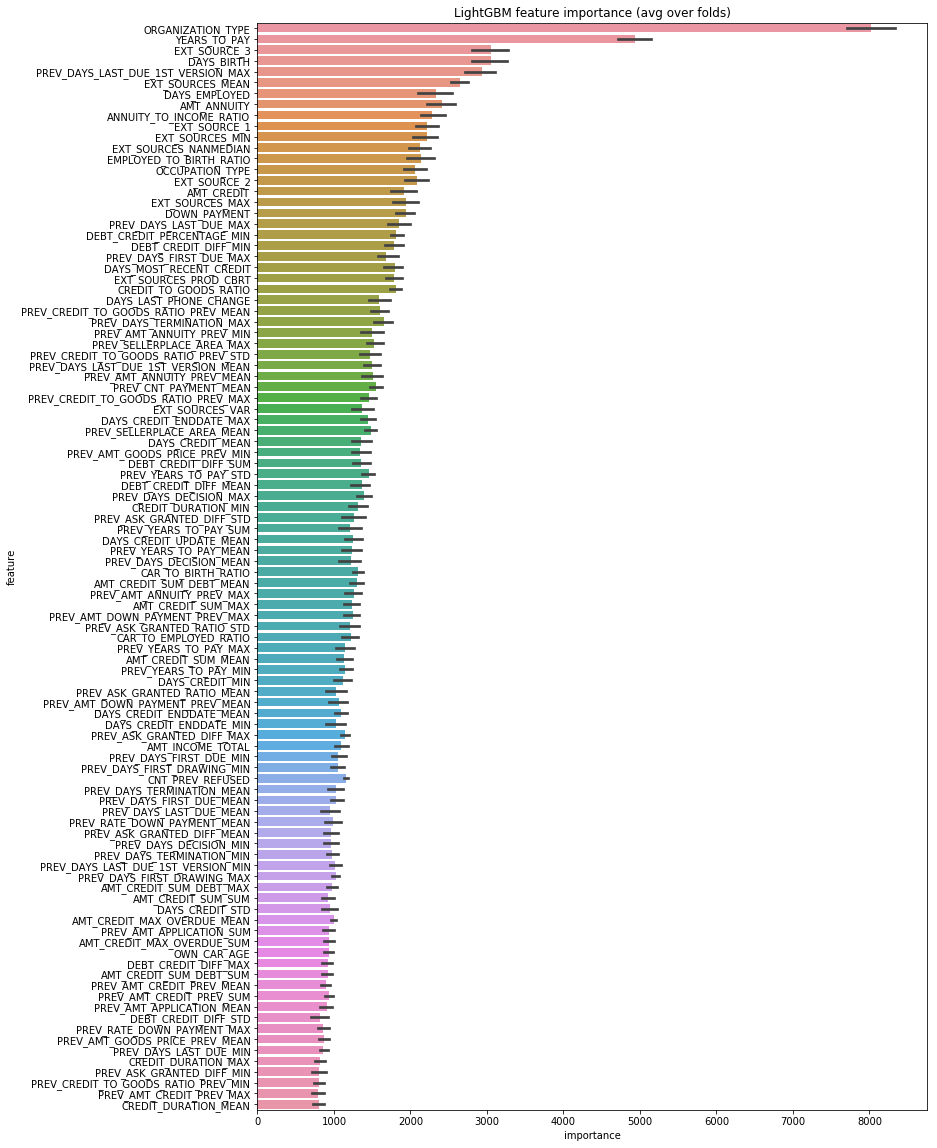

In [142]:
plot_feat_importance(feat_importance, (12,20))

We get a score of **0.785**. Lets try dropping some of the least important features and see how the model does.

In [174]:
feat_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=True).reset_index()[:10]['feature'].tolist()

['PREV_RATE_INTEREST_PRIVILEGED_MEAN',
 'PREV_RATE_INTEREST_PRIVILEGED_MAX',
 'PREV_RATE_INTEREST_PRIMARY_MEAN',
 'PREV_RATE_INTEREST_PRIVILEGED_MIN',
 'CREDIT_DAY_OVERDUE_SUM',
 'CREDIT_PROLONG_COUNT',
 'PREV_RATE_INTEREST_PRIMARY_MIN',
 'FLAG_OWN_CAR',
 'CNT_PREV_UNUSED',
 'PREV_RATE_INTEREST_PRIMARY_MAX']

In [164]:
cols_to_drop = ['PREV_RATE_INTEREST_PRIVILEGED_MEAN',
 'PREV_RATE_INTEREST_PRIVILEGED_MAX',
 'PREV_RATE_INTEREST_PRIMARY_MEAN',
 'PREV_RATE_INTEREST_PRIVILEGED_MIN',
 'CREDIT_DAY_OVERDUE_SUM']

In [148]:
df_to_model = appl_train_bureau_proc.drop(['SK_ID_CURR']+cols_to_drop, axis=1, inplace=False)
avg_score, fprs, tprs, roc_aucs, feat_importance = lightgbm_model(df_to_model,categorical_features,100)
del df_to_model
gc.collect()

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.240958	training's auc: 0.787531	valid_1's binary_logloss: 0.247174	valid_1's auc: 0.761186
[800]	training's binary_logloss: 0.229925	training's auc: 0.814074	valid_1's binary_logloss: 0.242131	valid_1's auc: 0.772207
[1200]	training's binary_logloss: 0.222455	training's auc: 0.832898	valid_1's binary_logloss: 0.240062	valid_1's auc: 0.777565
[1600]	training's binary_logloss: 0.216334	training's auc: 0.848546	valid_1's binary_logloss: 0.239113	valid_1's auc: 0.780145
[2000]	training's binary_logloss: 0.210864	training's auc: 0.862612	valid_1's binary_logloss: 0.238601	valid_1's auc: 0.781552
[2400]	training's binary_logloss: 0.205876	training's auc: 0.875082	valid_1's binary_logloss: 0.238335	valid_1's auc: 0.782295
[2800]	training's binary_logloss: 0.201284	training's auc: 0.886325	valid_1's binary_logloss: 0.238191	valid_1's auc: 0.782666
Early stopping, best iteration is:
[2918]	training

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.240577	training's auc: 0.787827	valid_1's binary_logloss: 0.24828	valid_1's auc: 0.758817
[800]	training's binary_logloss: 0.229603	training's auc: 0.814149	valid_1's binary_logloss: 0.243198	valid_1's auc: 0.77087
[1200]	training's binary_logloss: 0.222128	training's auc: 0.833186	valid_1's binary_logloss: 0.241073	valid_1's auc: 0.776679
[1600]	training's binary_logloss: 0.216016	training's auc: 0.84891	valid_1's binary_logloss: 0.240116	valid_1's auc: 0.7794
[2000]	training's binary_logloss: 0.210617	training's auc: 0.862591	valid_1's binary_logloss: 0.239516	valid_1's auc: 0.781166
[2400]	training's binary_logloss: 0.205675	training's auc: 0.875046	valid_1's binary_logloss: 0.239209	valid_1's auc: 0.782068
[2800]	training's binary_logloss: 0.201121	training's auc: 0.885986	valid_1's binary_logloss: 0.23897	valid_1's auc: 0.782831
[3200]	training's binary_logloss: 0.196865	training's au

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.241196	training's auc: 0.785939	valid_1's binary_logloss: 0.24673	valid_1's auc: 0.764743
[800]	training's binary_logloss: 0.230289	training's auc: 0.812738	valid_1's binary_logloss: 0.241153	valid_1's auc: 0.777379
[1200]	training's binary_logloss: 0.222857	training's auc: 0.831779	valid_1's binary_logloss: 0.238798	valid_1's auc: 0.783415
[1600]	training's binary_logloss: 0.2168	training's auc: 0.847333	valid_1's binary_logloss: 0.237695	valid_1's auc: 0.786199
[2000]	training's binary_logloss: 0.211372	training's auc: 0.861467	valid_1's binary_logloss: 0.237028	valid_1's auc: 0.787953
[2400]	training's binary_logloss: 0.206452	training's auc: 0.873901	valid_1's binary_logloss: 0.236643	valid_1's auc: 0.788921
[2800]	training's binary_logloss: 0.201895	training's auc: 0.885097	valid_1's binary_logloss: 0.236378	valid_1's auc: 0.789616
[3200]	training's binary_logloss: 0.197594	training's

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.241277	training's auc: 0.786261	valid_1's binary_logloss: 0.246346	valid_1's auc: 0.765115
[800]	training's binary_logloss: 0.230396	training's auc: 0.812583	valid_1's binary_logloss: 0.240846	valid_1's auc: 0.776806
[1200]	training's binary_logloss: 0.222927	training's auc: 0.831786	valid_1's binary_logloss: 0.238556	valid_1's auc: 0.782678
[1600]	training's binary_logloss: 0.216803	training's auc: 0.847417	valid_1's binary_logloss: 0.237455	valid_1's auc: 0.785423
[2000]	training's binary_logloss: 0.211388	training's auc: 0.86131	valid_1's binary_logloss: 0.23689	valid_1's auc: 0.786849
[2400]	training's binary_logloss: 0.206442	training's auc: 0.873763	valid_1's binary_logloss: 0.236544	valid_1's auc: 0.787816
[2800]	training's binary_logloss: 0.201875	training's auc: 0.884868	valid_1's binary_logloss: 0.23633	valid_1's auc: 0.788441
[3200]	training's binary_logloss: 0.19756	training's 

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.240663	training's auc: 0.78768	valid_1's binary_logloss: 0.248193	valid_1's auc: 0.757858
[800]	training's binary_logloss: 0.229703	training's auc: 0.814152	valid_1's binary_logloss: 0.243063	valid_1's auc: 0.77053
[1200]	training's binary_logloss: 0.222305	training's auc: 0.83295	valid_1's binary_logloss: 0.240916	valid_1's auc: 0.776552
[1600]	training's binary_logloss: 0.216151	training's auc: 0.848928	valid_1's binary_logloss: 0.239783	valid_1's auc: 0.779872
[2000]	training's binary_logloss: 0.210726	training's auc: 0.862769	valid_1's binary_logloss: 0.239106	valid_1's auc: 0.781935
[2400]	training's binary_logloss: 0.205748	training's auc: 0.875322	valid_1's binary_logloss: 0.23869	valid_1's auc: 0.783112
[2800]	training's binary_logloss: 0.201192	training's auc: 0.886301	valid_1's binary_logloss: 0.238485	valid_1's auc: 0.783682
[3200]	training's binary_logloss: 0.19687	training's a

14

We get the same result without the five least important features. We will drop them and continue to the next part where we will go through the **'credit_card_balance'** table to add more features.

In [165]:
appl_train_bureau_proc.drop(cols_to_drop, axis=1, inplace=True)
del cols_to_drop
gc.collect()

14

In [166]:
appl_train_bureau_proc.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307502 entries, 0 to 307501
Data columns (total 175 columns):
SK_ID_CURR                              int64
TARGET                                  int64
AMT_INCOME_TOTAL                        float32
AMT_CREDIT                              float32
AMT_ANNUITY                             float32
DAYS_BIRTH                              int64
DAYS_EMPLOYED                           float16
CNT_FAM_MEMBERS                         float16
EXT_SOURCE_1                            float16
EXT_SOURCE_2                            float16
EXT_SOURCE_3                            float16
DAYS_LAST_PHONE_CHANGE                  float16
OWN_CAR_AGE                             float16
FLAG_OWN_CAR                            int64
CODE_GENDER                             int64
FLAG_OWN_REALTY                         int64
NAME_CONTRACT_TYPE                      int64
NAME_TYPE_SUITE                         int64
NAME_INCOME_TYPE                        

---
## Credit_card_balance table
In this part, we will explore the features provided by the 'credit_card_balance' table.

In [167]:
credit_card_balance = reduce_memory(pd.read_csv('./datasets/credit_card_balance.csv'))

Initial df memory usage is 673.88 MB for 23 columns
Final memory usage is: 289.33 MB - decreased by 57.1%


In [168]:
credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
SK_ID_PREV                    int32
SK_ID_CURR                    int32
MONTHS_BALANCE                int8
AMT_BALANCE                   float32
AMT_CREDIT_LIMIT_ACTUAL       int32
AMT_DRAWINGS_ATM_CURRENT      float32
AMT_DRAWINGS_CURRENT          float32
AMT_DRAWINGS_OTHER_CURRENT    float32
AMT_DRAWINGS_POS_CURRENT      float32
AMT_INST_MIN_REGULARITY       float32
AMT_PAYMENT_CURRENT           float32
AMT_PAYMENT_TOTAL_CURRENT     float32
AMT_RECEIVABLE_PRINCIPAL      float32
AMT_RECIVABLE                 float32
AMT_TOTAL_RECEIVABLE          float32
CNT_DRAWINGS_ATM_CURRENT      float16
CNT_DRAWINGS_CURRENT          int16
CNT_DRAWINGS_OTHER_CURRENT    float16
CNT_DRAWINGS_POS_CURRENT      float16
CNT_INSTALMENT_MATURE_CUM     float16
NAME_CONTRACT_STATUS          object
SK_DPD                        int16
SK_DPD_DEF                    int16
dtypes: float16(4), float32(1

In [169]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,1800.0,1800.0,0.000000,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,2250.0,2250.0,60175.078125,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,2250.0,2250.0,26926.425781,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,11925.0,11925.0,224949.281250,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,27000.0,27000.0,443044.406250,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [170]:
credit_card_balance['NAME_CONTRACT_STATUS'].value_counts()

Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: NAME_CONTRACT_STATUS, dtype: int64

### Feature engineering 
We will engineer features using ratios and various aggregations with data from the **'credit_card_balance'** table

#### Active contract type count
Count of all active credit card contracts

In [171]:
cnt_card_active_df = credit_card_balance[credit_card_balance['NAME_CONTRACT_STATUS']=='Active'].groupby(['SK_ID_CURR'])['NAME_CONTRACT_STATUS'].agg('count').reset_index(name='CNT_CARD_ACTIVE')
cnt_card_active_df.head()

,SK_ID_CURR,CNT_CARD_ACTIVE
0,100006,6
1,100011,74
2,100013,96
3,100021,7
4,100023,8


In [172]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, cnt_card_active_df, on='SK_ID_CURR', how='left')

In [173]:
del cnt_card_active_df
gc.collect()

14

#### Completed  contract type count
Count of all completed credit card contracts

In [174]:
cnt_card_comp_df = credit_card_balance[credit_card_balance['NAME_CONTRACT_STATUS']=='Completed'].groupby(['SK_ID_CURR'])['NAME_CONTRACT_STATUS'].agg('count').reset_index(name='CNT_CARD_COMPLETED')
cnt_card_comp_df.head()

,SK_ID_CURR,CNT_CARD_COMPLETED
0,100021,10
1,100059,4
2,100109,7
3,100112,3
4,100128,7


In [175]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, cnt_card_comp_df, on='SK_ID_CURR', how='left')

In [176]:
del cnt_card_comp_df
gc.collect()

35

#### Days past due
Creating a flag for days past due

In [177]:
credit_card_balance['PAST_DUE'] = credit_card_balance['SK_DPD'].apply(lambda s : 1 if s>0 else 0)
credit_card_balance['PAST_DUE_TOL'] = credit_card_balance['SK_DPD_DEF'].apply(lambda s : 1 if s>0 else 0)

#### Aggregations
In this part, we will proceed to engineer some ratios and also aggregations using the numerical features of the **'credit_card_balance'** table

In [178]:
appl_train_bureau_proc['CNT_CARD_ACTIVE_COMP_RATIO'] = appl_train_bureau_proc['CNT_CARD_COMPLETED']/appl_train_bureau_proc['CNT_CARD_ACTIVE']
credit_card_balance['AMT_BALANCE_LIMIT_RATIO'] = credit_card_balance['AMT_BALANCE']/credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL']
credit_card_balance['AMT_DRAWING_LIMIT_RATIO'] = credit_card_balance['AMT_DRAWINGS_CURRENT']/credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL']
credit_card_balance['AMT_PAYMENT_MIN_INST_RATIO'] = credit_card_balance['AMT_PAYMENT_CURRENT']/credit_card_balance['AMT_INST_MIN_REGULARITY']
credit_card_balance['AMT_RECEIVABLE_PRINCIPAL_RATIO'] = credit_card_balance['AMT_TOTAL_RECEIVABLE']/credit_card_balance['AMT_RECEIVABLE_PRINCIPAL']

In [179]:
card_cols_agg = {
    'AMT_BALANCE_LIMIT_RATIO': ['min', 'max', 'mean', 'std'],
    'AMT_DRAWING_LIMIT_RATIO': ['min', 'max', 'mean', 'std'],
    'AMT_PAYMENT_MIN_INST_RATIO': ['min', 'max', 'mean', 'std'],
    'AMT_RECEIVABLE_PRINCIPAL_RATIO': ['min', 'max', 'mean', 'std'],
    'PAST_DUE': ['max', 'sum'],
    'PAST_DUE_TOL': ['max', 'sum'],
    'AMT_BALANCE': ['min', 'max', 'mean', 'std'],                
    'AMT_CREDIT_LIMIT_ACTUAL': ['min', 'max', 'mean', 'std'],
    'AMT_DRAWINGS_ATM_CURRENT': ['min', 'max', 'mean', 'std'],      
    'AMT_DRAWINGS_CURRENT': ['min', 'max', 'mean', 'std'],
    'AMT_DRAWINGS_OTHER_CURRENT': ['min', 'max', 'mean', 'std'],
    'AMT_DRAWINGS_POS_CURRENT': ['min', 'max', 'mean', 'std'],
    'AMT_INST_MIN_REGULARITY': ['min', 'max', 'mean', 'std'],
    'AMT_PAYMENT_CURRENT': ['min', 'max', 'mean', 'std'],
    'AMT_PAYMENT_TOTAL_CURRENT': ['min', 'max', 'mean', 'std'],
    'AMT_RECEIVABLE_PRINCIPAL': ['min', 'max', 'mean', 'std'],
    'AMT_RECIVABLE': ['min', 'max', 'mean', 'std'],
    'AMT_TOTAL_RECEIVABLE': ['min', 'max', 'mean', 'std'],
    'CNT_DRAWINGS_ATM_CURRENT': ['min', 'max', 'mean', 'std'],
    'CNT_DRAWINGS_CURRENT': ['min', 'max', 'mean', 'std'],
    'CNT_DRAWINGS_OTHER_CURRENT': ['min', 'max', 'mean', 'std'],
    'CNT_DRAWINGS_POS_CURRENT': ['min', 'max', 'mean', 'std'],
    'CNT_INSTALMENT_MATURE_CUM': ['min', 'max', 'mean', 'std']
}

In [180]:
credit_card_balance, card_stat_features = apply_agg(credit_card_balance, card_cols_agg, 'SK_ID_CURR', 'CARD')

### Preprocessing
In this part we will process the data with the new features before training on it

In [181]:
credit_card_balance_proc = reduce_memory(credit_card_balance[['SK_ID_CURR']+card_stat_features])

del credit_card_balance
gc.collect()

credit_card_balance_proc.drop_duplicates(inplace=True)

Initial df memory usage is 1435.66 MB for 89 columns


c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Final memory usage is: 1270.86 MB - decreased by 11.5%


In [182]:
appl_train_bureau_proc = reduce_memory(pd.merge(appl_train_bureau_proc, credit_card_balance_proc, on='SK_ID_CURR', how='left'))

Initial df memory usage is 302.05 MB for 266 columns
Final memory usage is: 235.19 MB - decreased by 22.1%


In [183]:
appl_train_bureau_proc[card_stat_features] = appl_train_bureau_proc[card_stat_features].fillna(0) 

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [184]:
del credit_card_balance_proc, card_stat_features
gc.collect()

7

In [185]:
appl_train_bureau_proc.fillna({
    'CNT_CARD_ACTIVE_COMP_RATIO': 0,
    'CNT_CARD_ACTIVE': 0,
    'CNT_CARD_COMPLETED': 0
}, inplace=True)
appl_train_bureau_proc.replace([np.inf, -np.inf], np.nan, inplace=True)

In [186]:
appl_train_bureau_proc.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,OWN_CAR_AGE,FLAG_OWN_CAR,CODE_GENDER,FLAG_OWN_REALTY,NAME_CONTRACT_TYPE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,DOC_COUNT,EXT_SOURCES_PROD_CBRT,EXT_SOURCES_MIN,EXT_SOURCES_MAX,EXT_SOURCES_MEAN,EXT_SOURCES_NANMEDIAN,EXT_SOURCES_VAR,YEARS_TO_PAY,DOWN_PAYMENT,CREDIT_TO_GOODS_RATIO,ANNUITY_TO_INCOME_RATIO,EMPLOYED_TO_BIRTH_RATIO,CAR_TO_BIRTH_RATIO,CAR_TO_EMPLOYED_RATIO,BURO_APP_CNT,CLOSED_CREDIT_CNT,ACTIVE_CREDIT_CNT,SOLD_CREDIT_CNT,AMT_ANNUITY_BUREAU_ACTIVE,DAYS_MOST_RECENT_CREDIT,CREDIT_PROLONG_COUNT,DAYS_CREDIT_MIN,DAYS_CREDIT_MEAN,DAYS_CREDIT_STD,DAYS_CREDIT_ENDDATE_MIN,DAYS_CREDIT_ENDDATE_MAX,DAYS_CREDIT_ENDDATE_MEAN,DAYS_CREDIT_ENDDATE_STD,CREDIT_DAY_OVERDUE_MAX,CREDIT_DAY_OVERDUE_MEAN,AMT_CREDIT_MAX_OVERDUE_MEAN,AMT_CREDIT_MAX_OVERDUE_SUM,AMT_CREDIT_SUM_MAX,AMT_CREDIT_SUM_MEAN,AMT_CREDIT_SUM_SUM,AMT_CREDIT_SUM_DEBT_MAX,AMT_CREDIT_SUM_DEBT_MEAN,AMT_CREDIT_SUM_DEBT_SUM,AMT_CREDIT_SUM_OVERDUE_MEAN,AMT_CREDIT_SUM_LIMIT_MEAN,AMT_CREDIT_SUM_LIMIT_SUM,AMT_ANNUITY_BUREAU_MAX,AMT_ANNUITY_BUREAU_MEAN,DAYS_CREDIT_UPDATE_MEAN,CREDIT_DURATION_MIN,CREDIT_DURATION_MAX,CREDIT_DURATION_MEAN,CREDIT_DURATION_STD,CREDIT_DURATION_SUM,DEBT_CREDIT_PERCENTAGE_MIN,DEBT_CREDIT_PERCENTAGE_MAX,DEBT_CREDIT_PERCENTAGE_MEAN,DEBT_CREDIT_PERCENTAGE_STD,DEBT_CREDIT_DIFF_MIN,DEBT_CREDIT_DIFF_MAX,DEBT_CREDIT_DIFF_MEAN,DEBT_CREDIT_DIFF_STD,DEBT_CREDIT_DIFF_SUM,CREDIT_TO_ANNUITY_RATIO_MIN,CREDIT_TO_ANNUITY_RATIO_MAX,CREDIT_TO_ANNUITY_RATIO_MEAN,CREDIT_TO_ANNUITY_RATIO_STD,CREDIT_TO_ANNUITY_RATIO_SUM,PREV_APP_CNT,CNT_PREV_APPROUVED,CNT_PREV_REFUSED,CNT_PREV_CANCELED,CNT_PREV_UNUSED,CNT_PREV_CASH_PORTFOLIO,CNT_PREV_POS_PORTFOLIO,CNT_PREV_XNA_PORTFOLIO,CNT_PREV_CARDS_PORTFOLIO,CNT_PREV_CASH_LOANS,CNT_PREV_CONSUMER_LOANS,CNT_PREV_REVOLV_LOANS,CNT_PREV_XNA_YIELD,CNT_PREV_MIDDLE_YIELD,CNT_PREV_HIGH_YIELD,CNT_PREV_LOW_NORMAL_YIELD,CNT_PREV_LOW_ACTION_YIELD,CNT_PREV_CLIENT_TYPE_REFRESHED,PREV_AMT_ANNUITY_PREV_MIN,PREV_AMT_ANNUITY_PREV_MAX,PREV_AMT_ANNUITY_PREV_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_SUM,PREV_AMT_CREDIT_PREV_MIN,PREV_AMT_CREDIT_PREV_MAX,PREV_AMT_CREDIT_PREV_MEAN,PREV_AMT_CREDIT_PREV_SUM,PREV_AMT_DOWN_PAYMENT_PREV_MIN,PREV_AMT_DOWN_PAYMENT_PREV_MAX,PREV_AMT_DOWN_PAYMENT_PREV_MEAN,PREV_AMT_GOODS_PRICE_PREV_MIN,PREV_AMT_GOODS_PRICE_PREV_MAX,PREV_AMT_GOODS_PRICE_PREV_MEAN,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_RATE_INTEREST_PRIMARY_MIN,PREV_RATE_INTEREST_PRIMARY_MAX,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_SELLERPLACE_AREA_MIN,PREV_SELLERPLACE_AREA_MAX,PREV_SELLERPLACE_AREA_MEAN,PREV_CNT_PAYMENT_MIN,PREV_CNT_PAYMENT_MAX,PREV_CNT_PAYMENT_MEAN,PREV_DAYS_FIRST_DRAWING_MIN,PREV_DAYS_FIRST_DRAWING_MAX,PREV_DAYS_FIRST_DRAWING_MEAN,PREV_DAYS_FIRST_DUE_MIN,PREV_DAYS_FIRST_DUE_MAX,PREV_DAYS_FIRST_DUE_MEAN,PREV_DAYS_LAST_DUE_1ST_VERSION_MIN,PREV_DAYS_LAST_DUE_1ST_VERSION_MAX,PREV_DAYS_LAST_DUE_1ST_VERSION_MEAN,PREV_DAYS_LAST_DUE_MIN,PREV_DAYS_LAST_DUE_MAX,PREV_DAYS_LAST_DUE_MEAN,PREV_DAYS_TERMINATION_MIN,PREV_DAYS_TERMINATION_MAX,PREV_DAYS_TERMINATION_MEAN,PREV_NFLAG_INSURED_ON_APPROVAL_MEAN,PREV_NFLAG_INSURED_ON_APPROVAL_STD,PREV_ASK_GRANTED_RATIO_MIN,PREV_ASK_GRANTED_RATIO_MAX,PREV_ASK_GRANTED_RATIO_MEAN,PREV_ASK_GRANTED_RATIO_STD,PREV_ASK_GRANTED_DIFF_MIN,PREV_ASK_GRANTED_DIFF_MAX,PREV_ASK_GRANTED_DIFF_MEAN,PREV_ASK_GRANTED_DIFF_STD,PREV_YEARS_TO_PAY_MIN,PREV_YEARS_TO_PAY_MAX,PREV_YEARS_TO_PAY_MEAN,PREV_YEARS_TO_PAY_STD,PREV_YEARS_TO_PAY_SUM,PREV_CREDIT_TO_GOODS_RATIO_PREV_MIN,PREV_CREDIT_TO_GOODS_RATIO_PREV_MAX,PREV_CREDIT_TO_GOODS_RATIO_PREV_MEAN,PREV_CREDIT_TO_G

### Training the model
In this part we will train the LightGBM model to see how the new features improve on our previous score.

In [180]:
df_to_model = appl_train_bureau_proc.drop(['SK_ID_CURR'], axis=1, inplace=False)
avg_score, fprs, tprs, roc_aucs, feat_importance = lightgbm_model(df_to_model,categorical_features,100)
del df_to_model
gc.collect()

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.788907	training's binary_logloss: 0.240504	valid_1's auc: 0.762393	valid_1's binary_logloss: 0.246865
[800]	training's auc: 0.815405	training's binary_logloss: 0.229226	valid_1's auc: 0.773975	valid_1's binary_logloss: 0.241588
[1200]	training's auc: 0.834	training's binary_logloss: 0.221631	valid_1's auc: 0.779156	valid_1's binary_logloss: 0.239534
[1600]	training's auc: 0.849532	training's binary_logloss: 0.215412	valid_1's auc: 0.781916	valid_1's binary_logloss: 0.238487
[2000]	training's auc: 0.863089	training's binary_logloss: 0.209918	valid_1's auc: 0.783226	valid_1's binary_logloss: 0.23798
[2400]	training's auc: 0.875167	training's binary_logloss: 0.20492	valid_1's auc: 0.783896	valid_1's binary_logloss: 0.237722
[2800]	training's auc: 0.88589	training's binary_logloss: 0.200318	valid_1's auc: 0.784289	valid_1's binary_logloss: 0.237567
Early stopping, best iteration is:
[3037]	training's auc

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.789023	training's binary_logloss: 0.240131	valid_1's auc: 0.759232	valid_1's binary_logloss: 0.248112
[800]	training's auc: 0.815612	training's binary_logloss: 0.228895	valid_1's auc: 0.771895	valid_1's binary_logloss: 0.24286
[1200]	training's auc: 0.834632	training's binary_logloss: 0.221266	valid_1's auc: 0.777622	valid_1's binary_logloss: 0.240747
[1600]	training's auc: 0.85011	training's binary_logloss: 0.21503	valid_1's auc: 0.780485	valid_1's binary_logloss: 0.239709
[2000]	training's auc: 0.863639	training's binary_logloss: 0.209518	valid_1's auc: 0.78228	valid_1's binary_logloss: 0.239085
[2400]	training's auc: 0.875411	training's binary_logloss: 0.204589	valid_1's auc: 0.7834	valid_1's binary_logloss: 0.238704
[2800]	training's auc: 0.886005	training's binary_logloss: 0.199986	valid_1's auc: 0.784121	valid_1's binary_logloss: 0.238477
[3200]	training's auc: 0.895581	training's binary_loglos

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.787518	training's binary_logloss: 0.240772	valid_1's auc: 0.766218	valid_1's binary_logloss: 0.246384
[800]	training's auc: 0.81402	training's binary_logloss: 0.229582	valid_1's auc: 0.779267	valid_1's binary_logloss: 0.240555
[1200]	training's auc: 0.832765	training's binary_logloss: 0.222067	valid_1's auc: 0.784841	valid_1's binary_logloss: 0.238253
[1600]	training's auc: 0.848292	training's binary_logloss: 0.215863	valid_1's auc: 0.787842	valid_1's binary_logloss: 0.237057
[2000]	training's auc: 0.862028	training's binary_logloss: 0.210371	valid_1's auc: 0.789651	valid_1's binary_logloss: 0.236362
[2400]	training's auc: 0.874048	training's binary_logloss: 0.205435	valid_1's auc: 0.790722	valid_1's binary_logloss: 0.235954
[2800]	training's auc: 0.884678	training's binary_logloss: 0.200882	valid_1's auc: 0.791482	valid_1's binary_logloss: 0.235679
[3200]	training's auc: 0.894534	training's binary_l

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.787807	training's binary_logloss: 0.240781	valid_1's auc: 0.765548	valid_1's binary_logloss: 0.246249
[800]	training's auc: 0.814319	training's binary_logloss: 0.229599	valid_1's auc: 0.777819	valid_1's binary_logloss: 0.24056
[1200]	training's auc: 0.833402	training's binary_logloss: 0.221987	valid_1's auc: 0.783553	valid_1's binary_logloss: 0.238262
[1600]	training's auc: 0.848671	training's binary_logloss: 0.215785	valid_1's auc: 0.786298	valid_1's binary_logloss: 0.237118
[2000]	training's auc: 0.862355	training's binary_logloss: 0.21025	valid_1's auc: 0.787879	valid_1's binary_logloss: 0.236501
[2400]	training's auc: 0.874177	training's binary_logloss: 0.205283	valid_1's auc: 0.788672	valid_1's binary_logloss: 0.236194
[2800]	training's auc: 0.884974	training's binary_logloss: 0.20066	valid_1's auc: 0.789164	valid_1's binary_logloss: 0.235981
[3200]	training's auc: 0.894515	training's binary_log

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.789229	training's binary_logloss: 0.240096	valid_1's auc: 0.758303	valid_1's binary_logloss: 0.248115
[800]	training's auc: 0.815462	training's binary_logloss: 0.228927	valid_1's auc: 0.770731	valid_1's binary_logloss: 0.243016
[1200]	training's auc: 0.834179	training's binary_logloss: 0.221406	valid_1's auc: 0.776761	valid_1's binary_logloss: 0.240891
[1600]	training's auc: 0.849802	training's binary_logloss: 0.215186	valid_1's auc: 0.780422	valid_1's binary_logloss: 0.239691
[2000]	training's auc: 0.863324	training's binary_logloss: 0.209702	valid_1's auc: 0.78229	valid_1's binary_logloss: 0.23905
[2400]	training's auc: 0.875323	training's binary_logloss: 0.204718	valid_1's auc: 0.783474	valid_1's binary_logloss: 0.23866
[2800]	training's auc: 0.885949	training's binary_logloss: 0.200132	valid_1's auc: 0.784025	valid_1's binary_logloss: 0.238458
[3200]	training's auc: 0.895744	training's binary_log

14

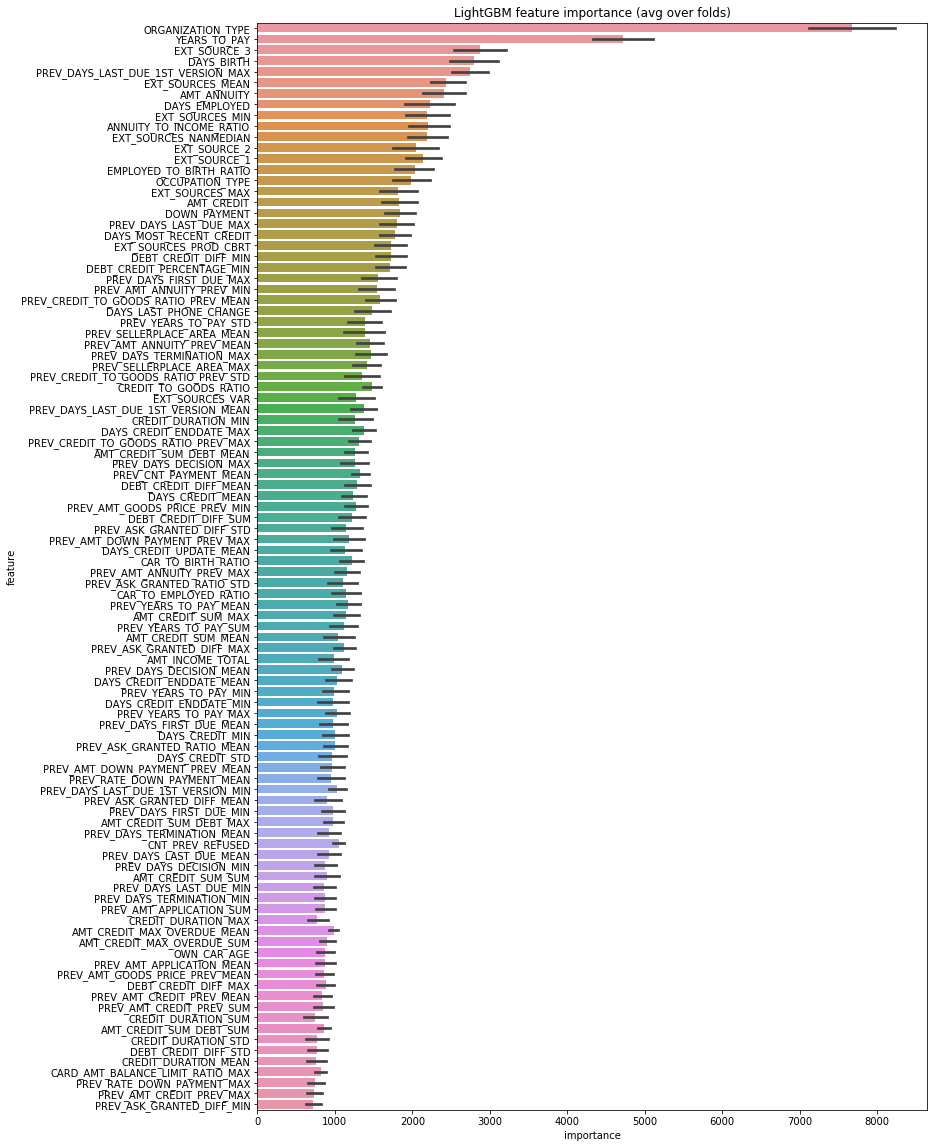

In [181]:
plot_feat_importance(feat_importance, (12,20))

We get a score of **0.787**. Lets try dropping some of the least important features and see how the model does.

In [187]:
feat_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=True).reset_index()[:10]

,feature,importance
0,CARD_AMT_DRAWINGS_OTHER_CURRENT_MIN,0.0
1,CARD_CNT_DRAWINGS_OTHER_CURRENT_MIN,0.0
2,CARD_CNT_DRAWINGS_ATM_CURRENT_MIN,2.2
3,CARD_AMT_DRAWINGS_ATM_CURRENT_MIN,6.2
4,CARD_CNT_DRAWINGS_OTHER_CURRENT_MAX,9.8
5,CARD_AMT_PAYMENT_TOTAL_CURRENT_MIN,13.2
6,CARD_AMT_DRAWING_LIMIT_RATIO_MIN,17.4
7,CARD_AMT_DRAWINGS_CURRENT_MIN,20.2
8,CARD_PAST_DUE_TOL_MAX,25.6
9,CARD_PAST_DUE_MAX,25.8


In [187]:
cols_to_drop = ['CARD_AMT_DRAWINGS_OTHER_CURRENT_MIN',
 'CARD_CNT_DRAWINGS_OTHER_CURRENT_MIN',
 'CARD_CNT_DRAWINGS_ATM_CURRENT_MIN',
 'CARD_AMT_DRAWINGS_ATM_CURRENT_MIN',
 'CARD_CNT_DRAWINGS_OTHER_CURRENT_MAX',
 'CARD_AMT_PAYMENT_TOTAL_CURRENT_MIN',
 'CARD_AMT_DRAWING_LIMIT_RATIO_MIN',
 'CARD_AMT_DRAWINGS_CURRENT_MIN',
 'CARD_PAST_DUE_TOL_MAX',
 'CARD_PAST_DUE_MAX']

In [188]:
df_to_model = appl_train_bureau_proc.drop(['SK_ID_CURR']+cols_to_drop, axis=1, inplace=False)
avg_score, fprs, tprs, roc_aucs, feat_importance = lightgbm_model(df_to_model,categorical_features,100)
del df_to_model
gc.collect()

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.788885	training's binary_logloss: 0.240412	valid_1's auc: 0.762547	valid_1's binary_logloss: 0.246756
[800]	training's auc: 0.815444	training's binary_logloss: 0.229208	valid_1's auc: 0.774246	valid_1's binary_logloss: 0.241494
[1200]	training's auc: 0.834167	training's binary_logloss: 0.221624	valid_1's auc: 0.779457	valid_1's binary_logloss: 0.239466
[1600]	training's auc: 0.84972	training's binary_logloss: 0.215385	valid_1's auc: 0.781827	valid_1's binary_logloss: 0.238535
[2000]	training's auc: 0.863521	training's binary_logloss: 0.209858	valid_1's auc: 0.783173	valid_1's binary_logloss: 0.238016
[2400]	training's auc: 0.875726	training's binary_logloss: 0.204814	valid_1's auc: 0.783853	valid_1's binary_logloss: 0.237757
[2800]	training's auc: 0.886404	training's binary_logloss: 0.200215	valid_1's auc: 0.784454	valid_1's binary_logloss: 0.237542
[3200]	training's auc: 0.895882	training's binary_l

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.788786	training's binary_logloss: 0.240119	valid_1's auc: 0.758582	valid_1's binary_logloss: 0.248235
[800]	training's auc: 0.81519	training's binary_logloss: 0.228934	valid_1's auc: 0.771466	valid_1's binary_logloss: 0.243014
[1200]	training's auc: 0.834342	training's binary_logloss: 0.221304	valid_1's auc: 0.777336	valid_1's binary_logloss: 0.240857
[1600]	training's auc: 0.849817	training's binary_logloss: 0.215084	valid_1's auc: 0.780202	valid_1's binary_logloss: 0.23983
[2000]	training's auc: 0.863379	training's binary_logloss: 0.209604	valid_1's auc: 0.781931	valid_1's binary_logloss: 0.239256
[2400]	training's auc: 0.875337	training's binary_logloss: 0.204594	valid_1's auc: 0.783034	valid_1's binary_logloss: 0.238894
[2800]	training's auc: 0.885862	training's binary_logloss: 0.199989	valid_1's auc: 0.783727	valid_1's binary_logloss: 0.238666
[3200]	training's auc: 0.895307	training's binary_lo

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.787285	training's binary_logloss: 0.240713	valid_1's auc: 0.765682	valid_1's binary_logloss: 0.246398
[800]	training's auc: 0.814324	training's binary_logloss: 0.229519	valid_1's auc: 0.778754	valid_1's binary_logloss: 0.240644
[1200]	training's auc: 0.833056	training's binary_logloss: 0.221957	valid_1's auc: 0.7848	valid_1's binary_logloss: 0.238217
[1600]	training's auc: 0.848568	training's binary_logloss: 0.215757	valid_1's auc: 0.787812	valid_1's binary_logloss: 0.236995
[2000]	training's auc: 0.862134	training's binary_logloss: 0.21031	valid_1's auc: 0.789567	valid_1's binary_logloss: 0.236312
[2400]	training's auc: 0.874357	training's binary_logloss: 0.205312	valid_1's auc: 0.790618	valid_1's binary_logloss: 0.235894
[2800]	training's auc: 0.885108	training's binary_logloss: 0.200721	valid_1's auc: 0.791265	valid_1's binary_logloss: 0.235634
[3200]	training's auc: 0.894793	training's binary_log

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.787583	training's binary_logloss: 0.24075	valid_1's auc: 0.765504	valid_1's binary_logloss: 0.246187
[800]	training's auc: 0.814485	training's binary_logloss: 0.229573	valid_1's auc: 0.778022	valid_1's binary_logloss: 0.240495
[1200]	training's auc: 0.833277	training's binary_logloss: 0.221976	valid_1's auc: 0.783891	valid_1's binary_logloss: 0.238126
[1600]	training's auc: 0.848761	training's binary_logloss: 0.215773	valid_1's auc: 0.78661	valid_1's binary_logloss: 0.23703
[2000]	training's auc: 0.862312	training's binary_logloss: 0.210286	valid_1's auc: 0.788261	valid_1's binary_logloss: 0.236394
[2400]	training's auc: 0.874488	training's binary_logloss: 0.205292	valid_1's auc: 0.789078	valid_1's binary_logloss: 0.236077
[2800]	training's auc: 0.885209	training's binary_logloss: 0.200687	valid_1's auc: 0.789719	valid_1's binary_logloss: 0.235838
[3200]	training's auc: 0.894619	training's binary_log

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.788654	training's binary_logloss: 0.240126	valid_1's auc: 0.757971	valid_1's binary_logloss: 0.248104
[800]	training's auc: 0.815388	training's binary_logloss: 0.228953	valid_1's auc: 0.770605	valid_1's binary_logloss: 0.243017
[1200]	training's auc: 0.833817	training's binary_logloss: 0.22146	valid_1's auc: 0.7766	valid_1's binary_logloss: 0.240913
[1600]	training's auc: 0.849687	training's binary_logloss: 0.2152	valid_1's auc: 0.780257	valid_1's binary_logloss: 0.239744
[2000]	training's auc: 0.863286	training's binary_logloss: 0.209706	valid_1's auc: 0.781927	valid_1's binary_logloss: 0.239163
[2400]	training's auc: 0.875501	training's binary_logloss: 0.204713	valid_1's auc: 0.783007	valid_1's binary_logloss: 0.238792
[2800]	training's auc: 0.886408	training's binary_logloss: 0.20009	valid_1's auc: 0.783693	valid_1's binary_logloss: 0.238562
[3200]	training's auc: 0.896214	training's binary_loglos

21

We get a score of **0.788** without the ten least important features. We will drop them and continue to the next part where we will go through the **installments_payments** table to get some additional features.

In [188]:
appl_train_bureau_proc.drop(cols_to_drop, axis=1, inplace=True)

---
## Installments_payments table
In this part, we will explore the features provided by the 'installments_payments' table.

In [189]:
installments_payments = reduce_memory(pd.read_csv('./datasets/installments_payments.csv'))

Initial df memory usage is 830.41 MB for 8 columns
Final memory usage is: 311.40 MB - decreased by 62.5%


In [190]:
installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
SK_ID_PREV                int32
SK_ID_CURR                int32
NUM_INSTALMENT_VERSION    float16
NUM_INSTALMENT_NUMBER     int16
DAYS_INSTALMENT           float16
DAYS_ENTRY_PAYMENT        float16
AMT_INSTALMENT            float32
AMT_PAYMENT               float32
dtypes: float16(3), float32(2), int16(1), int32(2)
memory usage: 311.4 MB


In [191]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


### Feature engineering 
We will engineer features using ratios and various aggregations with data from the **'installments_payments'** table

#### Ratios
Ratios regarding payment amount and dates

In [192]:
installments_payments['DAYS_INSTA_PAY_RATIO'] = installments_payments['DAYS_INSTALMENT']/installments_payments['DAYS_ENTRY_PAYMENT']
installments_payments['AMT_INSTAL_PAY_RATIO'] = installments_payments['AMT_INSTALMENT']/installments_payments['AMT_PAYMENT']

#### Late Payment
Flag (0/1) for when a payment is made late

In [193]:
installments_payments['LATE_PAYMENT'] = installments_payments['DAYS_INSTA_PAY_RATIO'].apply(lambda x : 1 if x > 1 else 0)

#### Early Payment
Flag (0/1) for when a payment is made earlier than the payment date

In [194]:
installments_payments['EARLY_PAYMENT'] = installments_payments['DAYS_INSTA_PAY_RATIO'].apply(lambda x : 1 if x < 1 else 0)

#### Payment on time
Flag (0/1) for when a payment is made on the payment date

In [195]:
installments_payments['ONTIME_PAYMENT'] = installments_payments['DAYS_INSTA_PAY_RATIO'].apply(lambda x : 1 if x == 1 else 0)

#### Under payment
Flag (0/1) for when a payment amount is less than the instalment 

In [196]:
installments_payments['UNDER_PAYMENT'] = installments_payments['AMT_INSTAL_PAY_RATIO'].apply(lambda x : 1 if x > 1 else 0)

#### Over payment
Flag (0/1) for when a payment amount is equal to or more than the instalment 

In [197]:
installments_payments['OVER_PAYMENT'] = installments_payments['AMT_INSTAL_PAY_RATIO'].apply(lambda x : 1 if x <= 1 else 0)

#### Precentage no payed
Percentage of the instalment amount that is not payed (for when it is applicable) 

In [198]:
installments_payments['PERCENT_NOT_PAYED'] = (installments_payments['AMT_INSTALMENT']-installments_payments['AMT_PAYMENT'])/installments_payments['AMT_INSTALMENT']

In [199]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DAYS_INSTA_PAY_RATIO,AMT_INSTAL_PAY_RATIO,LATE_PAYMENT,EARLY_PAYMENT,ONTIME_PAYMENT,UNDER_PAYMENT,OVER_PAYMENT,PERCENT_NOT_PAYED
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863,0.994141,1.000000,0,1,0,0,1,0.000000
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024,1.000000,1.000000,0,0,1,0,1,0.000000
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000,1.000000,1.000000,0,0,1,0,1,0.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859,0.996582,1.000000,0,1,0,0,1,0.000000
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961,1.012695,1.002062,1,0,0,1,0,0.002058


#### Aggregations
Aggregations of numeric columns using various funtions

In [200]:
inst_cols_agg = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'NUM_INSTALMENT_NUMBER': ['sum', 'max', 'mean', 'std'],
    'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_INSTA_PAY_RATIO': ['min', 'max', 'mean', 'std'],
    'AMT_INSTAL_PAY_RATIO': ['min', 'max', 'mean', 'std'],
    'LATE_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'EARLY_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'UNDER_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'OVER_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'PERCENT_NOT_PAYED': ['min', 'max', 'mean', 'std']
}

In [201]:
installments_payments = reduce_memory(installments_payments)

Initial df memory usage is 960.16 MB for 16 columns
Final memory usage is: 609.83 MB - decreased by 36.5%


In [202]:
installments_payments, inst_stat_features = apply_agg(installments_payments, inst_cols_agg, 'SK_ID_CURR', 'INST')

In [203]:
installments_payments_proc = reduce_memory(installments_payments[['SK_ID_CURR']+inst_stat_features])

del installments_payments
gc.collect()

installments_payments_proc.drop_duplicates(inplace=True)

Initial df memory usage is 2672.88 MB for 38 columns


c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Final memory usage is: 1595.94 MB - decreased by 40.3%


### Preprocessing
In this part we will process the data with the new features before training on it

In [204]:
appl_train_bureau_proc = reduce_memory(pd.merge(appl_train_bureau_proc, installments_payments_proc, on='SK_ID_CURR', how='left'))

Initial df memory usage is 317.89 MB for 293 columns
Final memory usage is: 242.23 MB - decreased by 23.8%


In [205]:
del installments_payments_proc
gc.collect()

28

In [206]:
appl_train_bureau_proc[inst_stat_features].fillna(0, inplace=True)
appl_train_bureau_proc.replace([np.inf, -np.inf], np.nan, inplace=True)

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [207]:
appl_train_bureau_proc.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,OWN_CAR_AGE,FLAG_OWN_CAR,CODE_GENDER,FLAG_OWN_REALTY,NAME_CONTRACT_TYPE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,DOC_COUNT,EXT_SOURCES_PROD_CBRT,EXT_SOURCES_MIN,EXT_SOURCES_MAX,EXT_SOURCES_MEAN,EXT_SOURCES_NANMEDIAN,EXT_SOURCES_VAR,YEARS_TO_PAY,DOWN_PAYMENT,CREDIT_TO_GOODS_RATIO,ANNUITY_TO_INCOME_RATIO,EMPLOYED_TO_BIRTH_RATIO,CAR_TO_BIRTH_RATIO,CAR_TO_EMPLOYED_RATIO,BURO_APP_CNT,CLOSED_CREDIT_CNT,ACTIVE_CREDIT_CNT,SOLD_CREDIT_CNT,AMT_ANNUITY_BUREAU_ACTIVE,DAYS_MOST_RECENT_CREDIT,CREDIT_PROLONG_COUNT,DAYS_CREDIT_MIN,DAYS_CREDIT_MEAN,DAYS_CREDIT_STD,DAYS_CREDIT_ENDDATE_MIN,DAYS_CREDIT_ENDDATE_MAX,DAYS_CREDIT_ENDDATE_MEAN,DAYS_CREDIT_ENDDATE_STD,CREDIT_DAY_OVERDUE_MAX,CREDIT_DAY_OVERDUE_MEAN,AMT_CREDIT_MAX_OVERDUE_MEAN,AMT_CREDIT_MAX_OVERDUE_SUM,AMT_CREDIT_SUM_MAX,AMT_CREDIT_SUM_MEAN,AMT_CREDIT_SUM_SUM,AMT_CREDIT_SUM_DEBT_MAX,AMT_CREDIT_SUM_DEBT_MEAN,AMT_CREDIT_SUM_DEBT_SUM,AMT_CREDIT_SUM_OVERDUE_MEAN,AMT_CREDIT_SUM_LIMIT_MEAN,AMT_CREDIT_SUM_LIMIT_SUM,AMT_ANNUITY_BUREAU_MAX,AMT_ANNUITY_BUREAU_MEAN,DAYS_CREDIT_UPDATE_MEAN,CREDIT_DURATION_MIN,CREDIT_DURATION_MAX,CREDIT_DURATION_MEAN,CREDIT_DURATION_STD,CREDIT_DURATION_SUM,DEBT_CREDIT_PERCENTAGE_MIN,DEBT_CREDIT_PERCENTAGE_MAX,DEBT_CREDIT_PERCENTAGE_MEAN,DEBT_CREDIT_PERCENTAGE_STD,DEBT_CREDIT_DIFF_MIN,DEBT_CREDIT_DIFF_MAX,DEBT_CREDIT_DIFF_MEAN,DEBT_CREDIT_DIFF_STD,DEBT_CREDIT_DIFF_SUM,CREDIT_TO_ANNUITY_RATIO_MIN,CREDIT_TO_ANNUITY_RATIO_MAX,CREDIT_TO_ANNUITY_RATIO_MEAN,CREDIT_TO_ANNUITY_RATIO_STD,CREDIT_TO_ANNUITY_RATIO_SUM,PREV_APP_CNT,CNT_PREV_APPROUVED,CNT_PREV_REFUSED,CNT_PREV_CANCELED,CNT_PREV_UNUSED,CNT_PREV_CASH_PORTFOLIO,CNT_PREV_POS_PORTFOLIO,CNT_PREV_XNA_PORTFOLIO,CNT_PREV_CARDS_PORTFOLIO,CNT_PREV_CASH_LOANS,CNT_PREV_CONSUMER_LOANS,CNT_PREV_REVOLV_LOANS,CNT_PREV_XNA_YIELD,CNT_PREV_MIDDLE_YIELD,CNT_PREV_HIGH_YIELD,CNT_PREV_LOW_NORMAL_YIELD,CNT_PREV_LOW_ACTION_YIELD,CNT_PREV_CLIENT_TYPE_REFRESHED,PREV_AMT_ANNUITY_PREV_MIN,PREV_AMT_ANNUITY_PREV_MAX,PREV_AMT_ANNUITY_PREV_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_SUM,PREV_AMT_CREDIT_PREV_MIN,PREV_AMT_CREDIT_PREV_MAX,PREV_AMT_CREDIT_PREV_MEAN,PREV_AMT_CREDIT_PREV_SUM,PREV_AMT_DOWN_PAYMENT_PREV_MIN,PREV_AMT_DOWN_PAYMENT_PREV_MAX,PREV_AMT_DOWN_PAYMENT_PREV_MEAN,PREV_AMT_GOODS_PRICE_PREV_MIN,PREV_AMT_GOODS_PRICE_PREV_MAX,PREV_AMT_GOODS_PRICE_PREV_MEAN,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_RATE_INTEREST_PRIMARY_MIN,PREV_RATE_INTEREST_PRIMARY_MAX,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_SELLERPLACE_AREA_MIN,PREV_SELLERPLACE_AREA_MAX,PREV_SELLERPLACE_AREA_MEAN,PREV_CNT_PAYMENT_MIN,PREV_CNT_PAYMENT_MAX,PREV_CNT_PAYMENT_MEAN,PREV_DAYS_FIRST_DRAWING_MIN,PREV_DAYS_FIRST_DRAWING_MAX,PREV_DAYS_FIRST_DRAWING_MEAN,PREV_DAYS_FIRST_DUE_MIN,PREV_DAYS_FIRST_DUE_MAX,PREV_DAYS_FIRST_DUE_MEAN,PREV_DAYS_LAST_DUE_1ST_VERSION_MIN,PREV_DAYS_LAST_DUE_1ST_VERSION_MAX,PREV_DAYS_LAST_DUE_1ST_VERSION_MEAN,PREV_DAYS_LAST_DUE_MIN,PREV_DAYS_LAST_DUE_MAX,PREV_DAYS_LAST_DUE_MEAN,PREV_DAYS_TERMINATION_MIN,PREV_DAYS_TERMINATION_MAX,PREV_DAYS_TERMINATION_MEAN,PREV_NFLAG_INSURED_ON_APPROVAL_MEAN,PREV_NFLAG_INSURED_ON_APPROVAL_STD,PREV_ASK_GRANTED_RATIO_MIN,PREV_ASK_GRANTED_RATIO_MAX,PREV_ASK_GRANTED_RATIO_MEAN,PREV_ASK_GRANTED_RATIO_STD,PREV_ASK_GRANTED_DIFF_MIN,PREV_ASK_GRANTED_DIFF_MAX,PREV_ASK_GRANTED_DIFF_MEAN,PREV_ASK_GRANTED_DIFF_STD,PREV_YEARS_TO_PAY_MIN,PREV_YEARS_TO_PAY_MAX,PREV_YEARS_TO_PAY_MEAN,PREV_YEARS_TO_PAY_STD,PREV_YEARS_TO_PAY_SUM,PREV_CREDIT_TO_GOODS_RATIO_PREV_MIN,PREV_CREDIT_TO_GOODS_RATIO_PREV_MAX,PREV_CREDIT_TO_GOODS_RATIO_PREV_MEAN,PREV_CREDIT_TO_G

### Training the model
In this part we will train the LightGBM model to see how the new features improve on our previous score.

In [208]:
df_to_model = appl_train_bureau_proc.drop(['SK_ID_CURR'], axis=1, inplace=False)
avg_score, fprs, tprs, roc_aucs, feat_importance = lightgbm_model(df_to_model,categorical_features,100)
del df_to_model
gc.collect()

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.794285	training's binary_logloss: 0.23904	valid_1's auc: 0.767218	valid_1's binary_logloss: 0.245558
[800]	training's auc: 0.820831	training's binary_logloss: 0.227247	valid_1's auc: 0.779365	valid_1's binary_logloss: 0.23986
[1200]	training's auc: 0.839559	training's binary_logloss: 0.219366	valid_1's auc: 0.784672	valid_1's binary_logloss: 0.23768
[1600]	training's auc: 0.854982	training's binary_logloss: 0.212938	valid_1's auc: 0.78725	valid_1's binary_logloss: 0.236669
[2000]	training's auc: 0.868323	training's binary_logloss: 0.207318	valid_1's auc: 0.788849	valid_1's binary_logloss: 0.23608
[2400]	training's auc: 0.880209	training's binary_logloss: 0.202205	valid_1's auc: 0.789693	valid_1's binary_logloss: 0.235746
[2800]	training's auc: 0.890863	training's binary_logloss: 0.197458	valid_1's auc: 0.790219	valid_1's binary_logloss: 0.235538
Early stopping, best iteration is:
[3027]	training's au

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.794546	training's binary_logloss: 0.238626	valid_1's auc: 0.765079	valid_1's binary_logloss: 0.246826
[800]	training's auc: 0.820967	training's binary_logloss: 0.226879	valid_1's auc: 0.778112	valid_1's binary_logloss: 0.241167
[1200]	training's auc: 0.839883	training's binary_logloss: 0.219012	valid_1's auc: 0.783979	valid_1's binary_logloss: 0.238903
[1600]	training's auc: 0.854977	training's binary_logloss: 0.21266	valid_1's auc: 0.786937	valid_1's binary_logloss: 0.237785
[2000]	training's auc: 0.868391	training's binary_logloss: 0.207038	valid_1's auc: 0.788739	valid_1's binary_logloss: 0.237142
[2400]	training's auc: 0.880291	training's binary_logloss: 0.20194	valid_1's auc: 0.789777	valid_1's binary_logloss: 0.236775
[2800]	training's auc: 0.890867	training's binary_logloss: 0.1972	valid_1's auc: 0.790498	valid_1's binary_logloss: 0.236532
[3200]	training's auc: 0.900467	training's binary_logl

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.793029	training's binary_logloss: 0.239215	valid_1's auc: 0.770517	valid_1's binary_logloss: 0.245225
[800]	training's auc: 0.819313	training's binary_logloss: 0.227571	valid_1's auc: 0.78431	valid_1's binary_logloss: 0.23902
[1200]	training's auc: 0.83787	training's binary_logloss: 0.219817	valid_1's auc: 0.790007	valid_1's binary_logloss: 0.236591
[1600]	training's auc: 0.853296	training's binary_logloss: 0.213489	valid_1's auc: 0.792954	valid_1's binary_logloss: 0.235397
[2000]	training's auc: 0.866733	training's binary_logloss: 0.207904	valid_1's auc: 0.794557	valid_1's binary_logloss: 0.234723
[2400]	training's auc: 0.8789	training's binary_logloss: 0.202803	valid_1's auc: 0.795617	valid_1's binary_logloss: 0.23431
[2800]	training's auc: 0.889793	training's binary_logloss: 0.198044	valid_1's auc: 0.796355	valid_1's binary_logloss: 0.234028
[3200]	training's auc: 0.899546	training's binary_loglos

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.793809	training's binary_logloss: 0.239151	valid_1's auc: 0.770408	valid_1's binary_logloss: 0.244992
[800]	training's auc: 0.820068	training's binary_logloss: 0.227472	valid_1's auc: 0.782454	valid_1's binary_logloss: 0.239046
[1200]	training's auc: 0.838638	training's binary_logloss: 0.219651	valid_1's auc: 0.788018	valid_1's binary_logloss: 0.236663
[1600]	training's auc: 0.853742	training's binary_logloss: 0.213295	valid_1's auc: 0.790922	valid_1's binary_logloss: 0.235478
[2000]	training's auc: 0.867196	training's binary_logloss: 0.20766	valid_1's auc: 0.792636	valid_1's binary_logloss: 0.234825
[2400]	training's auc: 0.879098	training's binary_logloss: 0.202537	valid_1's auc: 0.793675	valid_1's binary_logloss: 0.23444
[2800]	training's auc: 0.889709	training's binary_logloss: 0.197831	valid_1's auc: 0.794144	valid_1's binary_logloss: 0.23425
[3200]	training's auc: 0.899195	training's binary_log

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.794645	training's binary_logloss: 0.238612	valid_1's auc: 0.763653	valid_1's binary_logloss: 0.246842
[800]	training's auc: 0.820816	training's binary_logloss: 0.226935	valid_1's auc: 0.776574	valid_1's binary_logloss: 0.241354
[1200]	training's auc: 0.839307	training's binary_logloss: 0.21917	valid_1's auc: 0.78255	valid_1's binary_logloss: 0.239157
[1600]	training's auc: 0.854718	training's binary_logloss: 0.212775	valid_1's auc: 0.7858	valid_1's binary_logloss: 0.238008
[2000]	training's auc: 0.868273	training's binary_logloss: 0.207122	valid_1's auc: 0.787706	valid_1's binary_logloss: 0.237328
[2400]	training's auc: 0.880364	training's binary_logloss: 0.201994	valid_1's auc: 0.788969	valid_1's binary_logloss: 0.236901
[2800]	training's auc: 0.891011	training's binary_logloss: 0.197272	valid_1's auc: 0.789508	valid_1's binary_logloss: 0.236714
[3200]	training's auc: 0.900599	training's binary_logl

14

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



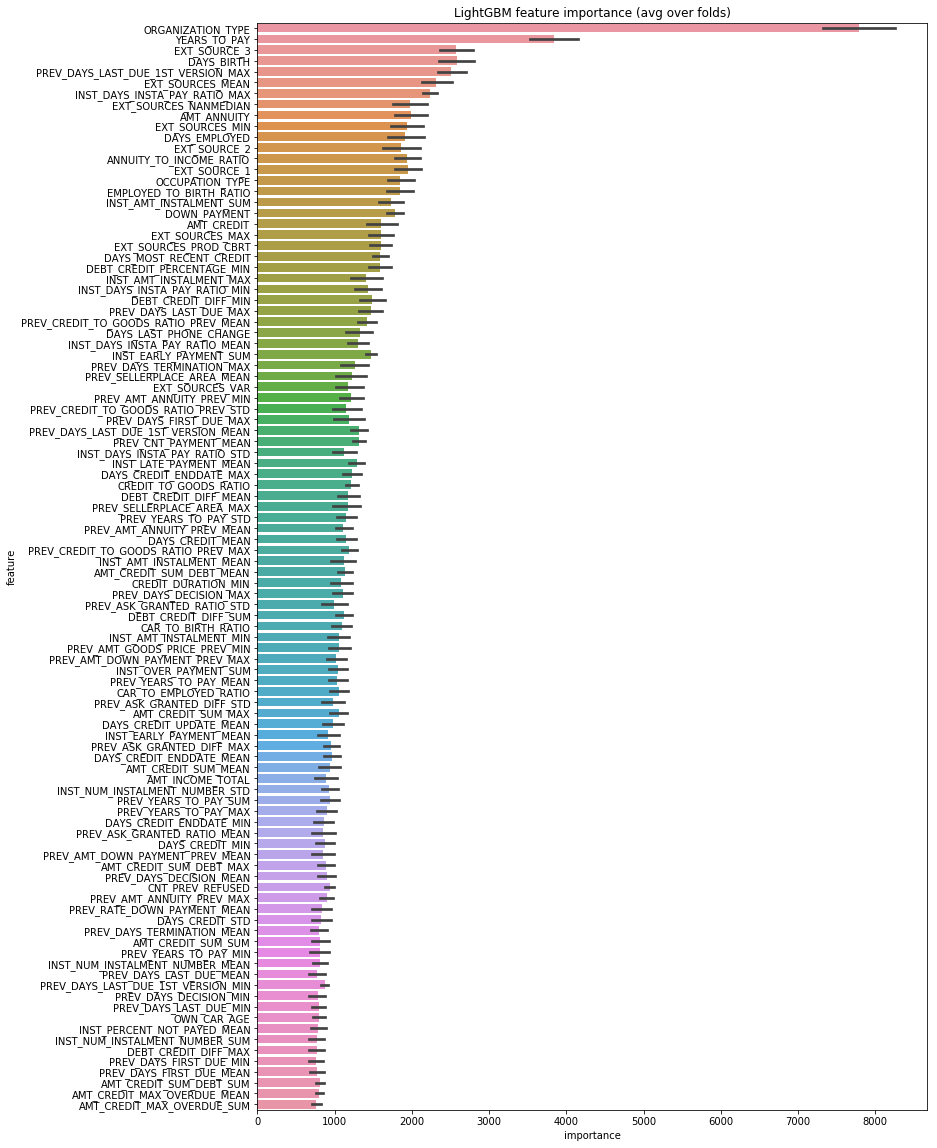

In [379]:
plot_feat_importance(feat_importance, (12,20))

We get a score of **0.793**. Lets try dropping some of the least important features and see how the model does.

In [385]:
feat_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=True).reset_index()[:10]

,feature,importance
0,INST_UNDER_PAYMENT_MIN,0.0
1,INST_LATE_PAYMENT_MIN,0.4
2,INST_OVER_PAYMENT_MAX,0.6
3,INST_UNDER_PAYMENT_MAX,0.6
4,INST_OVER_PAYMENT_MIN,1.6
5,INST_EARLY_PAYMENT_MAX,2.8
6,INST_LATE_PAYMENT_MAX,18.0
7,INST_EARLY_PAYMENT_MIN,20.8
8,CREDIT_PROLONG_COUNT,26.0
9,CARD_AMT_INST_MIN_REGULARITY_MIN,27.8


In [209]:
cols_to_drop = ['INST_UNDER_PAYMENT_MIN',
'INST_LATE_PAYMENT_MIN',
'INST_OVER_PAYMENT_MAX',
'INST_UNDER_PAYMENT_MAX',
'INST_OVER_PAYMENT_MIN',
'INST_EARLY_PAYMENT_MAX',
'INST_LATE_PAYMENT_MAX',
'INST_EARLY_PAYMENT_MIN']

In [387]:
df_to_model = appl_train_bureau_proc.drop(['SK_ID_CURR']+cols_to_drop, axis=1, inplace=False)
avg_score, fprs, tprs, roc_aucs, feat_importance = lightgbm_model(df_to_model,categorical_features,100)
del df_to_model
gc.collect()

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.794297	training's binary_logloss: 0.239014	valid_1's auc: 0.767418	valid_1's binary_logloss: 0.245493
[800]	training's auc: 0.820671	training's binary_logloss: 0.227302	valid_1's auc: 0.779524	valid_1's binary_logloss: 0.239791
[1200]	training's auc: 0.839231	training's binary_logloss: 0.219491	valid_1's auc: 0.78477	valid_1's binary_logloss: 0.237657
[1600]	training's auc: 0.854549	training's binary_logloss: 0.213092	valid_1's auc: 0.787206	valid_1's binary_logloss: 0.236669
[2000]	training's auc: 0.868098	training's binary_logloss: 0.207446	valid_1's auc: 0.788832	valid_1's binary_logloss: 0.23607
[2400]	training's auc: 0.879943	training's binary_logloss: 0.202347	valid_1's auc: 0.789496	valid_1's binary_logloss: 0.235796
[2800]	training's auc: 0.890438	training's binary_logloss: 0.197675	valid_1's auc: 0.790149	valid_1's binary_logloss: 0.235557
[3200]	training's auc: 0.899966	training's binary_lo

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.794216	training's binary_logloss: 0.238688	valid_1's auc: 0.765454	valid_1's binary_logloss: 0.246744
[800]	training's auc: 0.820584	training's binary_logloss: 0.226987	valid_1's auc: 0.778363	valid_1's binary_logloss: 0.241081
[1200]	training's auc: 0.839158	training's binary_logloss: 0.219206	valid_1's auc: 0.784199	valid_1's binary_logloss: 0.238793
[1600]	training's auc: 0.854782	training's binary_logloss: 0.212783	valid_1's auc: 0.787079	valid_1's binary_logloss: 0.237703
[2000]	training's auc: 0.867998	training's binary_logloss: 0.207193	valid_1's auc: 0.788957	valid_1's binary_logloss: 0.237036
[2400]	training's auc: 0.879675	training's binary_logloss: 0.202139	valid_1's auc: 0.790058	valid_1's binary_logloss: 0.236658
[2800]	training's auc: 0.890293	training's binary_logloss: 0.197429	valid_1's auc: 0.790707	valid_1's binary_logloss: 0.236416
[3200]	training's auc: 0.899659	training's binary_

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.793087	training's binary_logloss: 0.23918	valid_1's auc: 0.770956	valid_1's binary_logloss: 0.245186
[800]	training's auc: 0.81905	training's binary_logloss: 0.227634	valid_1's auc: 0.784284	valid_1's binary_logloss: 0.239014
[1200]	training's auc: 0.837709	training's binary_logloss: 0.219886	valid_1's auc: 0.790046	valid_1's binary_logloss: 0.236549
[1600]	training's auc: 0.853204	training's binary_logloss: 0.213523	valid_1's auc: 0.793145	valid_1's binary_logloss: 0.235294
[2000]	training's auc: 0.866865	training's binary_logloss: 0.207914	valid_1's auc: 0.795074	valid_1's binary_logloss: 0.234542
[2400]	training's auc: 0.878757	training's binary_logloss: 0.202837	valid_1's auc: 0.796059	valid_1's binary_logloss: 0.234113
[2800]	training's auc: 0.889483	training's binary_logloss: 0.198142	valid_1's auc: 0.796823	valid_1's binary_logloss: 0.23381
[3200]	training's auc: 0.899185	training's binary_log

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.7939	training's binary_logloss: 0.239211	valid_1's auc: 0.770048	valid_1's binary_logloss: 0.245057
[800]	training's auc: 0.8197	training's binary_logloss: 0.227627	valid_1's auc: 0.78199	valid_1's binary_logloss: 0.239148
[1200]	training's auc: 0.838362	training's binary_logloss: 0.219822	valid_1's auc: 0.787729	valid_1's binary_logloss: 0.236737
[1600]	training's auc: 0.853602	training's binary_logloss: 0.21345	valid_1's auc: 0.790503	valid_1's binary_logloss: 0.235587
[2000]	training's auc: 0.867032	training's binary_logloss: 0.207836	valid_1's auc: 0.792116	valid_1's binary_logloss: 0.234936
[2400]	training's auc: 0.878863	training's binary_logloss: 0.202741	valid_1's auc: 0.793016	valid_1's binary_logloss: 0.234561
[2800]	training's auc: 0.889517	training's binary_logloss: 0.19804	valid_1's auc: 0.793464	valid_1's binary_logloss: 0.234356
Early stopping, best iteration is:
[3072]	training's auc:

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.794547	training's binary_logloss: 0.23864	valid_1's auc: 0.763628	valid_1's binary_logloss: 0.24684
[800]	training's auc: 0.820579	training's binary_logloss: 0.227018	valid_1's auc: 0.776648	valid_1's binary_logloss: 0.241338
[1200]	training's auc: 0.839063	training's binary_logloss: 0.219266	valid_1's auc: 0.782625	valid_1's binary_logloss: 0.239129
[1600]	training's auc: 0.854562	training's binary_logloss: 0.212883	valid_1's auc: 0.786097	valid_1's binary_logloss: 0.237913
[2000]	training's auc: 0.868023	training's binary_logloss: 0.207267	valid_1's auc: 0.787861	valid_1's binary_logloss: 0.237284
[2400]	training's auc: 0.880101	training's binary_logloss: 0.202135	valid_1's auc: 0.78914	valid_1's binary_logloss: 0.236837
[2800]	training's auc: 0.89082	training's binary_logloss: 0.197403	valid_1's auc: 0.789768	valid_1's binary_logloss: 0.236608
[3200]	training's auc: 0.900375	training's binary_logl

21

We get a score of **0.793** without the least important features. We will drop them and move to the next part where we will got through the **'POS_CASH_balance'** table to get some more features.

In [210]:
appl_train_bureau_proc.drop(cols_to_drop, axis=1, inplace=True)

---
## POS_CASH_balance table
In this part, we will explore the features provided by the 'POS_CASH_balance' table.

In [211]:
pos_balance = reduce_memory(pd.read_csv('./datasets/POS_CASH_balance.csv'))

Initial df memory usage is 610.43 MB for 8 columns
Final memory usage is: 238.45 MB - decreased by 60.9%


In [212]:
pos_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
SK_ID_PREV               int32
SK_ID_CURR               int32
MONTHS_BALANCE           int8
CNT_INSTALMENT           float16
CNT_INSTALMENT_FUTURE    float16
NAME_CONTRACT_STATUS     object
SK_DPD                   int16
SK_DPD_DEF               int16
dtypes: float16(2), int16(2), int32(2), int8(1), object(1)
memory usage: 238.5+ MB


In [213]:
pos_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [214]:
pos_balance['NAME_CONTRACT_STATUS'].value_counts()

Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: NAME_CONTRACT_STATUS, dtype: int64

In [215]:
pos_balance['CNT_INSTALMENT'].describe()

count    9975287.0
mean           NaN
std            0.0
min            1.0
25%           10.0
50%           12.0
75%           24.0
max           92.0
Name: CNT_INSTALMENT, dtype: float64

In [216]:
pos_balance['SK_DPD'].describe()

count    1.000136e+07
mean     1.160693e+01
std      1.327140e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.231000e+03
Name: SK_DPD, dtype: float64

In [217]:
pos_balance['SK_DPD_DEF'].describe()

count    1.000136e+07
mean     6.544684e-01
std      3.276249e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.595000e+03
Name: SK_DPD_DEF, dtype: float64

### Feature engineering 
We will engineer features using ratios and various aggregations with data from the **'pos_balance'** table

#### Days past due
Creating a flag for days past due

In [218]:
pos_balance['PAST_DUE'] = pos_balance['SK_DPD'].apply(lambda s : 1 if s>0 else 0)
pos_balance['PAST_DUE_TOL'] = pos_balance['SK_DPD_DEF'].apply(lambda s : 1 if s>0 else 0)

#### Instalment by month count
Count of instalments devided by the months balance

In [219]:
pos_balance['CNT_INSTAL_BY_MONTH'] = -pos_balance['CNT_INSTALMENT']/pos_balance['MONTHS_BALANCE']

#### Future instalment by month count
Count of future instalments devided by the months balance

In [220]:
pos_balance['CNT_INSTAL_FUTURE_BY_MONTH'] = -pos_balance['CNT_INSTALMENT_FUTURE']/pos_balance['MONTHS_BALANCE']

#### Ratios and differences
Some ratios and differences

In [221]:
pos_balance['CNT_INSTAL_FUTURE_RATIO'] = pos_balance['CNT_INSTALMENT']/pos_balance['CNT_INSTALMENT_FUTURE']
pos_balance['CNT_INSTAL_FUTURE_MONTH_RATIO'] = pos_balance['CNT_INSTAL_BY_MONTH']/pos_balance['CNT_INSTALMENT_FUTURE']
pos_balance['CNT_INSTAL_FUTURE_MONTH_DIF'] = pos_balance['CNT_INSTAL_BY_MONTH']-pos_balance['CNT_INSTAL_FUTURE_BY_MONTH']

#### POS active count
Count of all active POS

In [222]:
cnt_pos_active_df = pos_balance[pos_balance['NAME_CONTRACT_STATUS']=='Active'].groupby(['SK_ID_CURR'])['NAME_CONTRACT_STATUS'].agg('count').reset_index(name='CNT_POS_ACTIVE')
cnt_pos_active_df.head()

,SK_ID_CURR,CNT_POS_ACTIVE
0,100001,7
1,100002,19
2,100003,26
3,100004,3
4,100005,9


In [223]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, cnt_pos_active_df, on='SK_ID_CURR', how='left')

In [224]:
del cnt_pos_active_df
gc.collect()

84

#### POS completed count
Count of all completed POS

In [225]:
cnt_pos_comp_df = pos_balance[pos_balance['NAME_CONTRACT_STATUS']=='Completed'].groupby(['SK_ID_CURR'])['NAME_CONTRACT_STATUS'].agg('count').reset_index(name='CNT_POS_COMPLETED')
cnt_pos_comp_df.head()

,SK_ID_CURR,CNT_POS_COMPLETED
0,100001,2
1,100003,2
2,100004,1
3,100005,1
4,100006,2


In [226]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, cnt_pos_comp_df, on='SK_ID_CURR', how='left')

In [227]:
del cnt_pos_comp_df
gc.collect()

7

#### POS signed count
Count of all signed POS

In [228]:
cnt_pos_signed_df = pos_balance[pos_balance['NAME_CONTRACT_STATUS']=='Signed'].groupby(['SK_ID_CURR'])['NAME_CONTRACT_STATUS'].agg('count').reset_index(name='CNT_POS_SIGNED')
cnt_pos_signed_df.head()

,SK_ID_CURR,CNT_POS_SIGNED
0,100005,1
1,100007,1
2,100008,1
3,100013,1
4,100035,1


In [229]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, cnt_pos_signed_df, on='SK_ID_CURR', how='left')

In [230]:
del cnt_pos_signed_df
gc.collect()

7

#### POS demand count
Count of all demand POS

In [231]:
cnt_pos_demand_df = pos_balance[pos_balance['NAME_CONTRACT_STATUS']=='Demand'].groupby(['SK_ID_CURR'])['NAME_CONTRACT_STATUS'].agg('count').reset_index(name='CNT_POS_DEMAND')
cnt_pos_demand_df.head()

,SK_ID_CURR,CNT_POS_DEMAND
0,101402,2
1,101444,27
2,101474,64
3,101851,65
4,103838,1


In [232]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, cnt_pos_demand_df, on='SK_ID_CURR', how='left')

In [233]:
del cnt_pos_demand_df
gc.collect()

7

#### POS returned to the store count
Count of all returned to the store POS

In [234]:
cnt_pos_returned_df = pos_balance[pos_balance['NAME_CONTRACT_STATUS']=='Returned to the store'].groupby(['SK_ID_CURR'])['NAME_CONTRACT_STATUS'].agg('count').reset_index(name='CNT_POS_RETURNED')
cnt_pos_returned_df.head()

,SK_ID_CURR,CNT_POS_RETURNED
0,100006,1
1,100092,1
2,100094,1
3,100101,1
4,100110,1


In [235]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, cnt_pos_returned_df, on='SK_ID_CURR', how='left')

In [236]:
del cnt_pos_returned_df
gc.collect()

7

#### POS approved to the store count
Count of all approved to the store POS

In [237]:
cnt_pos_approved_df = pos_balance[pos_balance['NAME_CONTRACT_STATUS']=='Approved'].groupby(['SK_ID_CURR'])['NAME_CONTRACT_STATUS'].agg('count').reset_index(name='CNT_POS_APPROVED')
cnt_pos_approved_df.head()

,SK_ID_CURR,CNT_POS_APPROVED
0,100164,1
1,100209,1
2,100239,1
3,100503,1
4,100557,1


In [238]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, cnt_pos_approved_df, on='SK_ID_CURR', how='left')

In [239]:
del cnt_pos_approved_df
gc.collect()

7

#### Aggregations
Aggregations of numeric columns using various funtions

In [240]:
pos_cols_agg = {
    'CNT_INSTAL_BY_MONTH': ['min', 'max', 'mean', 'std'],
    'CNT_INSTAL_FUTURE_BY_MONTH': ['min', 'max', 'mean', 'std'],
    'CNT_INSTAL_FUTURE_RATIO': ['min', 'max', 'mean', 'std'],
    'CNT_INSTAL_FUTURE_MONTH_RATIO': ['min', 'max', 'mean', 'std'],
    'CNT_INSTAL_FUTURE_MONTH_DIF': ['min', 'max', 'mean', 'std'],
    'CNT_INSTALMENT': ['min', 'max', 'mean', 'std'],
    'CNT_INSTALMENT_FUTURE': ['min', 'max', 'mean', 'std'],
    'PAST_DUE': ['max', 'sum'],
    'PAST_DUE_TOL': ['max', 'sum']
}

In [241]:
pos_balance, pos_stat_features = apply_agg(pos_balance, pos_cols_agg, 'SK_ID_CURR', 'POS')

In [242]:
pos_balance_proc = pos_balance[['SK_ID_CURR']+pos_stat_features]

del pos_balance
gc.collect()

pos_balance_proc.drop_duplicates(inplace=True)

### Preprocessing
In this part we will process the data with the new features before training on it

In [243]:
appl_train_bureau_proc = reduce_memory(pd.merge(appl_train_bureau_proc, pos_balance_proc, on='SK_ID_CURR', how='left'))

Initial df memory usage is 317.30 MB for 323 columns
Final memory usage is: 261.59 MB - decreased by 17.6%


In [244]:
del pos_balance_proc
gc.collect()

14

In [250]:
pos_features = ['CNT_POS_ACTIVE',
    'CNT_POS_COMPLETED',
    'CNT_POS_SIGNED',
    'CNT_POS_DEMAND',
    'CNT_POS_RETURNED',
    'CNT_POS_APPROVED'] + pos_stat_features

appl_train_bureau_proc[pos_features].fillna(0, inplace=True)
appl_train_bureau_proc.replace([np.inf, -np.inf], np.nan, inplace=True)

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [251]:
appl_train_bureau_proc.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,OWN_CAR_AGE,FLAG_OWN_CAR,CODE_GENDER,FLAG_OWN_REALTY,NAME_CONTRACT_TYPE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,DOC_COUNT,EXT_SOURCES_PROD_CBRT,EXT_SOURCES_MIN,EXT_SOURCES_MAX,EXT_SOURCES_MEAN,EXT_SOURCES_NANMEDIAN,EXT_SOURCES_VAR,YEARS_TO_PAY,DOWN_PAYMENT,CREDIT_TO_GOODS_RATIO,ANNUITY_TO_INCOME_RATIO,EMPLOYED_TO_BIRTH_RATIO,CAR_TO_BIRTH_RATIO,CAR_TO_EMPLOYED_RATIO,BURO_APP_CNT,CLOSED_CREDIT_CNT,ACTIVE_CREDIT_CNT,SOLD_CREDIT_CNT,AMT_ANNUITY_BUREAU_ACTIVE,DAYS_MOST_RECENT_CREDIT,CREDIT_PROLONG_COUNT,DAYS_CREDIT_MIN,DAYS_CREDIT_MEAN,DAYS_CREDIT_STD,DAYS_CREDIT_ENDDATE_MIN,DAYS_CREDIT_ENDDATE_MAX,DAYS_CREDIT_ENDDATE_MEAN,DAYS_CREDIT_ENDDATE_STD,CREDIT_DAY_OVERDUE_MAX,CREDIT_DAY_OVERDUE_MEAN,AMT_CREDIT_MAX_OVERDUE_MEAN,AMT_CREDIT_MAX_OVERDUE_SUM,AMT_CREDIT_SUM_MAX,AMT_CREDIT_SUM_MEAN,AMT_CREDIT_SUM_SUM,AMT_CREDIT_SUM_DEBT_MAX,AMT_CREDIT_SUM_DEBT_MEAN,AMT_CREDIT_SUM_DEBT_SUM,AMT_CREDIT_SUM_OVERDUE_MEAN,AMT_CREDIT_SUM_LIMIT_MEAN,AMT_CREDIT_SUM_LIMIT_SUM,AMT_ANNUITY_BUREAU_MAX,AMT_ANNUITY_BUREAU_MEAN,DAYS_CREDIT_UPDATE_MEAN,CREDIT_DURATION_MIN,CREDIT_DURATION_MAX,CREDIT_DURATION_MEAN,CREDIT_DURATION_STD,CREDIT_DURATION_SUM,DEBT_CREDIT_PERCENTAGE_MIN,DEBT_CREDIT_PERCENTAGE_MAX,DEBT_CREDIT_PERCENTAGE_MEAN,DEBT_CREDIT_PERCENTAGE_STD,DEBT_CREDIT_DIFF_MIN,DEBT_CREDIT_DIFF_MAX,DEBT_CREDIT_DIFF_MEAN,DEBT_CREDIT_DIFF_STD,DEBT_CREDIT_DIFF_SUM,CREDIT_TO_ANNUITY_RATIO_MIN,CREDIT_TO_ANNUITY_RATIO_MAX,CREDIT_TO_ANNUITY_RATIO_MEAN,CREDIT_TO_ANNUITY_RATIO_STD,CREDIT_TO_ANNUITY_RATIO_SUM,PREV_APP_CNT,CNT_PREV_APPROUVED,CNT_PREV_REFUSED,CNT_PREV_CANCELED,CNT_PREV_UNUSED,CNT_PREV_CASH_PORTFOLIO,CNT_PREV_POS_PORTFOLIO,CNT_PREV_XNA_PORTFOLIO,CNT_PREV_CARDS_PORTFOLIO,CNT_PREV_CASH_LOANS,CNT_PREV_CONSUMER_LOANS,CNT_PREV_REVOLV_LOANS,CNT_PREV_XNA_YIELD,CNT_PREV_MIDDLE_YIELD,CNT_PREV_HIGH_YIELD,CNT_PREV_LOW_NORMAL_YIELD,CNT_PREV_LOW_ACTION_YIELD,CNT_PREV_CLIENT_TYPE_REFRESHED,PREV_AMT_ANNUITY_PREV_MIN,PREV_AMT_ANNUITY_PREV_MAX,PREV_AMT_ANNUITY_PREV_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_SUM,PREV_AMT_CREDIT_PREV_MIN,PREV_AMT_CREDIT_PREV_MAX,PREV_AMT_CREDIT_PREV_MEAN,PREV_AMT_CREDIT_PREV_SUM,PREV_AMT_DOWN_PAYMENT_PREV_MIN,PREV_AMT_DOWN_PAYMENT_PREV_MAX,PREV_AMT_DOWN_PAYMENT_PREV_MEAN,PREV_AMT_GOODS_PRICE_PREV_MIN,PREV_AMT_GOODS_PRICE_PREV_MAX,PREV_AMT_GOODS_PRICE_PREV_MEAN,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_RATE_INTEREST_PRIMARY_MIN,PREV_RATE_INTEREST_PRIMARY_MAX,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_SELLERPLACE_AREA_MIN,PREV_SELLERPLACE_AREA_MAX,PREV_SELLERPLACE_AREA_MEAN,PREV_CNT_PAYMENT_MIN,PREV_CNT_PAYMENT_MAX,PREV_CNT_PAYMENT_MEAN,PREV_DAYS_FIRST_DRAWING_MIN,PREV_DAYS_FIRST_DRAWING_MAX,PREV_DAYS_FIRST_DRAWING_MEAN,PREV_DAYS_FIRST_DUE_MIN,PREV_DAYS_FIRST_DUE_MAX,PREV_DAYS_FIRST_DUE_MEAN,PREV_DAYS_LAST_DUE_1ST_VERSION_MIN,PREV_DAYS_LAST_DUE_1ST_VERSION_MAX,PREV_DAYS_LAST_DUE_1ST_VERSION_MEAN,PREV_DAYS_LAST_DUE_MIN,PREV_DAYS_LAST_DUE_MAX,PREV_DAYS_LAST_DUE_MEAN,PREV_DAYS_TERMINATION_MIN,PREV_DAYS_TERMINATION_MAX,PREV_DAYS_TERMINATION_MEAN,PREV_NFLAG_INSURED_ON_APPROVAL_MEAN,PREV_NFLAG_INSURED_ON_APPROVAL_STD,PREV_ASK_GRANTED_RATIO_MIN,PREV_ASK_GRANTED_RATIO_MAX,PREV_ASK_GRANTED_RATIO_MEAN,PREV_ASK_GRANTED_RATIO_STD,PREV_ASK_GRANTED_DIFF_MIN,PREV_ASK_GRANTED_DIFF_MAX,PREV_ASK_GRANTED_DIFF_MEAN,PREV_ASK_GRANTED_DIFF_STD,PREV_YEARS_TO_PAY_MIN,PREV_YEARS_TO_PAY_MAX,PREV_YEARS_TO_PAY_MEAN,PREV_YEARS_TO_PAY_STD,PREV_YEARS_TO_PAY_SUM,PREV_CREDIT_TO_GOODS_RATIO_PREV_MIN,PREV_CREDIT_TO_GOODS_RATIO_PREV_MAX,PREV_CREDIT_TO_GOODS_RATIO_PREV_MEAN,PREV_CREDIT_TO_G

In [253]:
cols = [col for col in appl_train_bureau_proc if col.startswith('CARD_')]
appl_train_bureau_proc[cols] = appl_train_bureau_proc[cols].fillna(0) 

### Training the model
In this part we will train the LightGBM model to see how the new features improve on our previous score.

In [231]:
df_to_model = appl_train_bureau_proc.drop(['SK_ID_CURR'], axis=1, inplace=False)
avg_score, fprs, tprs, roc_aucs, feat_importance = lightgbm_model(df_to_model,categorical_features,100)
del df_to_model
gc.collect()

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.238799	training's auc: 0.795238	valid_1's binary_logloss: 0.245429	valid_1's auc: 0.767691
[800]	training's binary_logloss: 0.226885	training's auc: 0.821849	valid_1's binary_logloss: 0.239643	valid_1's auc: 0.77987
[1200]	training's binary_logloss: 0.218973	training's auc: 0.840471	valid_1's binary_logloss: 0.23741	valid_1's auc: 0.7854
[1600]	training's binary_logloss: 0.21254	training's auc: 0.855746	valid_1's binary_logloss: 0.236379	valid_1's auc: 0.788012
[2000]	training's binary_logloss: 0.206804	training's auc: 0.869275	valid_1's binary_logloss: 0.235749	valid_1's auc: 0.789623
[2400]	training's binary_logloss: 0.201592	training's auc: 0.881382	valid_1's binary_logloss: 0.235425	valid_1's auc: 0.790446
[2800]	training's binary_logloss: 0.196803	training's auc: 0.892113	valid_1's binary_logloss: 0.235234	valid_1's auc: 0.790924
[3200]	training's binary_logloss: 0.192298	training's a

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.238444	training's auc: 0.795215	valid_1's binary_logloss: 0.246727	valid_1's auc: 0.765412
[800]	training's binary_logloss: 0.226567	training's auc: 0.821737	valid_1's binary_logloss: 0.241017	valid_1's auc: 0.778433
[1200]	training's binary_logloss: 0.218573	training's auc: 0.84081	valid_1's binary_logloss: 0.238729	valid_1's auc: 0.784331
[1600]	training's binary_logloss: 0.21212	training's auc: 0.856239	valid_1's binary_logloss: 0.237595	valid_1's auc: 0.787273
[2000]	training's binary_logloss: 0.20645	training's auc: 0.869391	valid_1's binary_logloss: 0.236955	valid_1's auc: 0.789118
[2400]	training's binary_logloss: 0.201296	training's auc: 0.881286	valid_1's binary_logloss: 0.236585	valid_1's auc: 0.790207
[2800]	training's binary_logloss: 0.196505	training's auc: 0.891899	valid_1's binary_logloss: 0.236364	valid_1's auc: 0.790748
[3200]	training's binary_logloss: 0.192041	training's

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.238964	training's auc: 0.794045	valid_1's binary_logloss: 0.244997	valid_1's auc: 0.771583
[800]	training's binary_logloss: 0.227201	training's auc: 0.820324	valid_1's binary_logloss: 0.23876	valid_1's auc: 0.784856
[1200]	training's binary_logloss: 0.219277	training's auc: 0.839251	valid_1's binary_logloss: 0.236269	valid_1's auc: 0.790716
[1600]	training's binary_logloss: 0.212834	training's auc: 0.854799	valid_1's binary_logloss: 0.235062	valid_1's auc: 0.793642
[2000]	training's binary_logloss: 0.207127	training's auc: 0.868445	valid_1's binary_logloss: 0.234384	valid_1's auc: 0.795239
[2400]	training's binary_logloss: 0.201941	training's auc: 0.880515	valid_1's binary_logloss: 0.233943	valid_1's auc: 0.79638
[2800]	training's binary_logloss: 0.197169	training's auc: 0.891276	valid_1's binary_logloss: 0.233638	valid_1's auc: 0.797206
[3200]	training's binary_logloss: 0.192699	training'

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.238926	training's auc: 0.79488	valid_1's binary_logloss: 0.244934	valid_1's auc: 0.770684
[800]	training's binary_logloss: 0.227183	training's auc: 0.821004	valid_1's binary_logloss: 0.239011	valid_1's auc: 0.782633
[1200]	training's binary_logloss: 0.219287	training's auc: 0.839647	valid_1's binary_logloss: 0.236593	valid_1's auc: 0.788368
[1600]	training's binary_logloss: 0.212802	training's auc: 0.855044	valid_1's binary_logloss: 0.235455	valid_1's auc: 0.791028
[2000]	training's binary_logloss: 0.207115	training's auc: 0.868378	valid_1's binary_logloss: 0.234819	valid_1's auc: 0.792545
[2400]	training's binary_logloss: 0.201916	training's auc: 0.880429	valid_1's binary_logloss: 0.234437	valid_1's auc: 0.793494
[2800]	training's binary_logloss: 0.197146	training's auc: 0.891035	valid_1's binary_logloss: 0.234237	valid_1's auc: 0.79395
[3200]	training's binary_logloss: 0.192673	training'

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.23839	training's auc: 0.795891	valid_1's binary_logloss: 0.246665	valid_1's auc: 0.764395
[800]	training's binary_logloss: 0.226555	training's auc: 0.821967	valid_1's binary_logloss: 0.241125	valid_1's auc: 0.777361
[1200]	training's binary_logloss: 0.2187	training's auc: 0.840484	valid_1's binary_logloss: 0.238909	valid_1's auc: 0.783155
[1600]	training's binary_logloss: 0.212243	training's auc: 0.855972	valid_1's binary_logloss: 0.237725	valid_1's auc: 0.786477
[2000]	training's binary_logloss: 0.206516	training's auc: 0.86962	valid_1's binary_logloss: 0.23704	valid_1's auc: 0.788418
[2400]	training's binary_logloss: 0.201326	training's auc: 0.88171	valid_1's binary_logloss: 0.236605	valid_1's auc: 0.789634
[2800]	training's binary_logloss: 0.19655	training's auc: 0.892492	valid_1's binary_logloss: 0.236384	valid_1's auc: 0.790203
[3200]	training's binary_logloss: 0.192045	training's auc

14

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



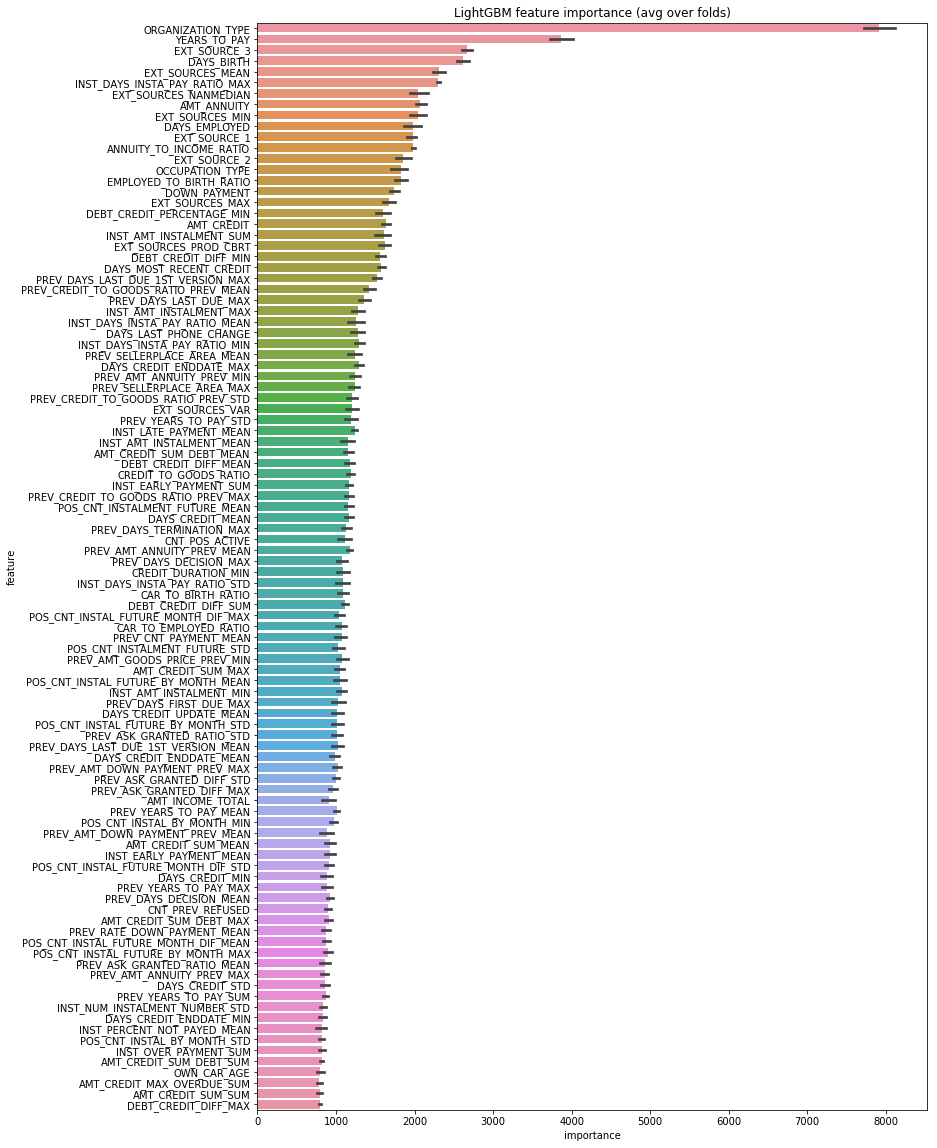

In [232]:
plot_feat_importance(feat_importance, (12,20))

We get a score of about **0.793**. Lets try dropping some of the least important features and see how the model does.

In [233]:
feat_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=True).reset_index()[:10]

,feature,importance
0,CNT_POS_DEMAND,2.2
1,CNT_POS_APPROVED,18.8
2,CREDIT_PROLONG_COUNT,26.6
3,CARD_CNT_INSTALMENT_MATURE_CUM_MIN,26.8
4,CARD_AMT_INST_MIN_REGULARITY_MIN,27.2
5,CARD_CNT_DRAWINGS_CURRENT_MIN,28.4
6,CARD_CNT_DRAWINGS_OTHER_CURRENT_MEAN,29.2
7,POS_PAST_DUE_MAX,30.8
8,POS_CNT_INSTALMENT_FUTURE_MIN,34.0
9,FLAG_OWN_CAR,37.0


In [255]:
cols_to_drop = ['CNT_POS_DEMAND',
'CNT_POS_APPROVED',
'CREDIT_PROLONG_COUNT',
'CARD_CNT_INSTALMENT_MATURE_CUM_MIN',
'CARD_AMT_INST_MIN_REGULARITY_MIN',
'CARD_CNT_DRAWINGS_CURRENT_MIN']

In [235]:
df_to_model = appl_train_bureau_proc.drop(['SK_ID_CURR']+cols_to_drop, axis=1, inplace=False)
avg_score, fprs, tprs, roc_aucs, feat_importance = lightgbm_model(df_to_model,categorical_features,100)
del df_to_model
gc.collect()

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.238834	training's auc: 0.795161	valid_1's binary_logloss: 0.245553	valid_1's auc: 0.767399
[800]	training's binary_logloss: 0.226905	training's auc: 0.82195	valid_1's binary_logloss: 0.239783	valid_1's auc: 0.779671
[1200]	training's binary_logloss: 0.218962	training's auc: 0.840633	valid_1's binary_logloss: 0.237611	valid_1's auc: 0.784948
[1600]	training's binary_logloss: 0.212496	training's auc: 0.855853	valid_1's binary_logloss: 0.236522	valid_1's auc: 0.78772
[2000]	training's binary_logloss: 0.206795	training's auc: 0.869277	valid_1's binary_logloss: 0.235952	valid_1's auc: 0.789149
[2400]	training's binary_logloss: 0.201616	training's auc: 0.881341	valid_1's binary_logloss: 0.235653	valid_1's auc: 0.789886
[2800]	training's binary_logloss: 0.196835	training's auc: 0.892007	valid_1's binary_logloss: 0.235509	valid_1's auc: 0.790269
[3200]	training's binary_logloss: 0.192337	training'

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.23843	training's auc: 0.795314	valid_1's binary_logloss: 0.246716	valid_1's auc: 0.765504
[800]	training's binary_logloss: 0.22652	training's auc: 0.821934	valid_1's binary_logloss: 0.240978	valid_1's auc: 0.778511
[1200]	training's binary_logloss: 0.21855	training's auc: 0.840853	valid_1's binary_logloss: 0.238723	valid_1's auc: 0.784177
[1600]	training's binary_logloss: 0.212074	training's auc: 0.856222	valid_1's binary_logloss: 0.237566	valid_1's auc: 0.787258
[2000]	training's binary_logloss: 0.206364	training's auc: 0.869734	valid_1's binary_logloss: 0.236961	valid_1's auc: 0.788834
[2400]	training's binary_logloss: 0.201201	training's auc: 0.881512	valid_1's binary_logloss: 0.236582	valid_1's auc: 0.78992
[2800]	training's binary_logloss: 0.196424	training's auc: 0.892101	valid_1's binary_logloss: 0.236366	valid_1's auc: 0.790563
[3200]	training's binary_logloss: 0.19195	training's a

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.238986	training's auc: 0.793928	valid_1's binary_logloss: 0.2451	valid_1's auc: 0.771325
[800]	training's binary_logloss: 0.227192	training's auc: 0.820631	valid_1's binary_logloss: 0.238822	valid_1's auc: 0.784972
[1200]	training's binary_logloss: 0.219306	training's auc: 0.839353	valid_1's binary_logloss: 0.236346	valid_1's auc: 0.79085
[1600]	training's binary_logloss: 0.212875	training's auc: 0.854719	valid_1's binary_logloss: 0.235082	valid_1's auc: 0.793909
[2000]	training's binary_logloss: 0.207201	training's auc: 0.868152	valid_1's binary_logloss: 0.234432	valid_1's auc: 0.795399
[2400]	training's binary_logloss: 0.202042	training's auc: 0.880219	valid_1's binary_logloss: 0.234037	valid_1's auc: 0.796375
[2800]	training's binary_logloss: 0.197258	training's auc: 0.890955	valid_1's binary_logloss: 0.233788	valid_1's auc: 0.796997
[3200]	training's binary_logloss: 0.192787	training's

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.238942	training's auc: 0.794931	valid_1's binary_logloss: 0.24504	valid_1's auc: 0.770309
[800]	training's binary_logloss: 0.227115	training's auc: 0.82128	valid_1's binary_logloss: 0.239059	valid_1's auc: 0.782467
[1200]	training's binary_logloss: 0.219186	training's auc: 0.839939	valid_1's binary_logloss: 0.236615	valid_1's auc: 0.788277
[1600]	training's binary_logloss: 0.212721	training's auc: 0.855372	valid_1's binary_logloss: 0.235451	valid_1's auc: 0.791081
[2000]	training's binary_logloss: 0.20705	training's auc: 0.868736	valid_1's binary_logloss: 0.234851	valid_1's auc: 0.79256
[2400]	training's binary_logloss: 0.201874	training's auc: 0.880647	valid_1's binary_logloss: 0.234548	valid_1's auc: 0.793262
[2800]	training's binary_logloss: 0.197078	training's auc: 0.891314	valid_1's binary_logloss: 0.234315	valid_1's auc: 0.793911
[3200]	training's binary_logloss: 0.192635	training's 

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.2384	training's auc: 0.795692	valid_1's binary_logloss: 0.24671	valid_1's auc: 0.764271
[800]	training's binary_logloss: 0.226574	training's auc: 0.821926	valid_1's binary_logloss: 0.241205	valid_1's auc: 0.776969
[1200]	training's binary_logloss: 0.218727	training's auc: 0.840417	valid_1's binary_logloss: 0.238921	valid_1's auc: 0.783161
[1600]	training's binary_logloss: 0.212215	training's auc: 0.856192	valid_1's binary_logloss: 0.23772	valid_1's auc: 0.786619
[2000]	training's binary_logloss: 0.20651	training's auc: 0.869678	valid_1's binary_logloss: 0.237016	valid_1's auc: 0.788568
[2400]	training's binary_logloss: 0.201306	training's auc: 0.881791	valid_1's binary_logloss: 0.236634	valid_1's auc: 0.789611
[2800]	training's binary_logloss: 0.196524	training's auc: 0.892448	valid_1's binary_logloss: 0.236385	valid_1's auc: 0.790285
[3200]	training's binary_logloss: 0.192048	training's a

21

We get a score of **0.793** without the least important features. We will write a script to apply to the test set the same transformations we had applied to the training set and generate the predictions file. To achieve this we will merge the training and testing data and apply the processing pipline to the whole thing.

In [262]:
del nodiff_EXT_SOURCES_PROD_CBRT,diff_EXT_SOURCES_PROD_CBRT,cols_to_drop,categorical_features,card_cols_agg,appl_train_bureau_proc
gc.collect()

21